# MARGINAL CPC ANALYSIS

### Import packages and query snowflake data

In [1]:
import datetime
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Snowflake
import snowflake.connector

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import set_matplotlib_formats

# Modeling, metrics, and preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     LeaveOneOut, KFold, LeavePOut,
                                     TimeSeriesSplit, GridSearchCV)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from scipy.optimize import least_squares
import statsmodels.api as sm
from statsmodels.api import add_constant
import statsmodels.tsa.api as tsa
from statsmodels.tsa.api import seasonal_decompose, AutoReg
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot

# Model interpretation
#import shap
#import ta

In [ ]:
# Snowflake credentials - can embed in environment
sf_account = 'redacted.us-east-1'
sf_user = 'redacted'
sf_password = 'redacted'
sf_warehouse = 'redacted'
sf_database = 'redacted'
sf_schema = 'redacted'
sf_role = 'redacted'

# Establish connection
conn = snowflake.connector.connect(user=sf_user,
                                   password=sf_password,
                                   account=sf_account,
                                   warehouse=sf_warehouse,
                                   database=sf_database,
                                   schema=sf_schema,
                                   role=sf_role)

# Select all data from V_MARGINAL_CPC_DAILY_DATASET_W_IMPRESSION_SHARE
query = " SELECT * FROM REDACTED "

# Use read_sql to load data from database
df_cpc = pd.read_sql(query, conn)

# Preview rough dataset from snowflake
df_cpc.head()

### Clean dataset and calculate additional variables
- CPC
- Elligible impressions

In [ ]:
#brand = ' '
#words_to_search = ['MS Bing', 'SA360 Ads', 'Perform Media']

# Join the list of words into a single regex pattern
#pattern = '|'.join(words_to_search)

df_cpc['DAY'] = pd.to_datetime(df_cpc['DAY'])
df_cpc = df_cpc[['DAY', 'COST', 'CLICKS', 'IMPR', 'SEARCH_IMPR_SHARE']]
df_cpc = df_cpc.rename(columns={'DAY': 'DATE', 'COST': 'SPEND', 'IMPR': 'IMPRESSIONS', 'SEARCH_IMPR_SHARE':'SEARCH_IMPRESSION_SHARE'})

start_date = '2022-01-01'
end_date = '2024-06-30'

df_cpc = df_cpc.loc[(df_cpc['DATE'] >= start_date) & (df_cpc['DATE'] <= end_date)]

#filtered_cpc = df_cpc[df_cpc['DATA_SOURCE'].str.contains(pattern, case=False)]

#filtered_cpc[['DATA_SOURCE', 'BRAND', 'CAMPAIGN_NAME', 'CAMPAIGN_LABEL']] = filtered_cpc[['DATA_SOURCE', 'BRAND', 'CAMPAIGN_NAME', 'CAMPAIGN_LABEL']].astype('category')
#filtered_cpc['SEARCH_IMPRESSION_SHARE'] = filtered_cpc['SEARCH_IMPRESSION_SHARE'].str.replace('<', '')
#filtered_cpc['SEARCH_IMPRESSION_SHARE'] = filtered_cpc['SEARCH_IMPRESSION_SHARE'].str.replace('%', '').astype(float)
filtered_cpc = df_cpc
filtered_cpc[['IMPRESSIONS', 'CLICKS', 'SPEND', 'SEARCH_IMPRESSION_SHARE']] = filtered_cpc[['IMPRESSIONS', 'CLICKS', 'SPEND', 'SEARCH_IMPRESSION_SHARE']].astype(float)
filtered_cpc = filtered_cpc.sort_values('DATE')
filtered_cpc.reset_index(drop=True, inplace=True)
filtered_cpc.set_index('DATE', inplace=True) # Set DATE as index

# Clean dtypes
for col in filtered_cpc.select_dtypes(include=['category', 'object']).columns:
    if filtered_cpc[col].str.replace('.', '').str.isdigit().all():
        filtered_cpc[col] = pd.to_numeric(filtered_cpci[col], errors='coerce')
        
agg_dict = {col: 'sum' for col in filtered_cpc.select_dtypes(include=['number']).columns if col != 'SEARCH_IMPRESSION_SHARE'}
agg_dict['SEARCH_IMPRESSION_SHARE'] = 'sum'

# Resample the dataset by day and aggregate (sum for everything but impr share)
filtered_cpc_resampled = filtered_cpc.resample('D').agg(agg_dict)

# Reset the index 
filtered_cpc_resampled.reset_index(inplace=True)

# Get CPC
filtered_cpc_resampled['CPC'] = filtered_cpc_resampled['SPEND'] / filtered_cpc_resampled['CLICKS']
#filtered_cpc_resampled['SEARCH_IMPRESSION_SHARE'] = filtered_cpc_resampled['SEARCH_IMPRESSION_SHARE'] / 100
filtered_cpc_resampled['ELIGIBLE_IMPRESSIONS'] = filtered_cpc_resampled['IMPRESSIONS'] / filtered_cpc_resampled['SEARCH_IMPRESSION_SHARE']
filtered_cpc_resampled.head()

dataset_2022 = filtered_cpc_resampled[:365]
dataset_2023 = filtered_cpc_resampled[365:730]
dataset_2024 = filtered_cpc_resampled[730:]

cpc_2022 = sum(dataset_2022['SPEND']) / sum(dataset_2022['CLICKS'])
cpc_2023 = sum(dataset_2023['SPEND']) / sum(dataset_2023['CLICKS'])
cpc_2024 = sum(dataset_2024['SPEND']) / sum(dataset_2024['CLICKS'])

print('2022: \n', dataset_2022.mean(), 'Total CPC: ', cpc_2022, '\n')
print('2023: \n', dataset_2023.mean(), 'Total CPC: ', cpc_2023, '\n')
print('2024: \n', dataset_2024.mean(), 'Total CPC: ', cpc_2024, '\n')

# Export dataset to CSV
filtered_cpc_resampled.to_csv("./marginal_cpc_daily_dataset_corrected.csv", index=True)

### Read Dataset from .CSV

In [2]:
dataset = pd.read_csv("./marginal_cpc_daily_dataset_corrected.csv", index_col="DATE")
dataset.drop('Unnamed: 0', axis=1, inplace=True)

# Engineered Features
def lag_features(dataset, column_names, lagged_features=True, rolling_avg=True):
    if lagged_features:
        for column in column_names:
            dataset['lag_' + column] = dataset[column].shift(1)
            
    if rolling_avg:
        for column in column_names:
            dataset['rolling_7_' + column] = dataset[column].rolling(window=7).mean()
            dataset['rolling_14_' + column] = dataset[column].rolling(window=14).mean()
    
    return dataset

column_names = ['SPEND', 'CLICKS', 'IMPRESSIONS', 'ELIGIBLE_IMPRESSIONS']
dataset = lag_features(dataset, column_names, lagged_features=True, rolling_avg=True)

print(dataset.describe())
dataset.head()

              SPEND       CLICKS   IMPRESSIONS  SEARCH_IMPRESSION_SHARE  \
count    912.000000   912.000000    912.000000               912.000000   
mean   11441.455910  1307.089912   6270.327851                 1.548925   
std     4949.048604   482.719697   2202.045508                 0.252260   
min        4.720000     8.000000    151.000000                 0.480000   
25%     8410.207500   955.750000   4383.250000                 1.450000   
50%    11309.350000  1340.500000   6840.000000                 1.610000   
75%    14141.197500  1650.250000   8030.000000                 1.720000   
max    50895.990000  2944.000000  13686.000000                 1.960000   

              CPC  ELIGIBLE_IMPRESSIONS     lag_SPEND   lag_CLICKS  \
count  912.000000            912.000000    911.000000   911.000000   
mean     9.054544           4089.475886  11445.564742  1307.518112   
std      3.167767           1468.288386   4950.210481   482.811523   
min      0.420000            184.146341     

SPEND  CLICKS  IMPRESSIONS  SEARCH_IMPRESSION_SHARE       CPC  \
DATE                                                                           
2022-01-01   1422.33   269.0       1576.0                     1.50  5.287472   
2022-01-02   1734.76   325.0       2380.0                     1.80  5.337723   
2022-01-03   7308.06  1090.0       6409.0                     1.78  6.704642   
2022-01-04   9764.99  1475.0       7115.0                     1.61  6.620332   
2022-01-05  11775.19  1564.0       8512.0                     1.74  7.528894   

            ELIGIBLE_IMPRESSIONS  lag_SPEND  lag_CLICKS  lag_IMPRESSIONS  \
DATE                                                                       
2022-01-01           1050.666667        NaN         NaN              NaN   
2022-01-02           1322.222222    1422.33       269.0           1576.0   
2022-01-03           3600.561798    1734.76       325.0           2380.0   
2022-01-04           4419.254658    7308.06      1090.0           6409.0   
2022-01-05           4891.954023    9764.99      1475.0           7115.0   

            lag_ELIGIBLE_IMPRESSIONS  rolling_7_SPEND  rolling_14_SPEND  \
DATE                                                                      
2022-01-01                       NaN              NaN               NaN   
2022-01-02               1050.666667              NaN               NaN   
2022-01-03               1322.222222              NaN               NaN   
2022-01-04               3600.561798              NaN               NaN   
2022-01-05               4419.254658              NaN               NaN   

            rolling_7_CLICKS  rolling_14_CLICKS  rolling_7_IMPRESSIONS  \
DATE                                                                     
2022-01-01               NaN                NaN                    NaN   
2022-01-02               NaN                NaN                    NaN   
2022-01-03               NaN                NaN                    NaN   
2022-01-04               NaN                NaN                    NaN   
2022-01-05               NaN                NaN                    NaN   

            rolling_14_IMPRESSIONS  rolling_7_ELIGIBLE_IMPRESSIONS  \
DATE                                                                 
2022-01-01                     NaN                             NaN   
2022-01-02                     NaN                             NaN   
2022-01-03                     NaN                             NaN   
2022-01-04                     NaN                             NaN   
2022-01-05                     NaN                             NaN   

            rolling_14_ELIGIBLE_IMPRESSIONS  
DATE                                         
2022-01-01                              NaN  
2022-01-02                              NaN  
2022-01-03                              NaN  
2022-01-04                              NaN  
2022-01-05                              NaN

In [ ]:
# Start at 2023
smaller_set = dataset[13:]
dataset = dataset[13:]
smaller_set.columns

# Drop 0 spend rows and apply the cutoff
smaller_set = smaller_set[smaller_set['SPEND'] <= 15000]
smaller_set = smaller_set[smaller_set['SPEND'] != 0]

# Debugging: Print the smaller_set after filtering
print("Filtered smaller_set:")
print(smaller_set)

# Ensure the index is a datetime index
if not isinstance(smaller_set.index, pd.DatetimeIndex):
    smaller_set.index = pd.to_datetime(smaller_set.index)

# Reindex to include the full range of dates
full_range_dates = pd.date_range(start=smaller_set.index.min(), end=smaller_set.index.max(), freq='D')
smaller_set = smaller_set.reindex(full_range_dates)

# Debugging: Print the smaller_set after reindexing
print("Reindexed smaller_set:")
print(smaller_set)

# Interpolate the missing values
smaller_set.interpolate(method='linear', inplace=True)

# Debugging: Print the smaller_set after interpolation
print("Interpolated smaller_set:")
print(smaller_set.head(50))

In [18]:
smaller_set.to_csv("./marginal_cpc_daily_dataset_filtered.csv")

## EDA

In [ ]:
# Get INFO on dataset

print(smaller_set.info())
print(smaller_set.describe())


### Correlations

In [ ]:
# View pairplot (scatter correlation and dataset distribution)
sns.pairplot(dataset)

In [ ]:
sns.pairplot(smaller_set)

In [ ]:
#variables = filtered_cpc_resampled[['ELLIGIBLE IMPRESSIONS', 'CLICKS', 'IMPRESSIONS', 'CPC', 'SEARCH_IMPRESSION_SHARE', 'SPEND']]

plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
correlations = dataset.corr()
correlations

### Plot daily over time

In [ ]:
plt.figure(figsize=(20, 12))
sns.lineplot(dataset)


### Plot monthly over time

In [ ]:
plt.figure(figsize=(20, 12))
sns.lineplot(smaller_set)


scaler = StandardScaler()

# Resample 
dataset.index = pd.to_datetime(dataset.index)
df_monthly_mean = dataset.resample('M').mean()

df_scaled = pd.DataFrame(scaler.fit_transform(df_monthly_mean), columns=df_monthly_mean.columns, index=df_monthly_mean.index)
plt.figure(figsize=(20, 12))
sns.lineplot(data=df_scaled)

plt.title(f'Normalized Metrics Over Time')
plt.ylabel('Normalized Values')
plt.xlabel('Date')
plt.xticks(rotation=45)  
#plt.legend(df_scaled.columns, loc='upper left')
plt.show()

### Seasonal Decomposition

In [ ]:
def decompose_and_plot(dataset, column_names):

    n_cols = 1
    n_rows = (len(column_names) + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten()
    
    for i, column_name in enumerate(column_names):
        decomposition_result = seasonal_decompose(dataset[column_name], model='additive', period=30)
        axes[i].plot(decomposition_result.seasonal)
        axes[i].set_title(column_name)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.figure(figsize=(20, 12))
    plt.tight_layout()
    plt.show()
    
decompose_and_plot(dataset, dataset.columns)

### Autocorrelation

In [ ]:
from pandas.plotting import autocorrelation_plot

def autocorrelation_plot_grid(dataset, column_names):
    n_cols = 1
    n_rows = (len(column_names) + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten()

    for i, column_name in enumerate(column_names):
        ax = axes[i]
        autocorrelation_plot(dataset[column_name], ax=ax)
        ax.set_title(column_name)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()



autocorrelation_plot_grid(dataset, dataset.columns)



## Modeling

### Outputs

#### SHAP BASED MODEL PIPELINE 
- Use shap in model training to analyze variable and feature importance 

In [ ]:
import pickle
import shap

def preprocess_train(dataset, target, spend):
    X = dataset.drop(target, axis=1, errors='ignore')
    y = dataset[target]
    spend_data = dataset[spend]
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        spend_train, spend_test = spend_data.iloc[train_index], spend_data.iloc[test_index]
        yield X_train, y_train, X_test, y_test, spend_train, spend_test

class ModelWithSHAP:
    def __init__(self, model_pipeline, model_name, preprocessor=None, feature_names=None):
        self.model_pipeline = model_pipeline
        self.model_name = model_name
        self.feature_names = feature_names
        self.preprocessor = preprocessor
        if len(model_pipeline.steps) == 1:
            self.final_estimator = model_pipeline.steps[0][1]
        else:
            self.final_estimator = model_pipeline.steps[-1][1]
        self.explainer = None
        self.shap_values = None
        self.X_transformed = None

    def fit(self, X, y, **fit_params):
        self.model_pipeline.fit(X, y)
        self.feature_names = X.columns.tolist()  # Save feature names
        return self

    def predict(self, X, **predict_params):
        return self.model_pipeline.predict(X)

    def generate_shap(self, X, feature_names=None, background_sample_size=80):
        if feature_names is not None:
            self.feature_names = feature_names
        if self.preprocessor:
            X_copy = X.copy()
            if 'SPEND' not in X_copy.columns:
                X_copy['SPEND'] = 0  
            X_copy = X_copy[self.feature_names]  
            self.X_transformed = self.preprocessor.transform(X_copy)
        else:
            self.X_transformed = X[self.feature_names]  
        background_data = shap.sample(self.X_transformed, background_sample_size)
        if isinstance(self.final_estimator, (RandomForestRegressor, GradientBoostingRegressor, DecisionTreeRegressor)):
            self.explainer = shap.TreeExplainer(self.final_estimator, model_output="raw")
        else:
            self.explainer = shap.KernelExplainer(self.final_estimator.predict, background_data)
        if hasattr(self.explainer, 'shap_values'):
            try:
                self.shap_values = self.explainer.shap_values(self.X_transformed, check_additivity=False)
            except TypeError:
                self.shap_values = self.explainer.shap_values(self.X_transformed)
        else:
            self.shap_values = self.explainer.shap_values(self.X_transformed)
        return self.shap_values

    def plot_shap_summary(self, plot_type="bar"):
        if self.shap_values is not None and self.feature_names is not None:
            shap.summary_plot(self.shap_values, features=self.X_transformed, feature_names=self.feature_names, plot_type=plot_type)
        else:
            print("SHAP values or feature names have not been generated yet. Call generate_shap first.")

    def plot_shap_summary2(self, shap_values, plot_type="bar"):
        plt.figure()
        shap.summary_plot(shap_values, features=self.X_transformed, feature_names=self.feature_names, plot_type=plot_type)
        fig = plt.gcf()
        plt.close(fig)
        return fig

    def calculate_optimal_spend(self, spend_range, value_per_click):
        def predict_cpc(spend, model, features):
            features_copy = features.copy()
            features_copy['SPEND'] = spend
            features_copy = features_copy[self.feature_names] 
            features_array = self.preprocessor.transform(features_copy) if self.preprocessor else features_copy.to_numpy().reshape(1, -1)
            return model.predict(features_array)[0]

        if self.X_transformed is None:
            raise ValueError("X_transformed is None. Ensure that generate_shap is called before calculate_optimal_spend.")

        optimal_spend = 0
        max_roi = 0
        for spend in spend_range:
            predicted_cpc = predict_cpc(spend, self.model_pipeline, self.X_transformed)
            predicted_clicks = spend / predicted_cpc
            roi = predicted_clicks * value_per_click - spend
            if roi > max_roi:
                max_roi = roi
                optimal_spend = spend

        return optimal_spend, max_roi


def perform_cv(model, X, y, scoring='r2'):
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    return {'mean_score': np.mean(scores), 'std_score': np.std(scores)}

def model(folds, ss=None, y_scaler=None):
    if ss is None:
        ss = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    models = {
        'OLS': {
            'pipeline': Pipeline([('fit', linear_model.LinearRegression())]),
            'requires_scaling': True
        },
        'Lasso': {
            'pipeline': Pipeline([('fit', linear_model.Lasso())]),
            'requires_scaling': True,
            'param_grid': {'fit__alpha': [0.005, 0.06]}
        },
        'Ridge': {
            'pipeline': Pipeline([('fit', linear_model.Ridge())]),
            'requires_scaling': True,
            'param_grid': {'fit__alpha': [550, 600, 650]}
        },
        'RFR': {
        'pipeline': Pipeline([('fit', RandomForestRegressor())]),
        'requires_scaling': True,
        'param_grid': {
            'fit__n_estimators': [100, 300],
            'fit__max_depth': [10, None],
            'fit__min_samples_split': [2, 5],
            'fit__min_samples_leaf': [1, 2],
            'fit__max_features': ['auto']
            }
        }
    }

    best_estimators = {}
    cv_results = {}
    evaluation_metrics = {}
    model_shap_values = {}
    model_shap_plots = {}
    all_spend_test = []
    
    for name, model_info in models.items():
        print(f"Processing {name} model...")
        pipeline = model_info['pipeline']
        requires_scaling = model_info['requires_scaling']

        all_X_train = []
        all_y_train = []
        all_X_test = []
        all_y_test = []
        all_spend = []

        for X_train, y_train, X_test, y_test, spend_train, spend_test in folds:
            all_X_train.append(X_train)
            all_y_train.append(y_train)
            all_X_test.append(X_test)
            all_y_test.append(y_test)
            all_spend.append(spend_test)

        print(f"Number of folds for {name}: {len(all_X_train)}")
        if not all_X_train:
            print(f"No folds found for {name} model.")
            continue

        all_X_train = pd.concat(all_X_train)
        all_y_train = pd.concat(all_y_train)
        all_X_test = pd.concat(all_X_test)
        all_y_test = pd.concat(all_y_test)
        all_spend_test = pd.concat(all_spend)

        X_train_processed = ss.fit_transform(all_X_train) if requires_scaling else all_X_train
        X_test_processed = ss.transform(all_X_test) if requires_scaling else all_X_test
        y_train_processed = y_scaler.fit_transform(all_y_train.values.reshape(-1, 1)) if requires_scaling else all_y_train
        y_test_processed = y_scaler.transform(all_y_test.values.reshape(-1, 1)) if requires_scaling else all_y_test

        if 'param_grid' in model_info:
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=model_info['param_grid'],
                cv=5,
                scoring='r2',
                refit=True,
                verbose=1
            )
            grid_search.fit(X_train_processed, y_train_processed.ravel())
            best_model = grid_search.best_estimator_
            best_estimators[name] = best_model
            cv_results[name] = {
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }
        else:
            pipeline.fit(X_train_processed, y_train_processed.ravel())
            best_model = pipeline
            best_estimators[name] = best_model
            cv_results[name] = {'best_score': 'N/A', 'best_params': 'Default'}

        y_pred_processed = best_model.predict(X_test_processed)
        y_pred_original_scale = y_scaler.inverse_transform(y_pred_processed.reshape(-1, 1)).flatten()
        y_test_original_scale = y_scaler.inverse_transform(y_test_processed).flatten()

        r2 = r2_score(y_test_original_scale, y_pred_original_scale)
        mape = round(mean_absolute_percentage_error(y_test_original_scale, y_pred_original_scale), 3)
        mse = round(mean_squared_error(y_test_original_scale, y_pred_original_scale), 3)
        evaluation_metrics[name] = {'R2': r2, 'MAPE': f'{mape:.3f}', 'MSE': f'{mse:.3f}'}


        model_with_shap = ModelWithSHAP(model_pipeline=best_model, model_name=name, preprocessor=ss)
        shap_values = model_with_shap.generate_shap(all_X_test, feature_names=all_X_test.columns.tolist(), background_sample_size=20)
        model_shap_values[name] = shap_values
        shap_plot = model_with_shap.plot_shap_summary2(shap_values)
        model_shap_plots[name] = shap_plot

        plot_preds(y_test_original_scale, y_pred_original_scale, all_spend_test)
        print(f"R2 for {name} model: {r2}")
        print(f"MAPE for {name} model: {mape}")
        print(f"MSE for {name} model: {mse}")

    best_model_name = max(evaluation_metrics, key=lambda name: evaluation_metrics[name]['R2'])
    avg_max_r2 = evaluation_metrics[best_model_name]['R2']

    return {
        'y_test': y_test_original_scale,
        'y_pred': y_pred_original_scale,
        'spend': all_spend_test,
        'best_model_name': best_model_name,
        'best_model': best_estimators[best_model_name],
        'cv_results': cv_results,
        'evaluation_metrics': evaluation_metrics,
        'model_shap_values': model_shap_values,
        'model_shap_plots': model_shap_plots,
        'r2_scores': {model: evaluation_metrics[model]['R2'] for model in models},
        'y_scaler': y_scaler,
        'scaler': ss
    }

import pickle

def find_best_model_across_targets_and_save(dataset, target, spend, spend_range, value_per_click, model_save_path):
    overall_best_model = None
    overall_best_r2 = -float('inf')
    overall_best_model_name = ""
    optimal_spend_result = {}
    feature_names = None

    print(f"Running modeling process for target: {target}\n")
    folds = list(preprocess_train(dataset, target, spend))
    results = model(folds)

    best_model_name = results['best_model_name']
    target_best_r2 = float(results['evaluation_metrics'][best_model_name]['R2'])
    print(f"Best model is {best_model_name} with R2 score: {target_best_r2}\n")

    if target_best_r2 > overall_best_r2:
        overall_best_r2 = target_best_r2
        overall_best_model = results['best_model']
        overall_best_model_name = best_model_name
        overall_best_model_metrics = results['evaluation_metrics']
        overall_best_model_shaps = results['model_shap_values']
        overall_best_model_shap_plt = results['model_shap_plots']
        overall_best_model_y_test = results['y_test']
        overall_best_model_y_pred = results['y_pred']
        overall_best_model_spend = results['spend']
        overall_best_model_y_scaler = results['y_scaler']
        overall_best_model_scaler = results['scaler']
        feature_names = dataset.drop([target, spend], axis=1).columns.tolist()
        
        print('Saving best model...')
        # Save the best model
        with open(model_save_path, 'wb') as file:
            pickle.dump({
                'model': overall_best_model,
                'scaler': results['scaler'],
                'y_scaler': results['y_scaler'],
                'feature_names': feature_names
            }, file)
        
        print(f'Best model saved at {model_save_path}')
        
        # Generate SHAP values to set self.X_transformed
        model_with_shap = ModelWithSHAP(model_pipeline=overall_best_model, model_name=best_model_name, preprocessor=results['scaler'], feature_names=feature_names)
        shap_X = dataset.drop([target], axis=1)
        #shap_X['SPEND'] = 0  # Add dummy 'SPEND' column
        model_with_shap.generate_shap(shap_X, feature_names=feature_names)

        # Calculate optimal spend
        optimal_spend, max_roi = model_with_shap.calculate_optimal_spend(spend_range, value_per_click)
        optimal_spend_result = {'optimal_spend': optimal_spend, 'max_roi': max_roi}

    best_model_results = {
        'best_model': overall_best_model,
        'best_model_name': overall_best_model_name,
        'overall_best_r2': overall_best_r2,
        'evaluation_metrics': overall_best_model_metrics,
        'model_shap_values': overall_best_model_shaps,
        'model_shap_plots': overall_best_model_shap_plt,
        'y_test': overall_best_model_y_test,
        'y_pred': overall_best_model_y_pred,
        'spend': overall_best_model_spend,
        'y_scaler': overall_best_model_y_scaler,
        'scaler': overall_best_model_scaler,
        'optimal_spend_result': optimal_spend_result
    }


    return best_model_results



def plot_preds(y_test, y_pred, spend):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    #plt.plot(spend, label="Spend")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))
    
    # Stats for each eval
    summary_data = {
        'Avg Predicted CPC': [spend_vs_actual_predicted['Predicted'].mean()],
        'Avg Actual CPC': [spend_vs_actual_predicted['Actual'].mean()],
        'Avg Spend': [spend_vs_actual_predicted['Spend'].mean()],
    }

    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    plot_preds(y_test, y_pred)
    
    
total_spend = dataset['SPEND'].sum()
total_clicks = dataset['CLICKS'].sum()
cost_per_overall = total_spend / total_clicks
#yearly_avg_cpc = (cpc_2022 + cpc_2023 + cpc_2024) / 3

# Args
target_column = 'CPC'
spend_column = 'SPEND'
spend_range = range(1000, 20000, 500) # min spend, max spend, increments of 500
model_save_path = 'best_model_1.pkl'
value_per_click = cost_per_overall

# Find best model
best_model_results = find_best_model_across_targets_and_save(
    smaller_set, target_column, spend_column, spend_range, value_per_click,
    model_save_path)

#### EVAL ROI AND TRAIN MODEL ON HISTORICAL (NO SHAP)
- After modeling with shap above, we then re-run the same pipeline without shap
- We run without shap because the shap values change even when all conditions are the same, leading to issues when trying to save model
- We already know the optimal model and parameters so not modeling with shap doesnt effect output

Running modeling process for target: CPC

Processing RFR model...
Number of folds for RFR: 5
Fitting 5 folds for each of 48 candidates, totalling 240 fits


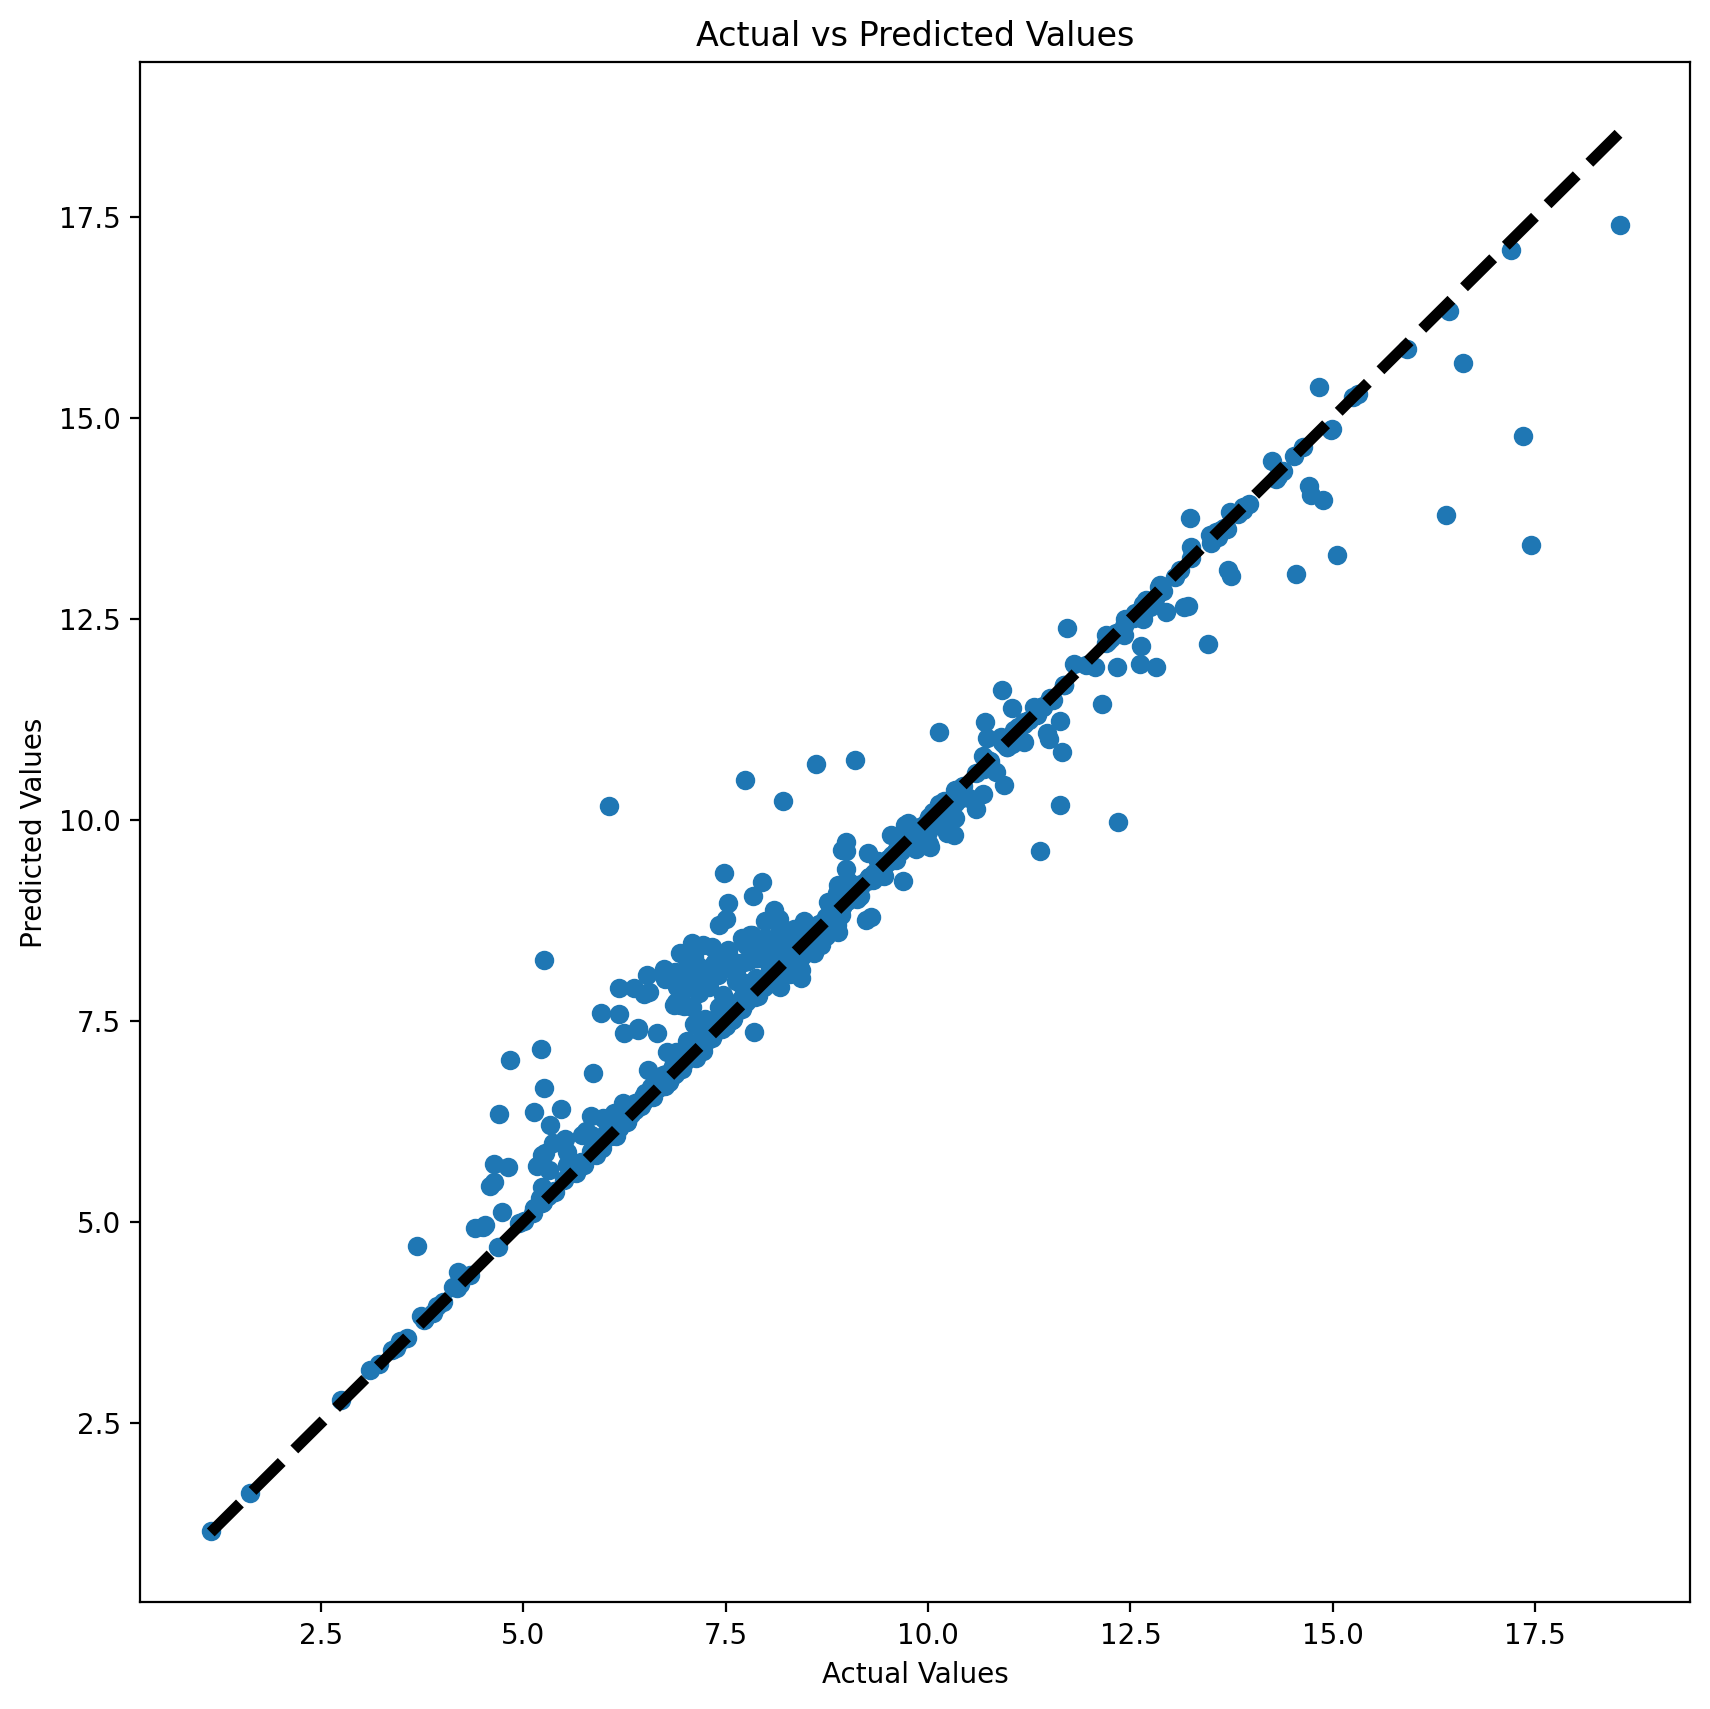

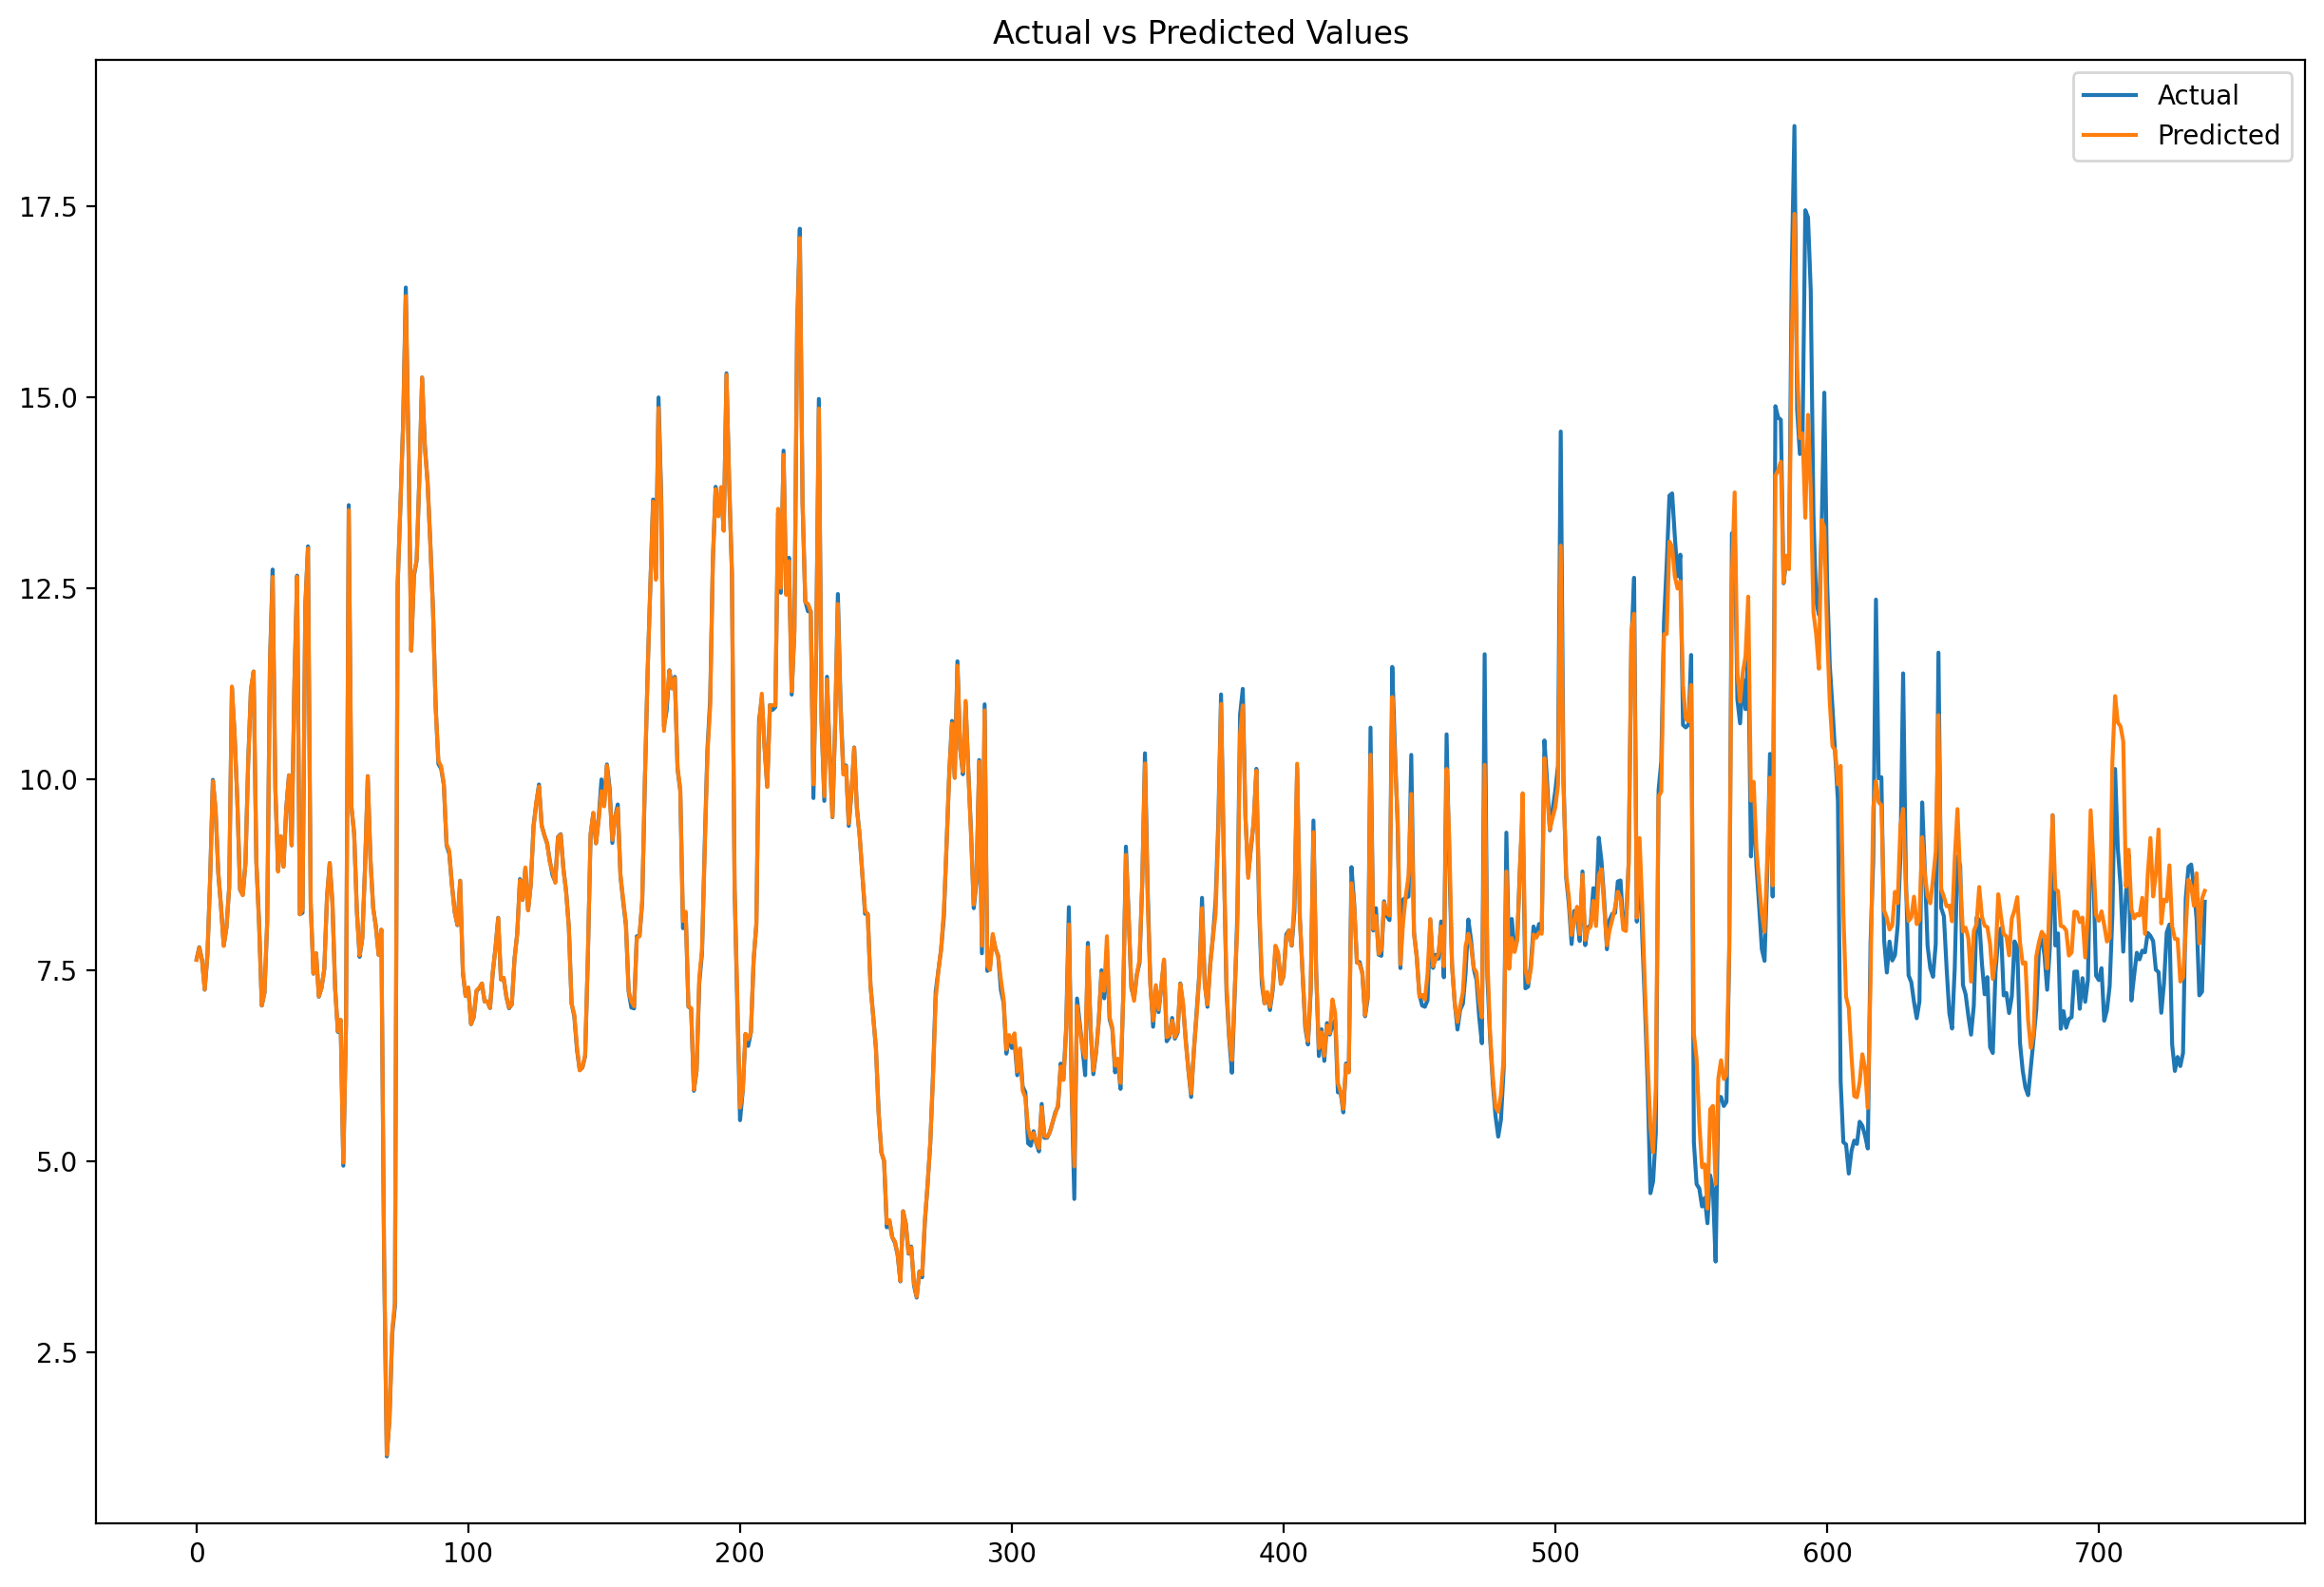

               Spend    Actual  Predicted
DATE                                     
2024-06-01   8207.32  8.504995   8.593681
2024-06-02  10639.82  9.009162   9.076238
2024-06-03  14041.80  7.102580   8.298386
2024-06-04  15163.46  7.429427   8.176928
2024-06-05  16143.74  7.727975   8.231947
2024-06-06  15907.63  7.640552   8.214112
2024-06-07  14511.37  7.755943   8.446403
2024-06-08  12218.50  7.733228   7.974469
2024-06-09  13189.17  7.988595   8.743236
2024-06-10  14959.38  7.948661   9.229283
2024-06-11  16462.61  7.880618   8.464405
2024-06-12  15019.62  7.506057   8.760840
2024-06-13  14139.14  7.473118   9.341101
2024-06-14  12432.67  6.941748   8.111483
2024-06-15   7776.41  7.329321   8.423158
2024-06-16   7818.61  7.994489   8.401339
2024-06-17  15311.44  8.097007   8.872191
2024-06-18  14454.08  6.525544   8.072053
2024-06-19  13889.33  6.181277   7.909539
2024-06-20  13835.13  6.363905   7.905978
2024-06-21  12470.07  6.244402   7.351852
2024-06-22   8744.09  6.415326   7

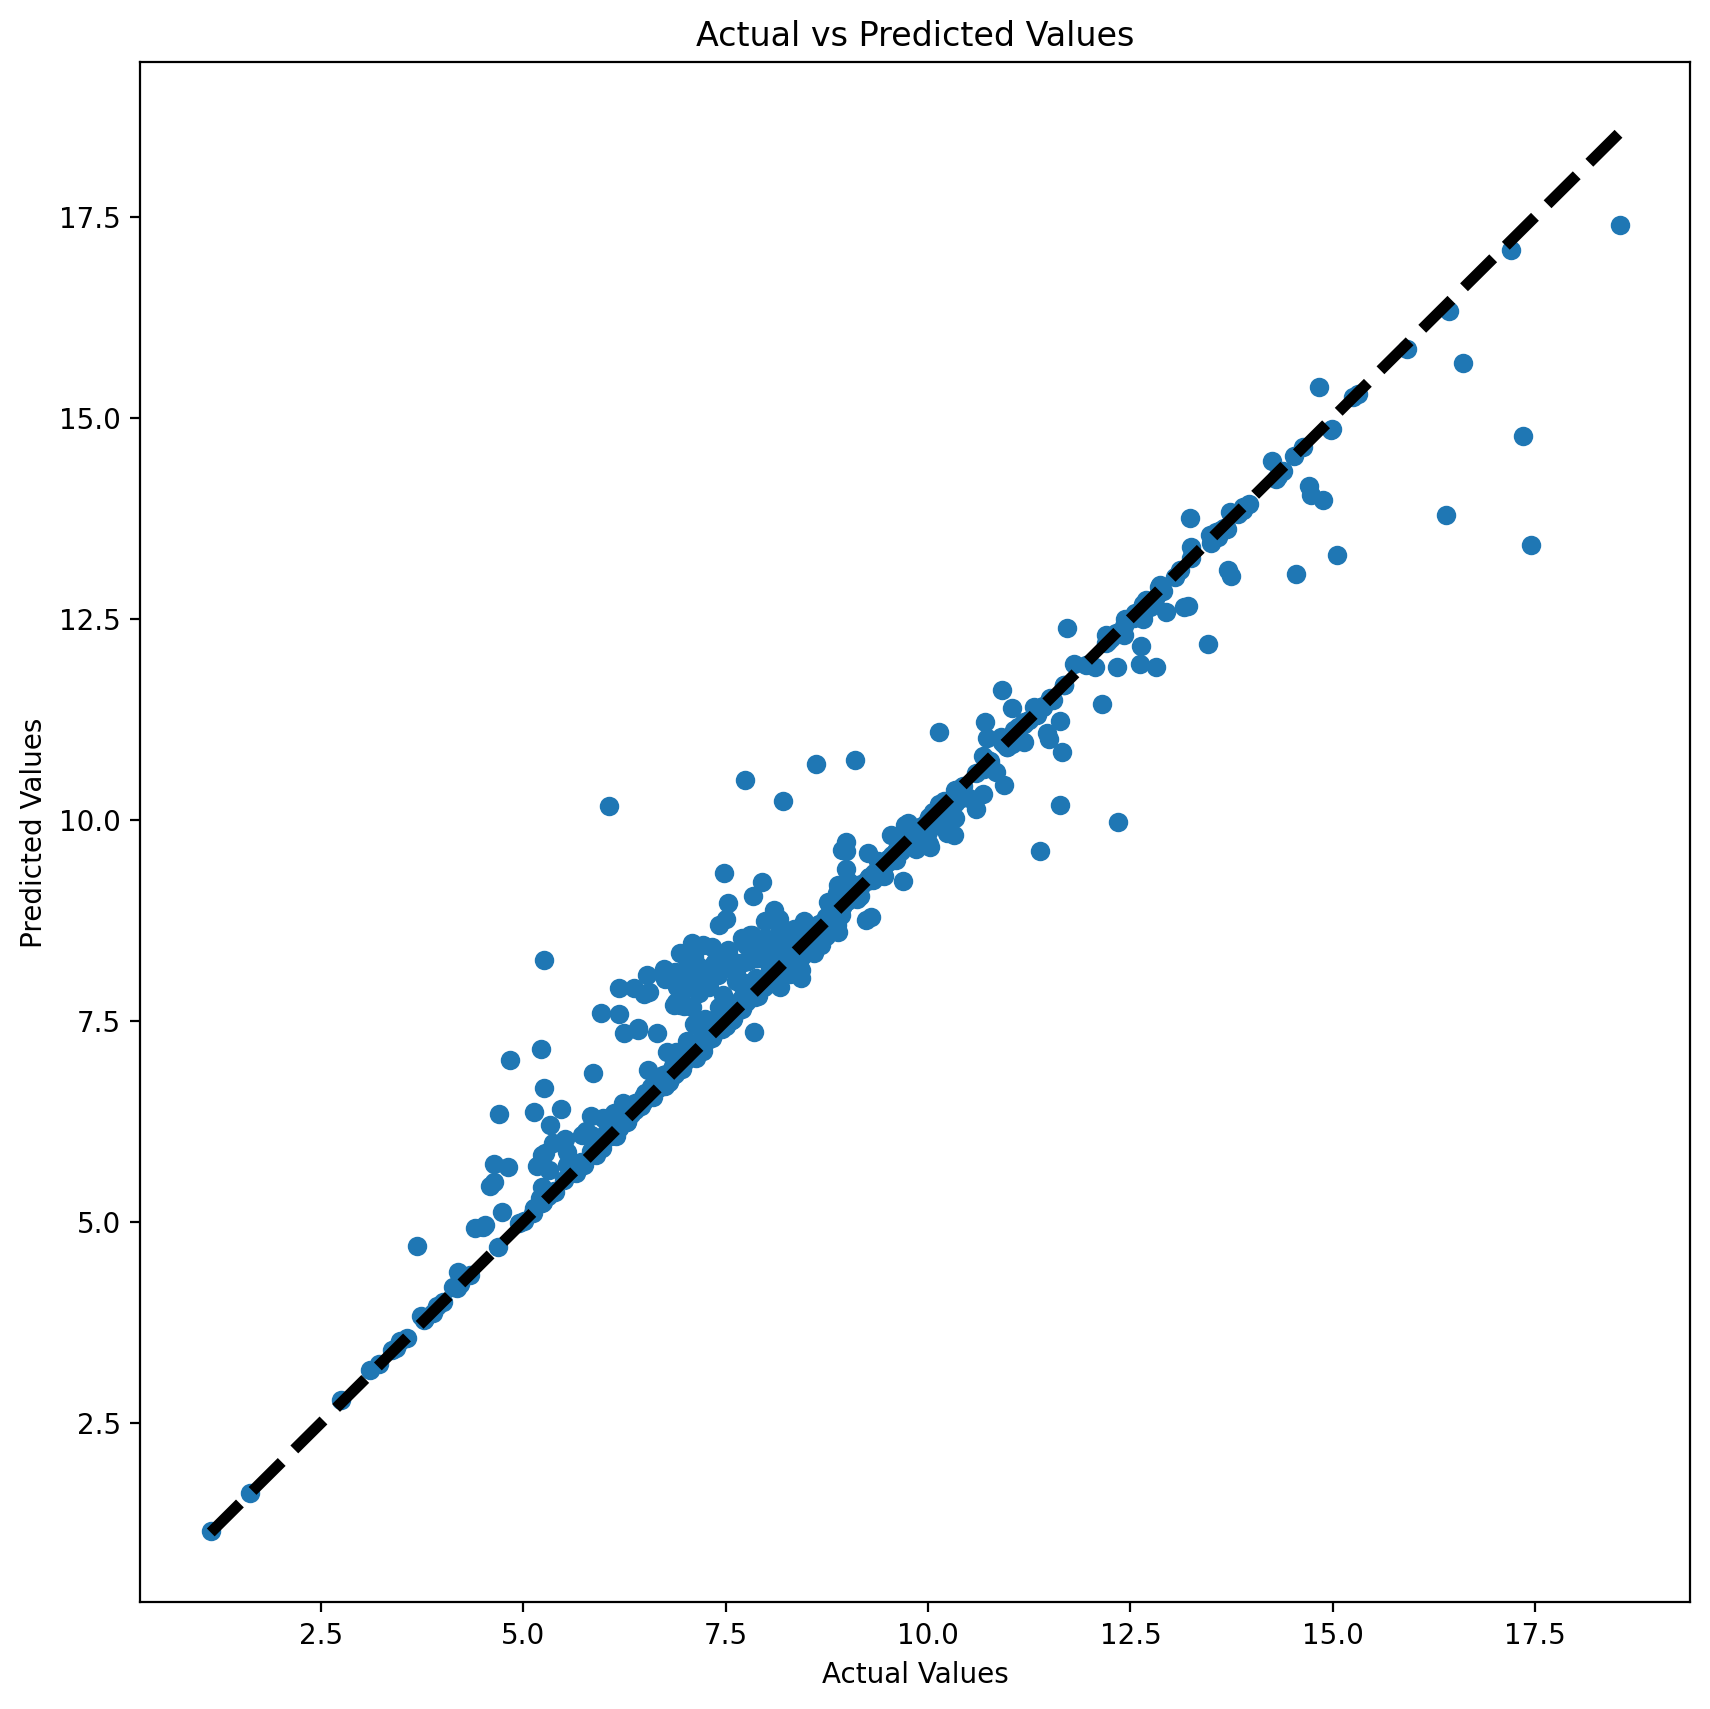

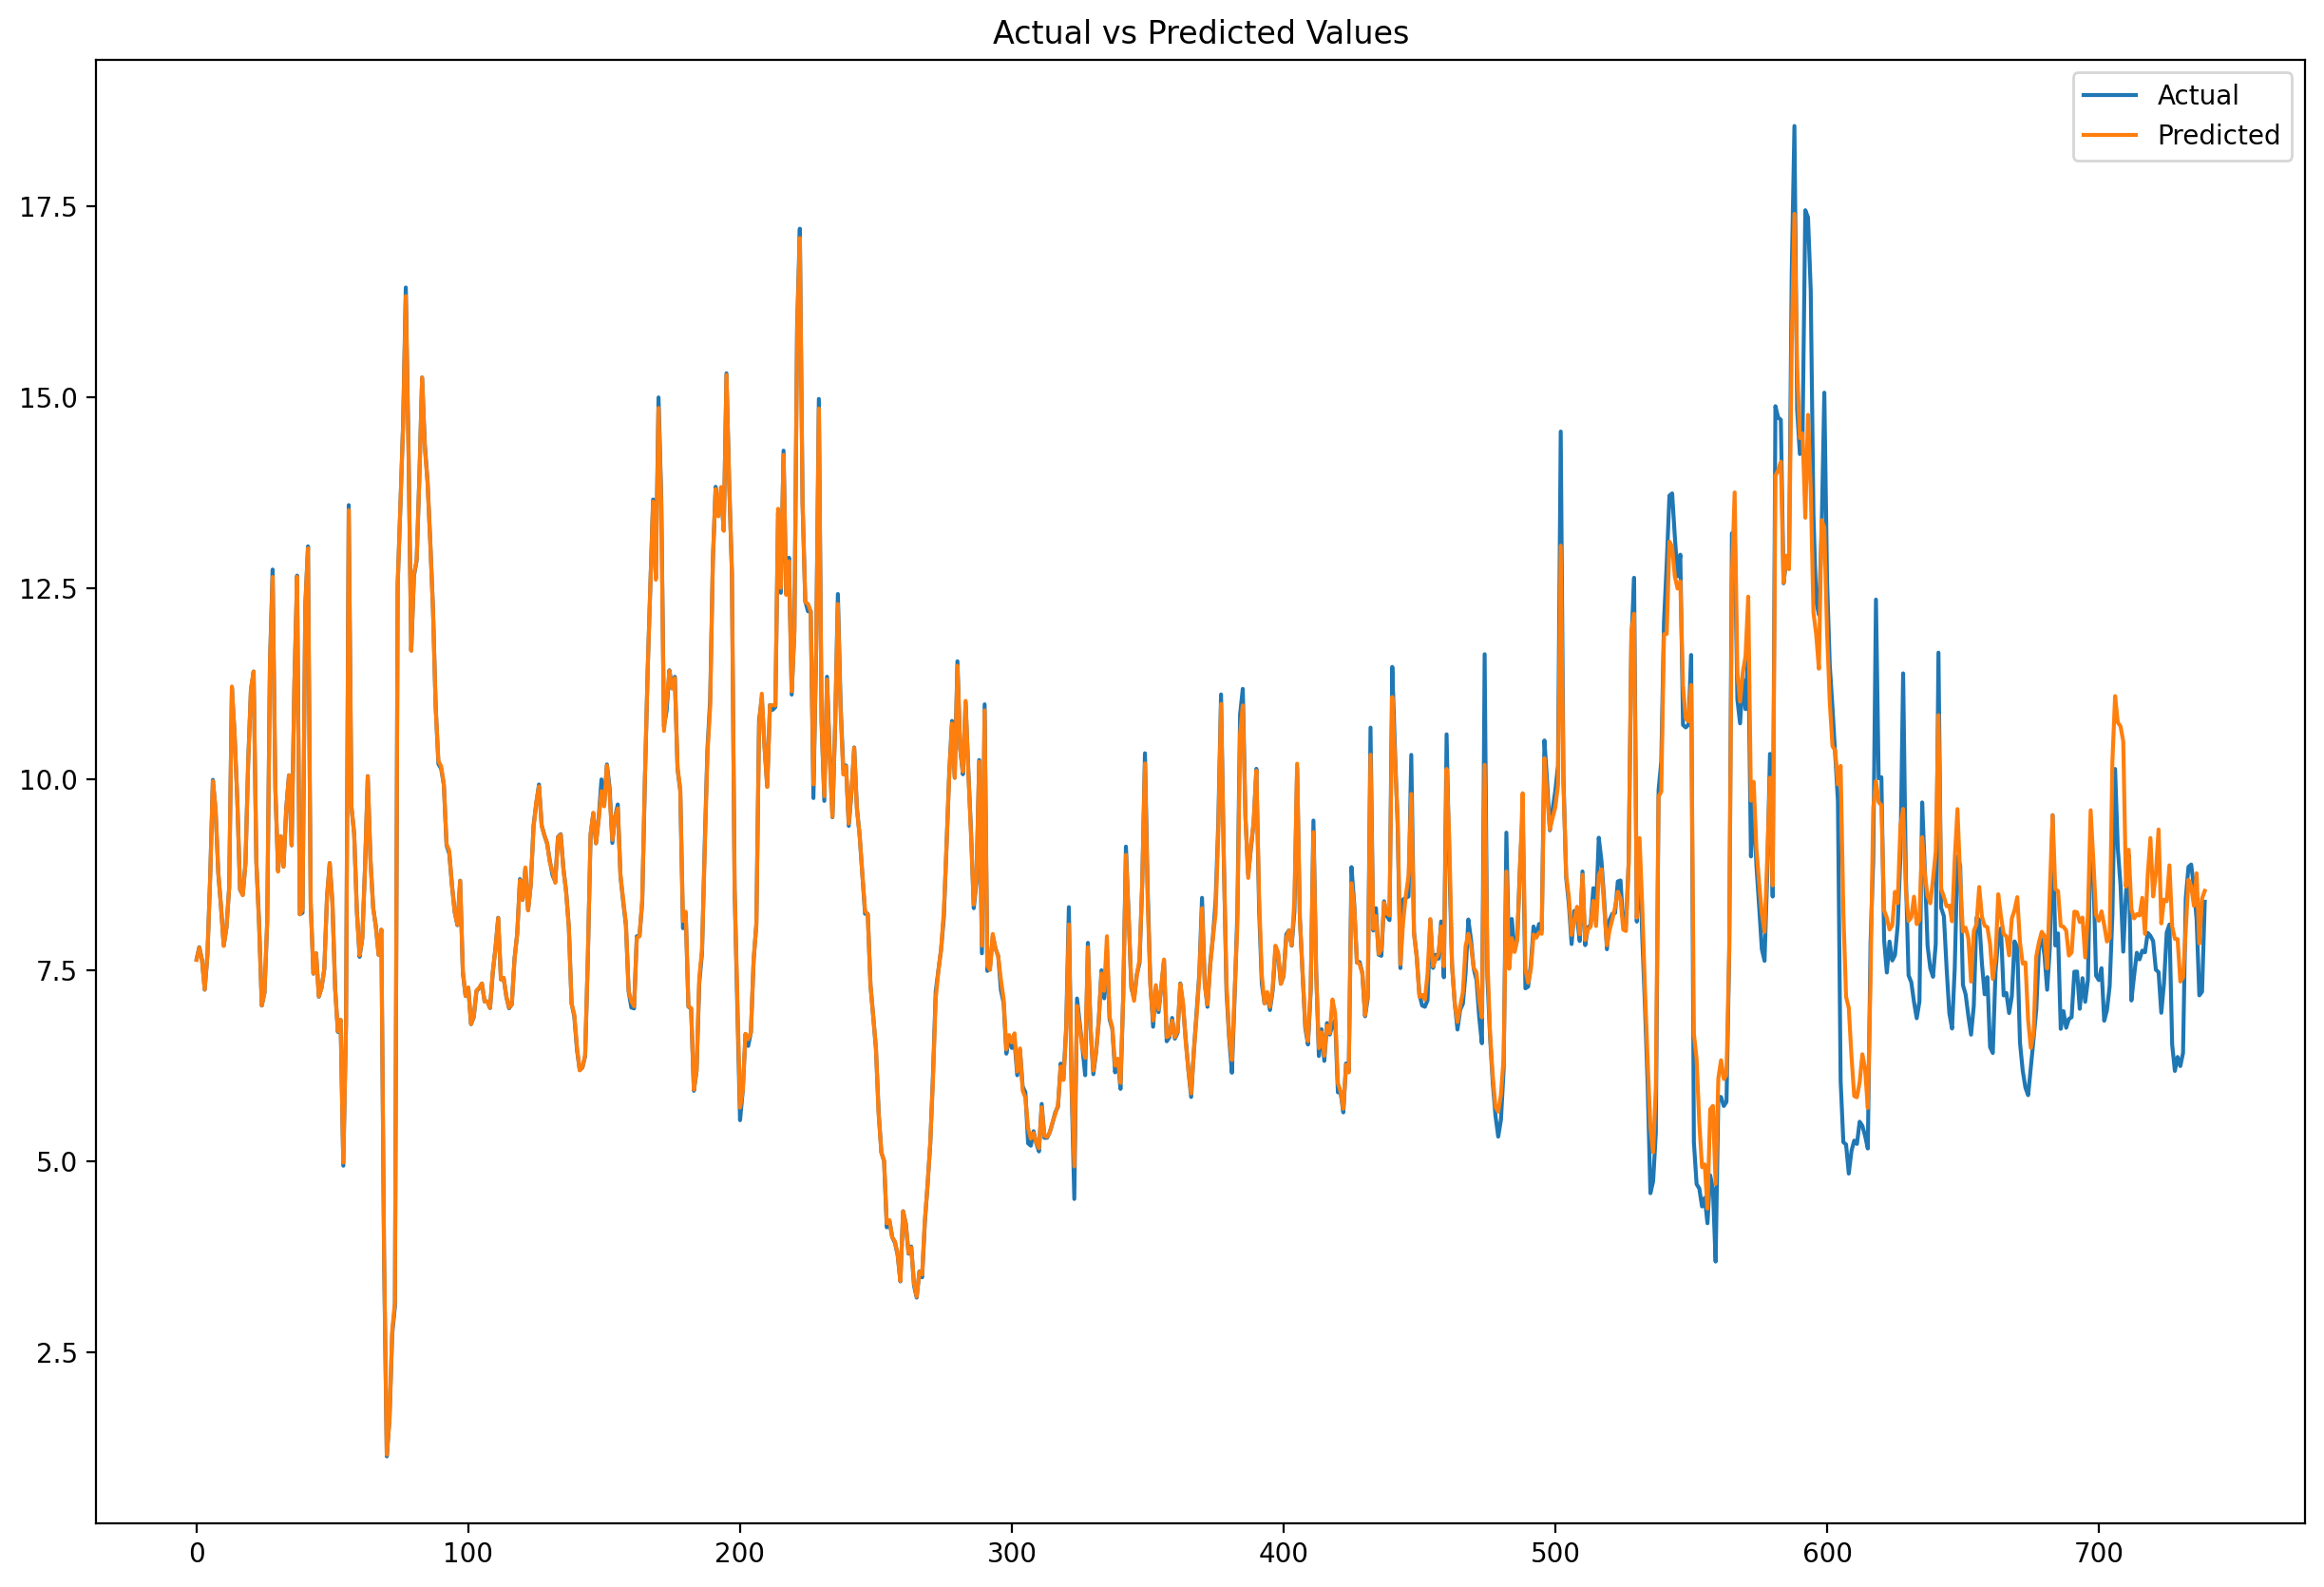

               Spend    Actual  Predicted
DATE                                     
2024-06-01   8207.32  8.504995   8.593681
2024-06-02  10639.82  9.009162   9.076238
2024-06-03  14041.80  7.102580   8.298386
2024-06-04  15163.46  7.429427   8.176928
2024-06-05  16143.74  7.727975   8.231947
2024-06-06  15907.63  7.640552   8.214112
2024-06-07  14511.37  7.755943   8.446403
2024-06-08  12218.50  7.733228   7.974469
2024-06-09  13189.17  7.988595   8.743236
2024-06-10  14959.38  7.948661   9.229283
2024-06-11  16462.61  7.880618   8.464405
2024-06-12  15019.62  7.506057   8.760840
2024-06-13  14139.14  7.473118   9.341101
2024-06-14  12432.67  6.941748   8.111483
2024-06-15   7776.41  7.329321   8.423158
2024-06-16   7818.61  7.994489   8.401339
2024-06-17  15311.44  8.097007   8.872191
2024-06-18  14454.08  6.525544   8.072053
2024-06-19  13889.33  6.181277   7.909539
2024-06-20  13835.13  6.363905   7.905978
2024-06-21  12470.07  6.244402   7.351852
2024-06-22   8744.09  6.415326   7

Actual_Spend  Actual_CPC  Predicted_CPC          ROI
DATE                                                            
2022-06-13      10910.71    7.640553       7.634164  1417.583310
2022-06-14      11216.93    7.800369       7.794577  1196.531131
2022-06-15      10757.07    7.634542       7.634542  1397.019729
2022-06-16      10670.71    7.244202       7.246399  2031.594247
2022-06-17       9582.73    7.696972       7.696428  1157.448546
2022-06-18       6319.13    8.704036       8.693526   -49.054370
2022-06-19       6473.50    9.989969       9.973257  -874.459925
2022-06-20      11385.93    9.600278       9.612711 -1168.679067
2022-06-21      11282.74    8.766698       8.782305  -200.756778
2022-06-22      10861.17    8.329118       8.332796   382.221153
2022-06-23      10707.94    7.821724       7.816128  1109.563197
2022-06-24       9186.37    8.058219       8.054642   651.683062
2022-06-25       6058.90    8.582011       8.572496    37.843751
2022-06-26       7976.84   11.187714      11.212092 -1839.846202
2022-06-27      12457.30   10.592942      10.578760 -2299.477384
2022-06-28      12149.55    9.727422       9.716197 -1363.180216
2022-06-29      12187.68    8.552758       8.562778    90.041634
2022-06-30      11677.55    8.486592       8.479824   201.353698
2022-07-01       9683.57    8.908528       8.882901  -280.014332
2022-07-02       6580.68   10.234339      10.212876 -1022.480191

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle

def preprocess_train(dataset, target, spend):
    X = dataset.drop(target, axis=1, errors='ignore')
    y = dataset[target]
    spend_data = dataset[spend]
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        spend_train, spend_test = spend_data.iloc[train_index], spend_data.iloc[test_index]
        yield X_train, y_train, X_test, y_test, spend_train, spend_test

def perform_cv(model, X, y, scoring='r2'):
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    return {'mean_score': np.mean(scores), 'std_score': np.std(scores)}

def plot_preds(y_test, y_pred, spend):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))

def model(folds, ss=None, y_scaler=None):
    if ss is None:
        ss = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    models = {
        'RFR': {
            'pipeline': Pipeline([('fit', RandomForestRegressor())]),
            'requires_scaling': True,
            'param_grid': {
                'fit__n_estimators': [100, 300],
                'fit__max_depth': [10, None],
                'fit__min_samples_split': [2, 5],
                'fit__min_samples_leaf': [1, 2],
                'fit__max_features': ['auto', 'sqrt', 'log2']
            }
        }
    }

    best_estimators = {}
    cv_results = {}
    evaluation_metrics = {}
    all_spend_test = []

    for name, model_info in models.items():
        print(f"Processing {name} model...")
        pipeline = model_info['pipeline']
        requires_scaling = model_info['requires_scaling']

        all_X_train = []
        all_y_train = []
        all_X_test = []
        all_y_test = []
        all_spend = []

        for X_train, y_train, X_test, y_test, spend_train, spend_test in folds:
            all_X_train.append(X_train)
            all_y_train.append(y_train)
            all_X_test.append(X_test)
            all_y_test.append(y_test)
            all_spend.append(spend_test)

        print(f"Number of folds for {name}: {len(all_X_train)}")
        if not all_X_train:
            print(f"No folds found for {name} model.")
            continue

        all_X_train = pd.concat(all_X_train)
        all_y_train = pd.concat(all_y_train)
        all_X_test = pd.concat(all_X_test)
        all_y_test = pd.concat(all_y_test)
        all_spend_test = pd.concat(all_spend)

        X_train_processed = ss.fit_transform(all_X_train) if requires_scaling else all_X_train
        X_test_processed = ss.transform(all_X_test) if requires_scaling else all_X_test
        y_train_processed = y_scaler.fit_transform(all_y_train.values.reshape(-1, 1)) if requires_scaling else all_y_train
        y_test_processed = y_scaler.transform(all_y_test.values.reshape(-1, 1)) if requires_scaling else all_y_test

        if 'param_grid' in model_info:
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=model_info['param_grid'],
                cv=5,
                scoring='r2',
                refit=True,
                verbose=1
            )
            grid_search.fit(X_train_processed, y_train_processed.ravel())
            best_model = grid_search.best_estimator_
            best_estimators[name] = best_model
            cv_results[name] = {
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }
        else:
            pipeline.fit(X_train_processed, y_train_processed.ravel())
            best_model = pipeline
            best_estimators[name] = best_model
            cv_results[name] = {'best_score': 'N/A', 'best_params': 'Default'}

        y_pred_processed = best_model.predict(X_test_processed)
        y_pred_original_scale = y_scaler.inverse_transform(y_pred_processed.reshape(-1, 1)).flatten()
        y_test_original_scale = y_scaler.inverse_transform(y_test_processed).flatten()

        r2 = r2_score(y_test_original_scale, y_pred_original_scale)
        mape = round(mean_absolute_percentage_error(y_test_original_scale, y_pred_original_scale), 3)
        mse = round(mean_squared_error(y_test_original_scale, y_pred_original_scale), 3)
        evaluation_metrics[name] = {'R2': r2, 'MAPE': f'{mape:.3f}', 'MSE': f'{mse:.3f}'}

        plot_preds(y_test_original_scale, y_pred_original_scale, all_spend_test)
        print(f"R2 for {name} model: {r2}")
        print(f"MAPE for {name} model: {mape}")
        print(f"MSE for {name} model: {mse}")

    best_model_name = max(evaluation_metrics, key=lambda name: evaluation_metrics[name]['R2'])
    avg_max_r2 = evaluation_metrics[best_model_name]['R2']

    return {
        'y_test': y_test_original_scale,
        'y_pred': y_pred_original_scale,
        'spend': all_spend_test,
        'best_model_name': best_model_name,
        'best_model': best_estimators[best_model_name],
        'cv_results': cv_results,
        'evaluation_metrics': evaluation_metrics,
        'r2_scores': {model: evaluation_metrics[model]['R2'] for model in models},
        'y_scaler': y_scaler,
        'scaler': ss
    }

def plot_preds_and_calculate_roi(y_test, y_pred, spend, value_per_click):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))
    
    # Calculate ROI
    spend_vs_actual_predicted['Predicted_Clicks'] = spend_vs_actual_predicted['Spend'] / spend_vs_actual_predicted['Predicted']
    spend_vs_actual_predicted['ROI'] = spend_vs_actual_predicted['Predicted_Clicks'] * value_per_click - spend_vs_actual_predicted['Spend']

    optimal_spend_row = spend_vs_actual_predicted.loc[spend_vs_actual_predicted['ROI'].idxmax()]
    optimal_spend = optimal_spend_row['Spend']
    max_roi = optimal_spend_row['ROI']

    print(f'Optimal Spend: {optimal_spend}, Max ROI: {max_roi}')

    # Stats for each eval
    summary_data = {
        'Avg Predicted CPC': [spend_vs_actual_predicted['Predicted'].mean()],
        'Avg Actual CPC': [spend_vs_actual_predicted['Actual'].mean()],
        'Avg Spend': [spend_vs_actual_predicted['Spend'].mean()]
    }

    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

    return optimal_spend, max_roi, spend_vs_actual_predicted['ROI']

def find_best_model_across_targets_and_save(dataset, target, spend, model_save_path):
    overall_best_model = None
    overall_best_r2 = -float('inf')
    overall_best_model_name = ""

    print(f"Running modeling process for target: {target}\n")
    folds = list(preprocess_train(dataset, target, spend))
    results = model(folds)

    best_model_name = results['best_model_name']
    target_best_r2 = float(results['evaluation_metrics'][best_model_name]['R2'])
    print(f"Best model is {best_model_name} with R2 score: {target_best_r2}\n")

    if target_best_r2 > overall_best_r2:
        overall_best_r2 = target_best_r2
        overall_best_model = results['best_model']
        overall_best_model_name = best_model_name
        overall_best_ytest = results['y_test']
        overall_best_ypred = results['y_pred']
        overall_best_model_spend = results['spend']

        # Save the best model
        with open(model_save_path, 'wb') as file:
            pickle.dump({
                'model': overall_best_model,
                'scaler': results['scaler'],
                'y_scaler': results['y_scaler'],
                'feature_names': dataset.drop([target, spend], axis=1).columns.tolist()
            }, file)
        print(f'Best model saved at {model_save_path}')

    return {
        'best_model': overall_best_model,
        'best_model_name': overall_best_model_name,
        'overall_best_r2': overall_best_r2,
        'y_test': overall_best_ytest,
        'y_pred': overall_best_ypred,
        'spend': overall_best_model_spend
    }

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    plot_preds(y_test, y_pred)

# Example usage:
total_spend = smaller_set['SPEND'].sum()
total_clicks = smaller_set['CLICKS'].sum()
cost_per_overall = total_spend / total_clicks

# Args
target_column = 'CPC'
spend_column = 'SPEND'
spend_range = range(1000, 20000, 500) # min spend, max spend, increments of 500
model_save_path = 'best_model_no_shap.pkl'
value_per_click = cost_per_overall

# Find best model and save it
best_model_results = find_best_model_across_targets_and_save(smaller_set, target_column, spend_column, model_save_path)

# Calculate optimal spend and ROI using the test data
optimal_spend, max_roi, roi = plot_preds_and_calculate_roi(
    best_model_results['y_test'], 
    best_model_results['y_pred'], 
    best_model_results['spend'], 
    value_per_click
)

actual_cpc = best_model_results['y_test']
pred_cpc = best_model_results['y_pred'] 
actual_spend = best_model_results['spend']

print(f'Optimal Spend: {optimal_spend}, Max ROI: {max_roi}, Actual Spend: {actual_spend}, Predicted CPC: {pred_cpc}, Actual CPC: {actual_cpc}')

pred_df = pd.DataFrame(data={"Actual_Spend": actual_spend, "Actual_CPC": actual_cpc, "Predicted_CPC": pred_cpc, "ROI": roi})
print('Optimal Spend: ', optimal_spend, 'Max ROI: ', max_roi)
pred_df.head(20)


#### LOADING SAVED MODEL AND TESTING 
- Load RFR
- Calculates optimal spend for given dataset
- Tests different spends in provided range
- Determines estimated return per day

# USE CODE BELOW (NEWEST FUNCTIONS)

In [5]:
smaller_set.describe()

SPEND       CLICKS   IMPRESSIONS  SEARCH_IMPRESSION_SHARE  \
count    899.000000   899.000000    899.000000               899.000000   
mean   10171.455278  1211.144605   5732.165740                 1.551935   
std     3174.663214   439.178468   2048.326813                 0.256283   
min        4.720000     8.000000    151.000000                 0.480000   
25%     8229.900000   894.500000   4096.500000                 1.441667   
50%    10669.070000  1216.600000   5626.500000                 1.623333   
75%    12480.960000  1529.000000   7535.000000                 1.730000   
max    14991.730000  2452.000000  11926.000000                 1.950000   

              CPC  ELIGIBLE_IMPRESSIONS     lag_SPEND   lag_CLICKS  \
count  899.000000            899.000000    899.000000   899.000000   
mean     8.960644           3752.574528  10901.644961  1279.463849   
std      3.126585           1411.942504   3761.193464   449.737689   
min      0.420000            184.146341      4.720000     8.000000   
25%      7.104901           2540.995915   8531.100000   964.000000   
50%      8.185487           3773.484848  11339.490000  1311.333333   
75%     10.359049           4887.746498  13310.005000  1595.666667   
max     22.614859           9455.844156  22210.930000  2452.000000   

       lag_IMPRESSIONS  lag_ELIGIBLE_IMPRESSIONS  rolling_7_SPEND  \
count       899.000000                899.000000       899.000000   
mean       6087.903226               3994.531860     11289.728966   
std        2025.005937               1378.015764      3209.200786   
min         151.000000                184.146341      1237.160000   
25%        4526.500000               2853.763359      9403.317143   
50%        6428.000000               4206.569343     11117.670000   
75%        7720.666667               5013.747166     13195.715000   
max       11926.000000               8772.151899     21278.991429   

       rolling_14_SPEND  rolling_7_CLICKS  rolling_14_CLICKS  \
count        899.000000        899.000000         899.000000   
mean       11420.249154       1303.917210        1304.982361   
std         2985.579104        351.393965         328.676013   
min         3936.982857        165.285714         398.857143   
25%         9570.916429       1061.214286        1072.535714   
50%        10985.813333       1335.142857        1336.700000   
75%        13028.366696       1540.952381        1525.107143   
max        23169.095714       2127.714286        1937.714286   

       rolling_7_IMPRESSIONS  rolling_14_IMPRESSIONS  \
count             899.000000              899.000000   
mean             6241.891467             6263.607699   
std              1258.158924             1090.594856   
min              1021.857143             2347.571429   
25%              5670.500000             5673.285714   
50%              6575.000000             6564.714286   
75%              7037.285714             6959.178571   
max              8943.285714             8323.357143   

       rolling_7_ELIGIBLE_IMPRESSIONS  rolling_14_ELIGIBLE_IMPRESSIONS  
count                      899.000000                       899.000000  
mean                      4089.227137                      4092.864217  
std                        766.058225                       685.870769  
min                        929.357750                      1847.940969  
25%                       3759.972888                      3840.983385  
50%                       4182.401843                      4203.180542  
75%                       4509.375150                      4455.496374  
max                       6615.833791                      6377.269913

In [ ]:
actual_metrics_df.to_csv('./actual_metrics_df_ROI.csv')
actual_metrics_df.head(20)

In [9]:
spend_range_df.to_csv('./spend_range_metrics_df_ROI.csv')
spend_range_df.head(20)

Spend Range  Predicted CPC Spend Range  \
Date                                                 
2022-01-14          500                  10.747666   
2022-01-15          500                  13.935435   
2022-01-16          500                  17.342335   
2022-01-17          500                  11.268865   
2022-01-18          500                  11.924563   
2022-01-19          500                  12.282866   
2022-01-20          500                  11.260701   
2022-01-21          500                  10.923695   
2022-01-22          500                  13.050150   
2022-01-23          500                  12.846702   
2022-01-24          500                  15.530000   
2022-01-25          500                   8.972408   
2022-01-26          500                   8.940974   
2022-01-27          500                   7.688268   
2022-01-28          500                   8.239234   
2022-01-29          500                  11.269393   
2022-01-30          500                  11.017406   
2022-01-31          500                   9.506993   
2022-02-01          500                   9.154702   
2022-02-02          500                  10.776967   

            Predicted Clicks Spend Range  ROI Spend Range  
Date                                                       
2022-01-14                     46.521727      -109.300438  
2022-01-15                     35.879755      -198.674030  
2022-01-16                     28.831182      -257.869477  
2022-01-17                     44.370041      -127.370767  
2022-01-18                     41.930256      -147.860608  
2022-01-19                     40.707111      -158.132849  
2022-01-20                     44.402208      -127.100621  
2022-01-21                     45.772059      -115.596311  
2022-01-22                     38.313735      -178.232939  
2022-01-23                     38.920495      -173.137231  
2022-01-24                     32.195750      -229.613107  
2022-01-25                     55.726398       -31.997614  
2022-01-26                     55.922317       -30.352246  
2022-01-27                     65.034153        46.170934  
2022-01-28                     60.685256         9.647950  
2022-01-29                     44.367962      -127.388221  
2022-01-30                     45.382731      -118.865970  
2022-01-31                     52.592863       -58.313723  
2022-02-01                     54.616742       -41.316747  
2022-02-02                     46.395244      -110.362667

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle

# Function to preprocess training data
def preprocess_train(dataset, target, spend):
    X = dataset.drop(target, axis=1, errors='ignore')
    y = dataset[target]
    spend_data = dataset[spend]
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        spend_train, spend_test = spend_data.iloc[train_index], spend_data.iloc[test_index]
        yield X_train, y_train, X_test, y_test, spend_train, spend_test

# Function to perform cross-validation
def perform_cv(model, X, y, scoring='r2'):
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    return {'mean_score': np.mean(scores), 'std_score': np.std(scores)}

# Function to plot predictions
def plot_preds(y_test, y_pred, spend):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))

# Function to train the model
def model(folds, ss=None, y_scaler=None):
    if ss is None:
        ss = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    models = {
        'RFR': {
            'pipeline': Pipeline([('fit', RandomForestRegressor())]),
            'requires_scaling': True,
            'param_grid': {
                'fit__n_estimators': [100, 300],
                'fit__max_depth': [10, None],
                'fit__min_samples_split': [2, 5],
                'fit__min_samples_leaf': [1, 2],
                'fit__max_features': ['auto', 'sqrt', 'log2']
            }
        }
    }

    best_estimators = {}
    cv_results = {}
    evaluation_metrics = {}
    all_spend_test = []

    for name, model_info in models.items():
        print(f"Processing {name} model...")
        pipeline = model_info['pipeline']
        requires_scaling = model_info['requires_scaling']

        all_X_train = []
        all_y_train = []
        all_X_test = []
        all_y_test = []
        all_spend = []

        for X_train, y_train, X_test, y_test, spend_train, spend_test in folds:
            all_X_train.append(X_train)
            all_y_train.append(y_train)
            all_X_test.append(X_test)
            all_y_test.append(y_test)
            all_spend.append(spend_test)

        print(f"Number of folds for {name}: {len(all_X_train)}")
        if not all_X_train:
            print(f"No folds found for {name} model.")
            continue

        all_X_train = pd.concat(all_X_train)
        all_y_train = pd.concat(all_y_train)
        all_X_test = pd.concat(all_X_test)
        all_y_test = pd.concat(all_y_test)
        all_spend_test = pd.concat(all_spend)

        X_train_processed = ss.fit_transform(all_X_train) if requires_scaling else all_X_train
        X_test_processed = ss.transform(all_X_test) if requires_scaling else all_X_test
        y_train_processed = y_scaler.fit_transform(all_y_train.values.reshape(-1, 1)) if requires_scaling else all_y_train
        y_test_processed = y_scaler.transform(all_y_test.values.reshape(-1, 1)) if requires_scaling else all_y_test

        if 'param_grid' in model_info:
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=model_info['param_grid'],
                cv=5,
                scoring='r2',
                refit=True,
                verbose=1
            )
            grid_search.fit(X_train_processed, y_train_processed.ravel())
            best_model = grid_search.best_estimator_
            best_estimators[name] = best_model
            cv_results[name] = {
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }
        else:
            pipeline.fit(X_train_processed, y_train_processed.ravel())
            best_model = pipeline
            best_estimators[name] = best_model
            cv_results[name] = {'best_score': 'N/A', 'best_params': 'Default'}

        y_pred_processed = best_model.predict(X_test_processed)
        y_pred_original_scale = y_scaler.inverse_transform(y_pred_processed.reshape(-1, 1)).flatten()
        y_test_original_scale = y_scaler.inverse_transform(y_test_processed).flatten()

        r2 = r2_score(y_test_original_scale, y_pred_original_scale)
        mape = round(mean_absolute_percentage_error(y_test_original_scale, y_pred_original_scale), 3)
        mse = round(mean_squared_error(y_test_original_scale, y_pred_original_scale), 3)
        evaluation_metrics[name] = {'R2': r2, 'MAPE': f'{mape:.3f}', 'MSE': f'{mse:.3f}'}

        plot_preds(y_test_original_scale, y_pred_original_scale, all_spend_test)
        print(f"R2 for {name} model: {r2}")
        print(f"MAPE for {name} model: {mape}")
        print(f"MSE for {name} model: {mse}")

    best_model_name = max(evaluation_metrics, key=lambda name: evaluation_metrics[name]['R2'])
    avg_max_r2 = evaluation_metrics[best_model_name]['R2']

    return {
        'y_test': y_test_original_scale,
        'y_pred': y_pred_original_scale,
        'spend': all_spend_test,
        'best_model_name': best_model_name,
        'best_model': best_estimators[best_model_name],
        'cv_results': cv_results,
        'evaluation_metrics': evaluation_metrics,
        'r2_scores': {model: evaluation_metrics[model]['R2'] for model in models},
        'y_scaler': y_scaler,
        'scaler': ss
    }

def plot_preds_and_calculate_roi(y_test, y_pred, spend, value_per_click):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))
    
    # Calculate ROI
    spend_vs_actual_predicted['Predicted_Clicks'] = spend_vs_actual_predicted['Spend'] / spend_vs_actual_predicted['Predicted']
    spend_vs_actual_predicted['ROI'] = spend_vs_actual_predicted['Predicted_Clicks'] * value_per_click - spend_vs_actual_predicted['Spend']

    optimal_spend_row = spend_vs_actual_predicted.loc[spend_vs_actual_predicted['ROI'].idxmax()]
    optimal_spend = optimal_spend_row['Spend']
    max_roi = optimal_spend_row['ROI']

    print(f'Optimal Spend: {optimal_spend}, Max ROI: {max_roi}')

    # Stats for each eval
    summary_data = {
        'Avg Predicted CPC': [spend_vs_actual_predicted['Predicted'].mean()],
        'Avg Actual CPC': [spend_vs_actual_predicted['Actual'].mean()],
        'Avg Spend': [spend_vs_actual_predicted['Spend'].mean()]
    }

    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

    return optimal_spend, max_roi, spend_vs_actual_predicted['ROI']

def find_best_model_across_targets_and_save(dataset, target, spend, model_save_path):
    overall_best_model = None
    overall_best_r2 = -float('inf')
    overall_best_model_name = ""

    print(f"Running modeling process for target: {target}\n")
    folds = list(preprocess_train(dataset, target, spend))
    results = model(folds)

    best_model_name = results['best_model_name']
    target_best_r2 = float(results['evaluation_metrics'][best_model_name]['R2'])
    print(f"Best model is {best_model_name} with R2 score: {target_best_r2}\n")

    if target_best_r2 > overall_best_r2:
        overall_best_r2 = target_best_r2
        overall_best_model = results['best_model']
        overall_best_model_name = best_model_name
        overall_best_ytest = results['y_test']
        overall_best_ypred = results['y_pred']
        overall_best_model_spend = results['spend']

        # Save the best model
        with open(model_save_path, 'wb') as file:
            pickle.dump({
                'model': overall_best_model,
                'scaler': results['scaler'],
                'y_scaler': results['y_scaler'],
                'feature_names': dataset.drop([target], axis=1).columns.tolist()
            }, file)
        print(f'Best model saved at {model_save_path}')

    return {
        'best_model': overall_best_model,
        'best_model_name': overall_best_model_name,
        'overall_best_r2': overall_best_r2,
        'y_test': overall_best_ytest,
        'y_pred': overall_best_ypred,
        'spend': overall_best_model_spend
    }

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    plot_preds(y_test, y_pred)

# Example usage:
total_spend = smaller_set['SPEND'].sum()
total_clicks = smaller_set['CLICKS'].sum()
cost_per_overall = total_spend / total_clicks

# Args
target_column = 'CPC'
spend_column = 'SPEND'
spend_range = range(1000, 20000, 500) # min spend, max spend, increments of 500
model_save_path = 'best_model_no_shap3.pkl'
value_per_click = cost_per_overall

# Find best model and save it
best_model_results = find_best_model_across_targets_and_save(smaller_set, target_column, spend_column, model_save_path)

# Calculate optimal spend and ROI using the test data
optimal_spend, max_roi, roi = plot_preds_and_calculate_roi(
    best_model_results['y_test'], 
    best_model_results['y_pred'], 
    best_model_results['spend'], 
    value_per_click
)

actual_cpc = best_model_results['y_test']
pred_cpc = best_model_results['y_pred'] 
actual_spend = best_model_results['spend']

print(f'Optimal Spend: {optimal_spend}, Max ROI: {max_roi}, Actual Spend: {actual_spend}, Predicted CPC: {pred_cpc}, Actual CPC: {actual_cpc}')

pred_df = pd.DataFrame(data={"Actual_Spend": actual_spend, "Actual_CPC": actual_cpc, "Predicted_CPC": pred_cpc, "ROI": roi})
print('Optimal Spend: ', optimal_spend, 'Max ROI: ', max_roi)
pred_df.head(20)


In [ ]:
# Calculate ROI
spend_vs_actual_predicted['Predicted_Clicks'] = spend_vs_actual_predicted['Spend'] / spend_vs_actual_predicted['Predicted']
spend_vs_actual_predicted['ROI'] = spend_vs_actual_predicted['Predicted_Clicks'] * value_per_click - spend_vs_actual_predicted['Spend']

optimal_spend_row = spend_vs_actual_predicted.loc[spend_vs_actual_predicted['ROI'].idxmax()]
optimal_spend = optimal_spend_row['Spend']
max_roi = optimal_spend_row['ROI']

total_spend = smaller_set['SPEND'].sum()
total_clicks = smaller_set['CLICKS'].sum()
value_per_click = total_spend / total_clicks

In [2]:
actual_metrics_df = pd.read_csv("./actual_metrics_df_ROI.csv", index_col='Date')
actual_metrics_df.index = pd.to_datetime(actual_metrics_df.index)
actual_metrics_df.head()

Spend Actual  Actual CPC  Predicted CPC Actual  \
Date                                                         
2022-01-14     10500.470   10.747666             10.747666   
2022-01-15      7742.650   13.900628             13.935435   
2022-01-16      8099.690   17.381309             17.342335   
2022-01-17     13105.690   11.268865             11.268865   
2022-01-18     13481.685   11.177333             11.924563   

            Predicted Clicks Actual   ROI Actual  
Date                                              
2022-01-14               977.000000 -2295.411938  
2022-01-15               555.608770 -3076.526950  
2022-01-16               467.047270 -4177.325649  
2022-01-17              1163.000000 -3338.563566  
2022-01-18              1130.581008 -3986.820294

In [14]:
actual_metrics_df.tail()

Spend Actual  Actual CPC  Predicted CPC Actual  \
Date                                                         
2024-06-26     11300.518    7.675629              7.668982   
2024-06-27     11117.584    7.422946              7.850499   
2024-06-28     10934.650    7.170262              7.848899   
2024-06-29      6502.850    7.217370              8.438320   
2024-06-30      7698.310    8.395104              8.537468   

            Predicted Clicks Actual   ROI Actual  
Date                                              
2024-06-26              1473.535614  1074.553921  
2024-06-27              1416.162805   775.658618  
2024-06-28              1393.144446   765.279445  
2024-06-29               770.633228   -30.904879  
2024-06-30               901.708774  -125.563992

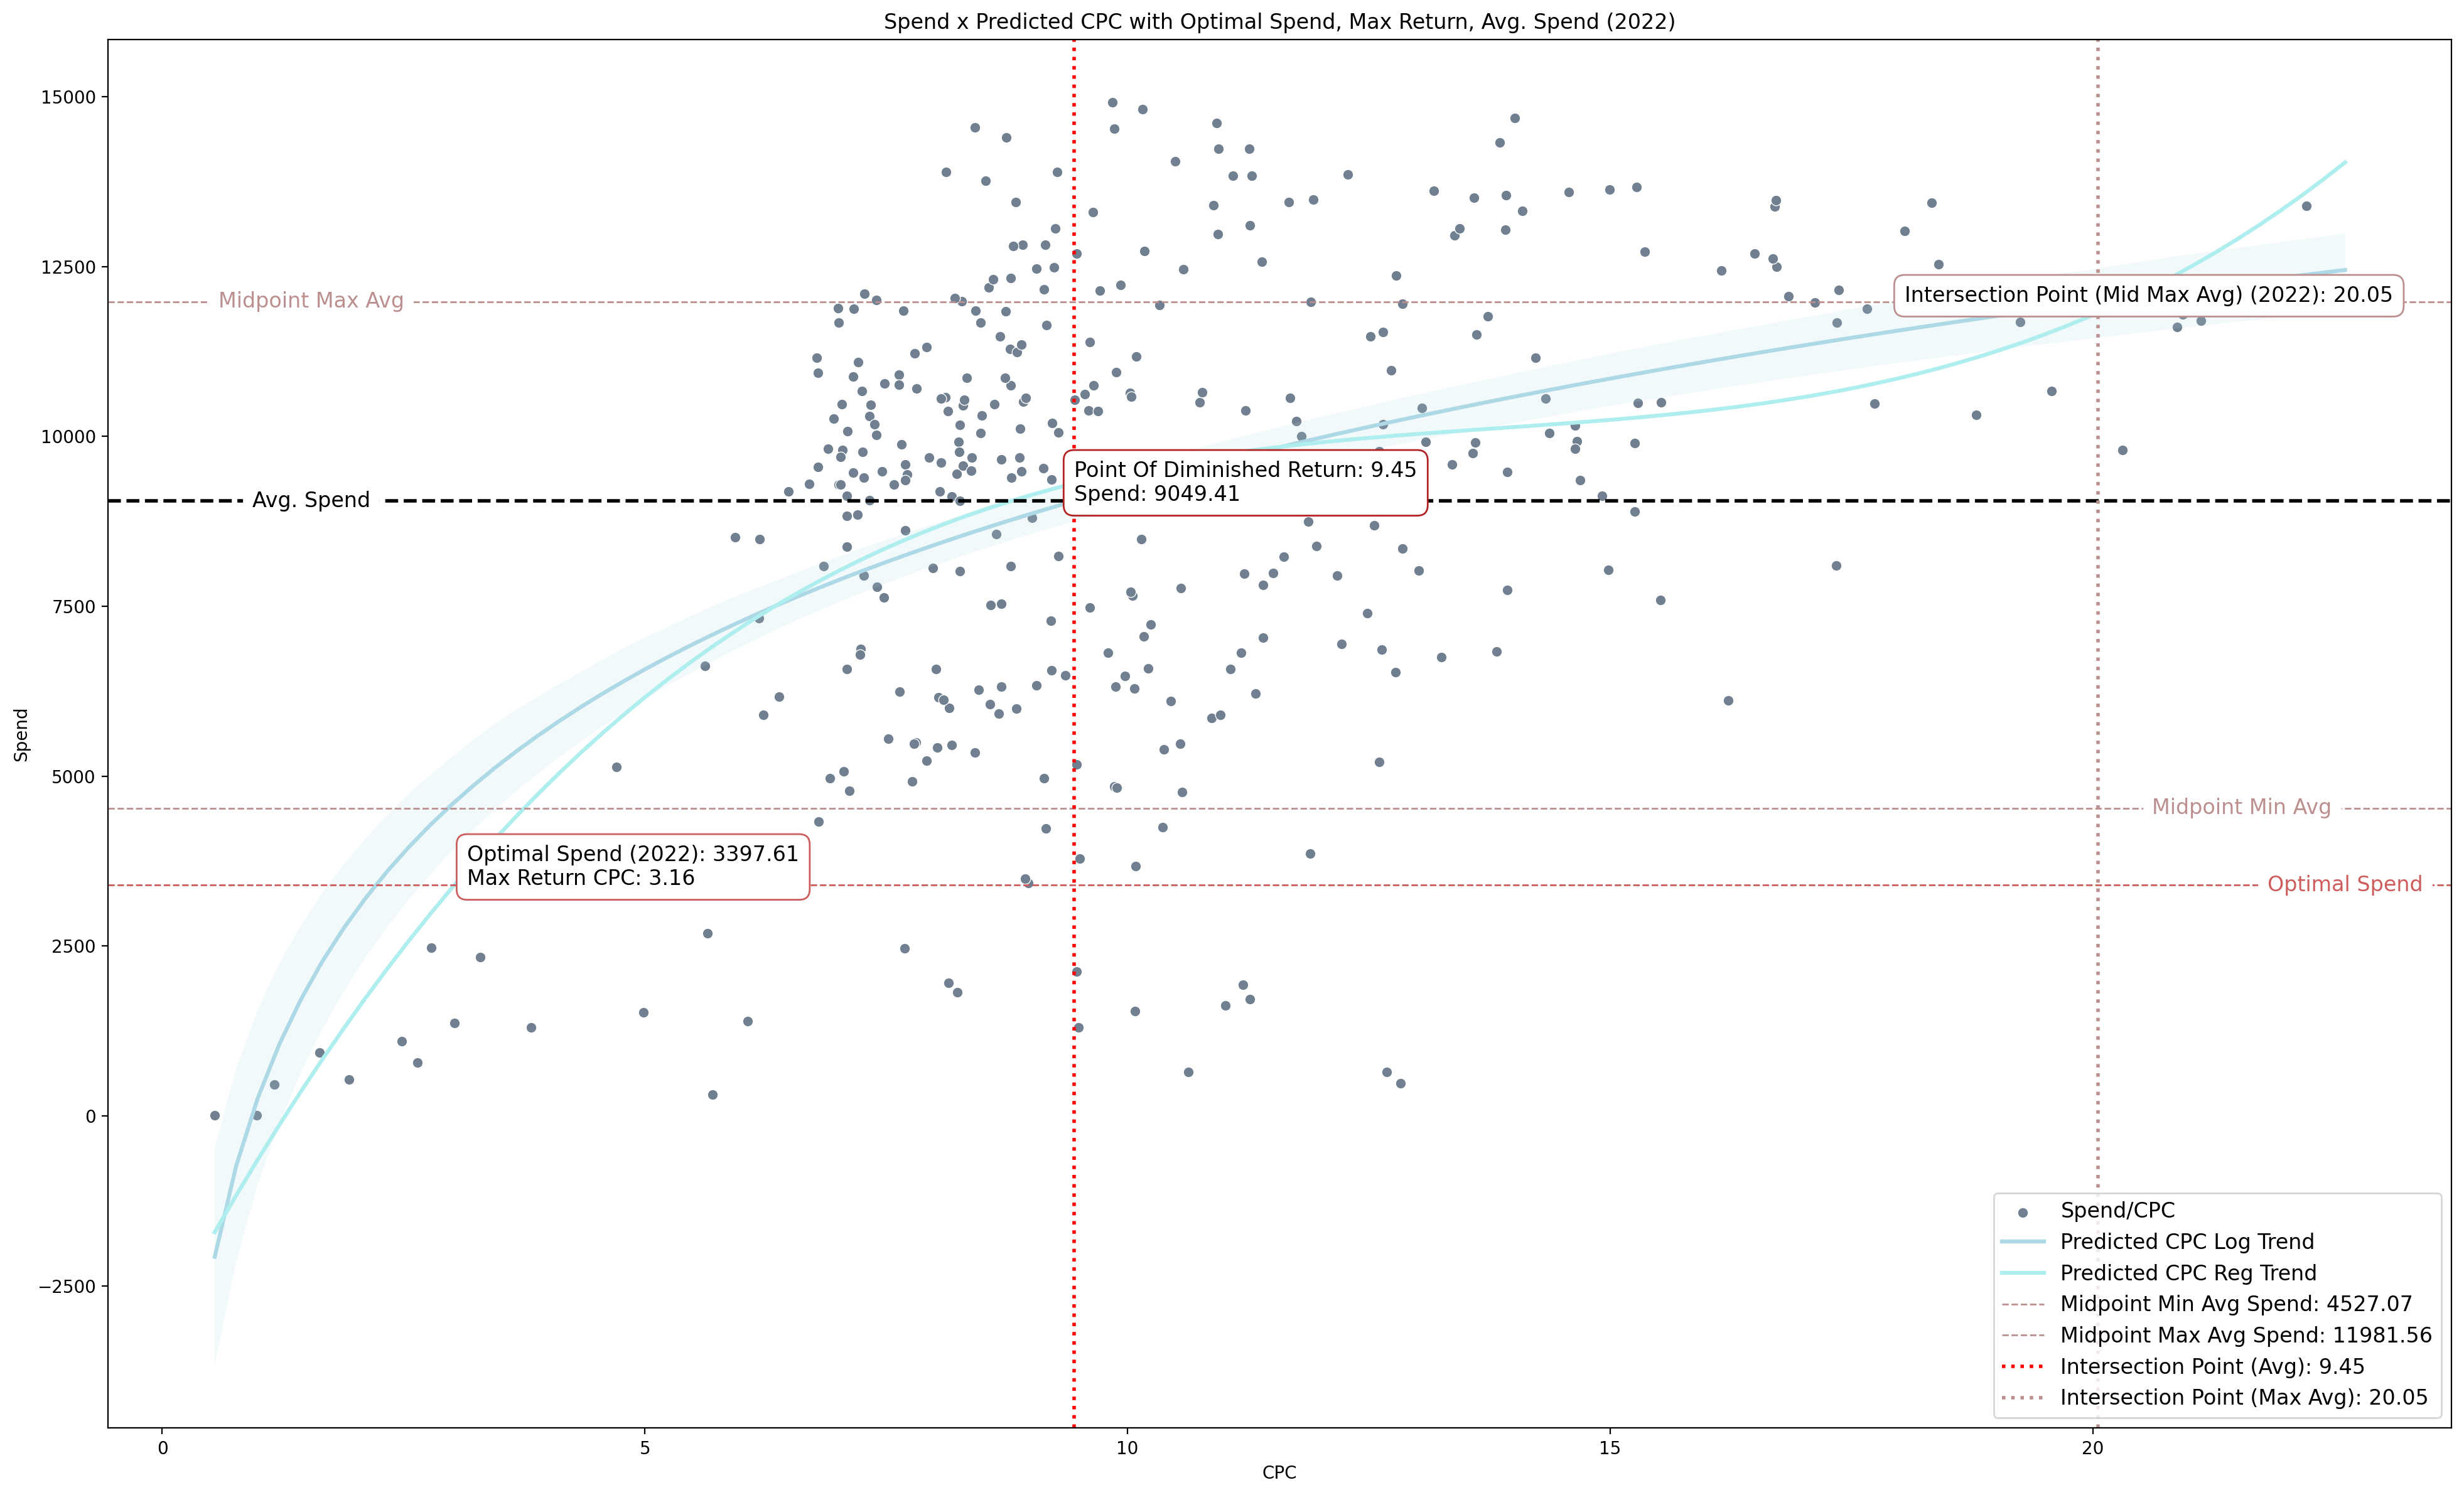

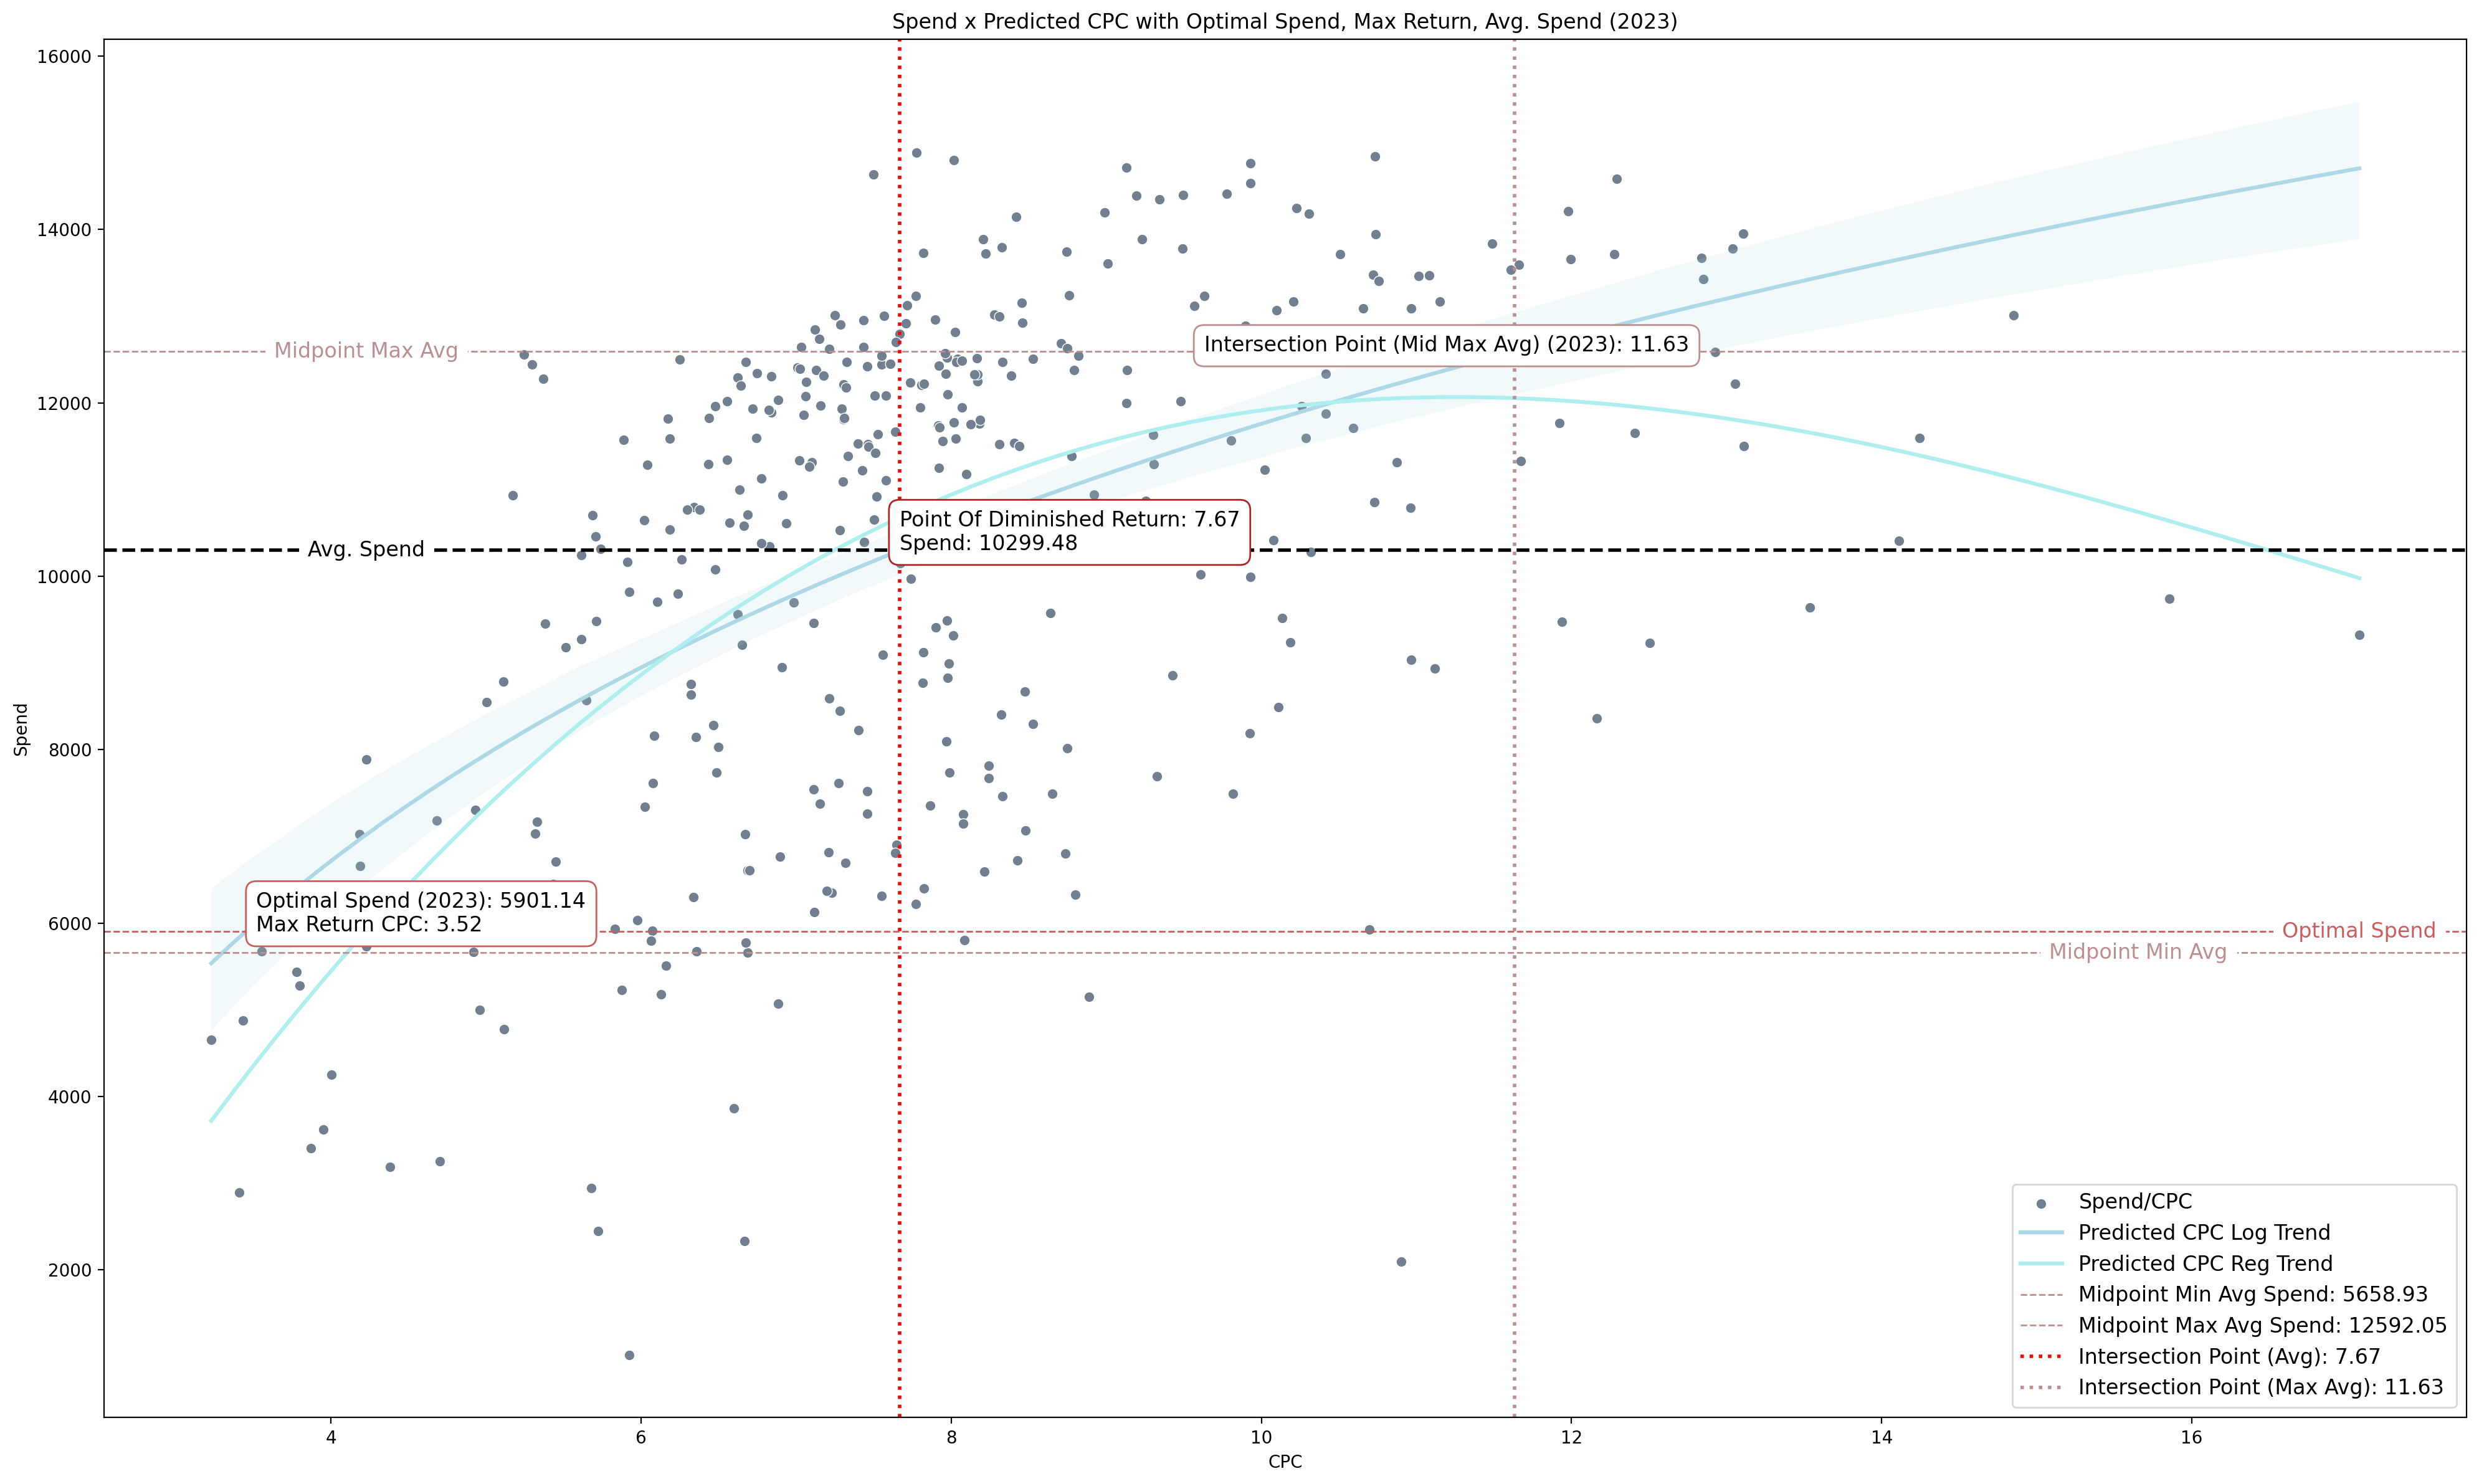

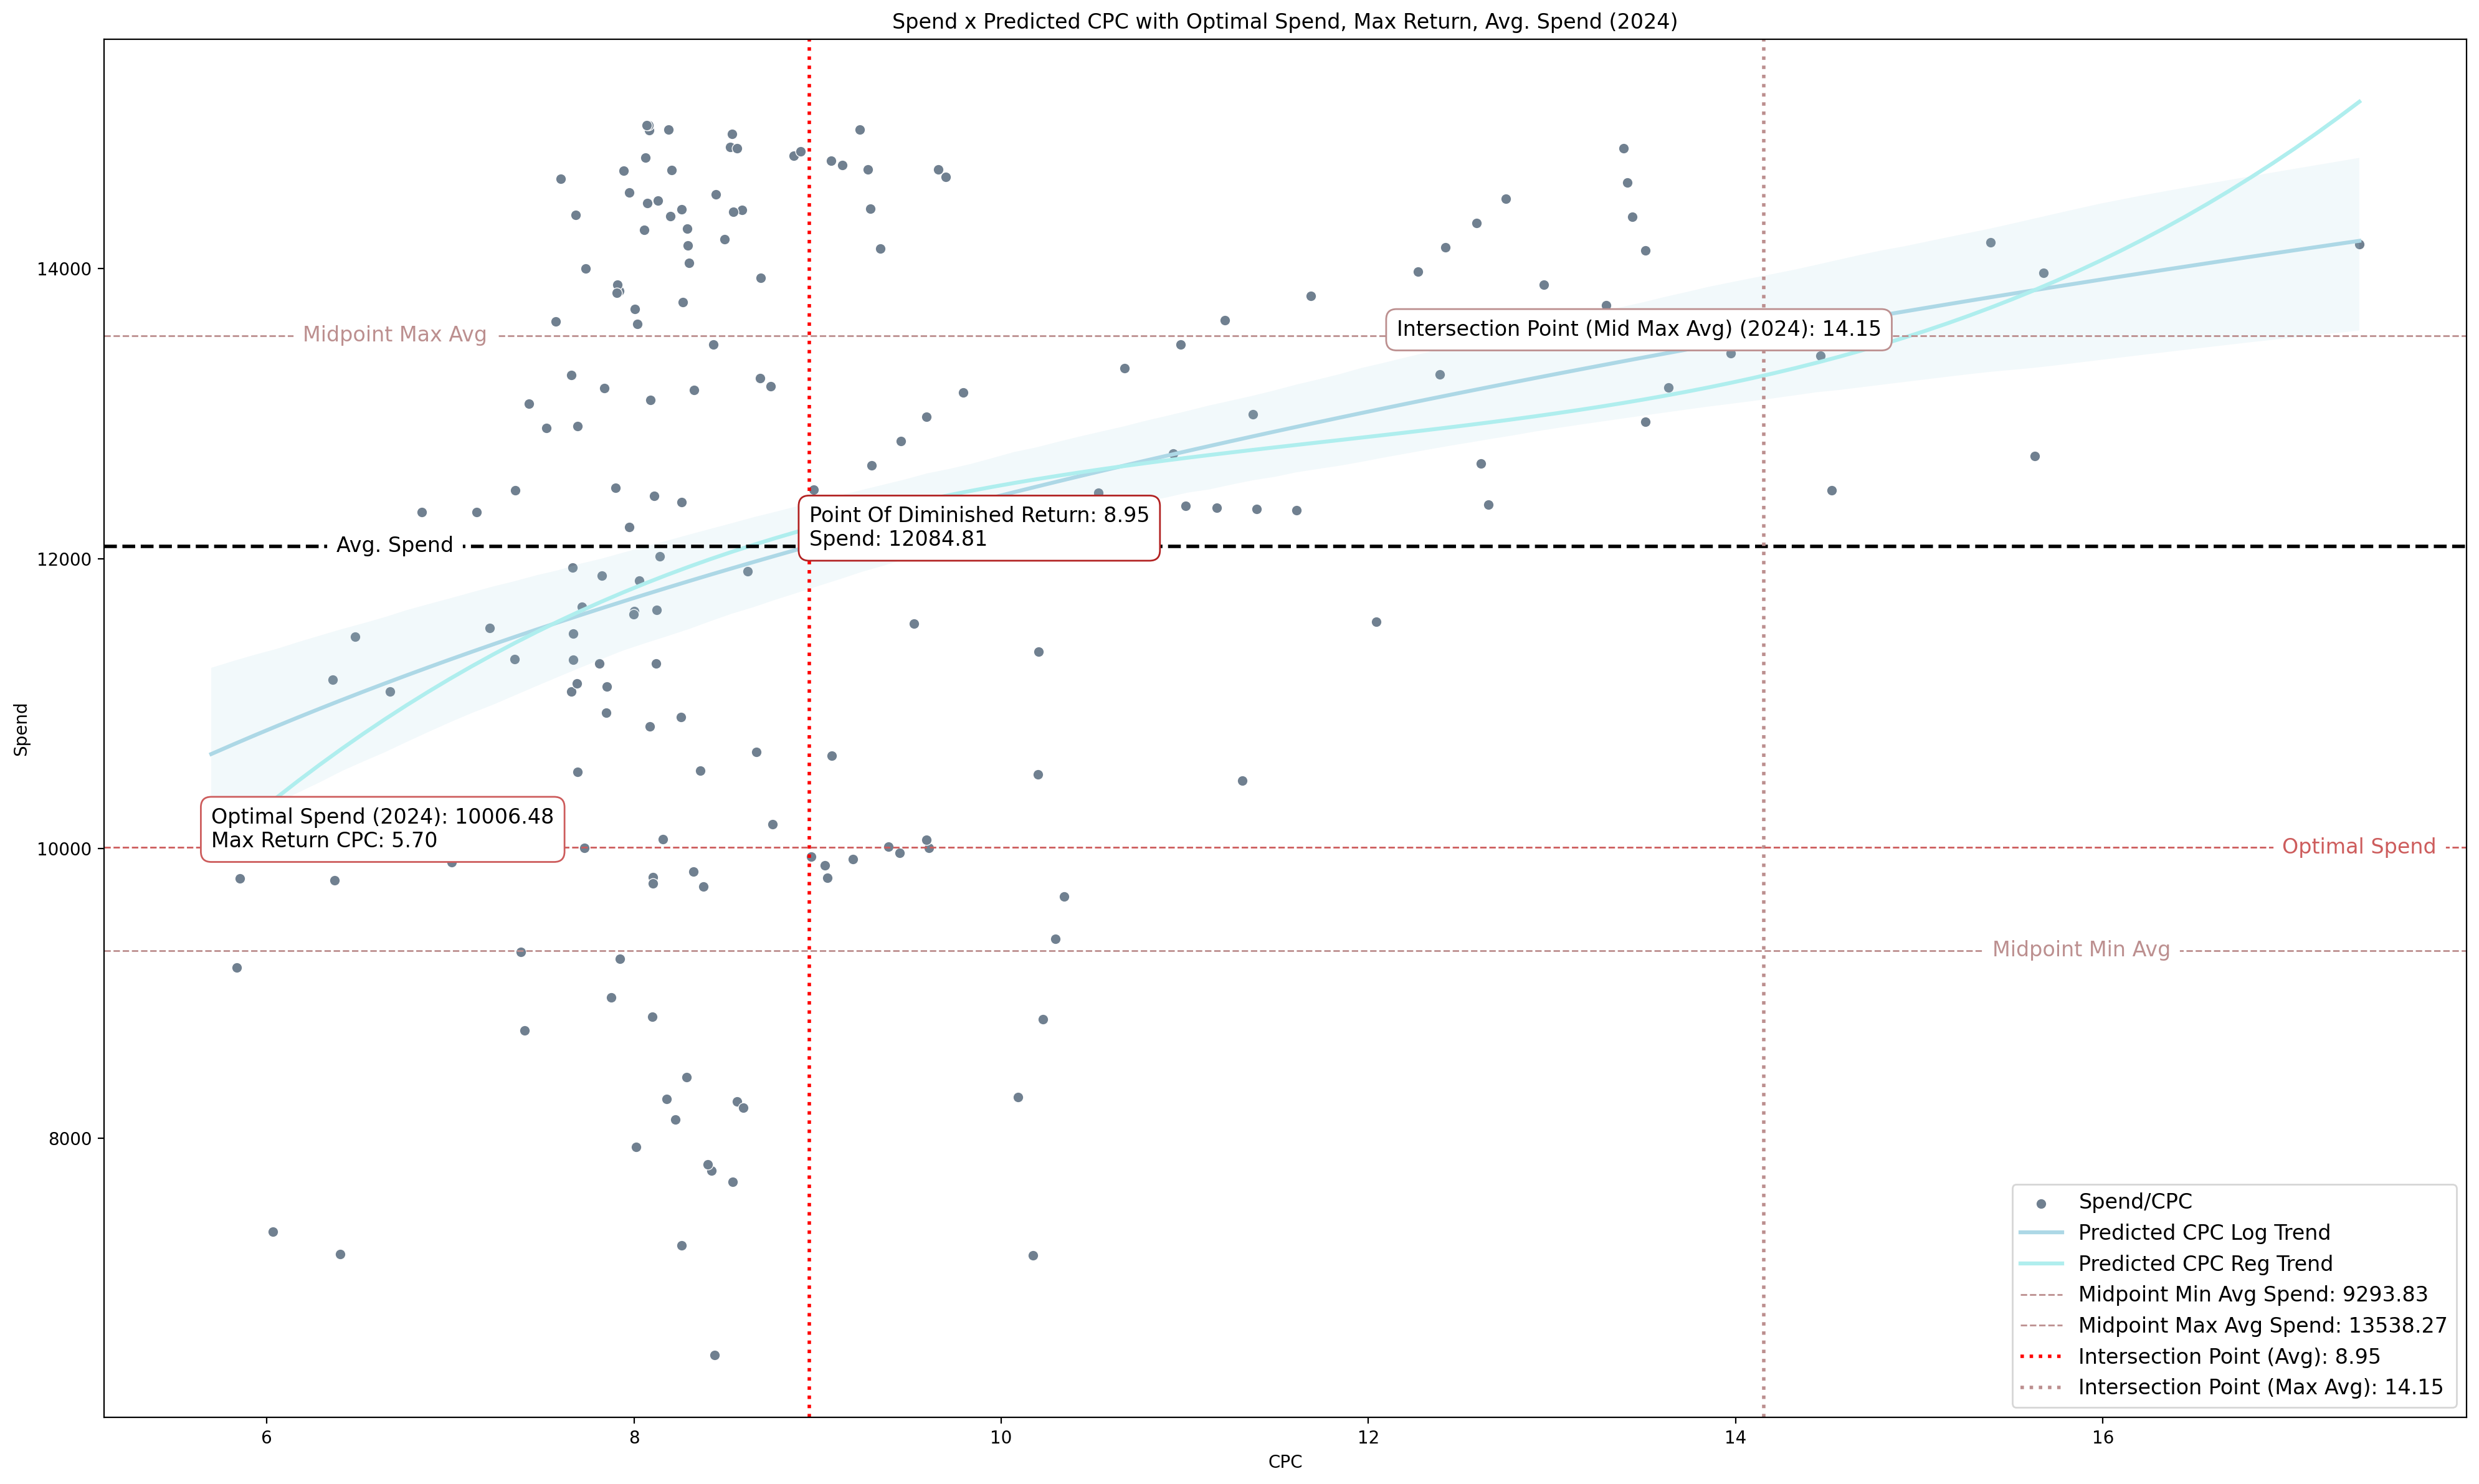

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Normalizing the data
actual_metrics_df3 = actual_metrics_df.copy()
actual_metrics_df4 = actual_metrics_df.copy()
scaler = MinMaxScaler()
actual_metrics_df3[['Normalized ROI Actual', 'Normalized Predicted CPC Actual', 'Normalized Spend Actual']] = scaler.fit_transform(actual_metrics_df3[['ROI Actual', 'Predicted CPC Actual', 'Spend Actual']])

# Smoothing the spend data
actual_metrics_df4['smoothed_spend'] = gaussian_filter1d(actual_metrics_df4['Spend Actual'], sigma=2)

# Plot per year
def plot_yearly_data3(df, year, roi_col, cpc_col, spend_col):
    # Filter year
    yearly_data = df[df.index.year == year]
    
    if yearly_data.empty:
        print(f"No data available for the year {year}.")
        return
    
    # Key levels
    max_roi_index = yearly_data[roi_col].idxmax()
    max_roi_value = yearly_data.loc[max_roi_index, roi_col]
    optimal_spend_value = yearly_data.loc[max_roi_index, spend_col]
    min_cpc_value = yearly_data.loc[max_roi_index, cpc_col]
    avg_spend = yearly_data[spend_col].mean()
    min_avg_spend = yearly_data[spend_col].min()
    max_avg_spend = yearly_data[spend_col].max()
    
    midpoint_min_avg = (avg_spend + min_avg_spend) / 2
    midpoint_max_avg = (avg_spend + max_avg_spend) / 2
    
    yearly_data['date_num'] = mdates.date2num(yearly_data.index.to_pydatetime())
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(data=yearly_data, x=cpc_col, y=spend_col, label='Spend/CPC', color='slategray')
    
    # Fit regression models
    reg1 = sns.regplot(x=cpc_col, y=spend_col, data=yearly_data, order=1, scatter=False, logx=True, label='Predicted CPC Log Trend', color='lightblue')
    reg2 = sns.regplot(x=cpc_col, y=spend_col, data=yearly_data, order=3, scatter=False, ci=None, label='Predicted CPC Reg Trend', color='paleturquoise')
    
    # Get the lines from the regplots
    line1 = reg1.get_lines()[0].get_xydata()
    line2 = reg2.get_lines()[0].get_xydata()
    
    # Intersection points from curves
    f_line1 = interp1d(line1[:, 0], line1[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    f_line2 = interp1d(line2[:, 0], line2[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    
    x_vals = np.linspace(yearly_data[cpc_col].min(), yearly_data[cpc_col].max(), 1000)
    y_vals_line1 = f_line1(x_vals)
    y_vals_line2 = f_line2(x_vals)
    
    intersection_x_avg = x_vals[np.argmin(np.abs(y_vals_line1 - avg_spend))]
    intersection_x_min_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_min_avg))]
    intersection_x_max_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_max_avg))]
    
    plt.axhline(y=avg_spend, color='black', linestyle='--', linewidth=2)
    plt.axhline(y=midpoint_min_avg, color='rosybrown', linestyle='--', label=f'Midpoint Min Avg Spend: {midpoint_min_avg:.2f}', linewidth=1)
    plt.axhline(y=midpoint_max_avg, color='rosybrown', linestyle='--', label=f'Midpoint Max Avg Spend: {midpoint_max_avg:.2f}', linewidth=1)
    
    plt.axvline(x=intersection_x_avg, color='red', linestyle=':', label=f'Intersection Point (Avg): {intersection_x_avg:.2f}', linewidth=2)
    #plt.axvline(x=intersection_x_min_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Min Avg): {intersection_x_min_avg:.2f}', linewidth=2)
    plt.axvline(x=intersection_x_max_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Max Avg): {intersection_x_max_avg:.2f}', linewidth=2)
    
    plt.annotate(f'Optimal Spend ({year}): {optimal_spend_value:.2f}\nMax Return CPC: {min_cpc_value:.2f}', 
                 xy=(min_cpc_value, optimal_spend_value), xytext=(min_cpc_value, optimal_spend_value + 1.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='indianred'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='indianred', facecolor='white'), fontsize=12)

    #plt.annotate(f'Max Return CPC ({year}): {min_cpc_value:.2f}', 
    #             xy=(min_cpc_value, max_roi_value), xytext=(min_cpc_value, max_roi_value + 1.0),
    #             textcoords='data', arrowprops=dict(arrowstyle="->", color='gray'), 
    #             bbox=dict(boxstyle="round,pad=0.5", edgecolor='gray', facecolor='white'), fontsize=12)
    
    #plt.annotate(f'Avg. Spend ({year}): {avg_spend:.2f}', 
    #             xy=(yearly_data[cpc_col].max(), avg_spend), xytext=(yearly_data[cpc_col].max() - 3.8, avg_spend - 5.5),
    #             textcoords='data', #arrowprops=dict(arrowstyle="->", color='black'), 
    #             bbox=dict(boxstyle="round,pad=1.0", edgecolor='white', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Point Of Diminished Return: {intersection_x_avg:.2f}\nSpend: {avg_spend:.2f}', 
                 xy=(intersection_x_avg, avg_spend), xytext=(intersection_x_avg, avg_spend + 2.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='firebrick'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='firebrick', facecolor='white'), fontsize=12)
    
    #plt.annotate(f'Intersection Point (Mid Min Avg) ({year}): {intersection_x_min_avg:.2f}', 
    #             xy=(intersection_x_min_avg, midpoint_min_avg), xytext=(intersection_x_min_avg + 0.1, midpoint_min_avg - 0.5),
    #             textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
    #             bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Intersection Point (Mid Max Avg) ({year}): {intersection_x_max_avg:.2f}', 
                 xy=(intersection_x_max_avg, midpoint_max_avg), xytext=(intersection_x_max_avg - 2.0, midpoint_max_avg),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    plt.axhline(y=optimal_spend_value, color='indianred', linestyle='--', label=None, linewidth=1)
    #plt.axhline(y=max_roi_value, color='gray', linestyle='--', label=None, linewidth=1)
    plt.text(yearly_data[cpc_col].max(), optimal_spend_value, 'Optimal Spend', color='indianred', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(yearly_data[cpc_col].max() - 2, midpoint_min_avg, 'Midpoint Min Avg', color='rosybrown', va='center', ha='left', backgroundcolor='white', fontsize=12)
    plt.text(yearly_data[cpc_col].min() + 1, midpoint_max_avg, 'Midpoint Max Avg', color='rosybrown', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(yearly_data[cpc_col].min() + 1, avg_spend, 'Avg. Spend', color='black', va='center', ha='center', backgroundcolor='white', fontsize=12)
    
    plt.xlabel('CPC')
    plt.ylabel('Spend')
    plt.title(f'Spend x Predicted CPC with Optimal Spend, Max Return, Avg. Spend ({year})')
    
    # Manage legend entries explicitly
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Remove unwanted labels
    by_label.pop('Max Return', None)
    by_label.pop('Optimal Spend', None)
    plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='lower right')
    
    # Set limits to remove padding
    #plt.xlim(left=yearly_data[cpc_col].min() - 1)  # Set xlim left to 1 less than the minimum CPC value for the year
    #plt.ylim(bottom=yearly_data[spend_col].min() - 1000)  # Adjust as needed, e.g., plt.ylim(bottom=0, top=some_value)
    
    plt.tight_layout()
    
    plt.show()

# Plot
for year in [2022, 2023, 2024]:
    plot_yearly_data3(actual_metrics_df4, year, "ROI Actual", "Predicted CPC Actual", "Spend Actual")


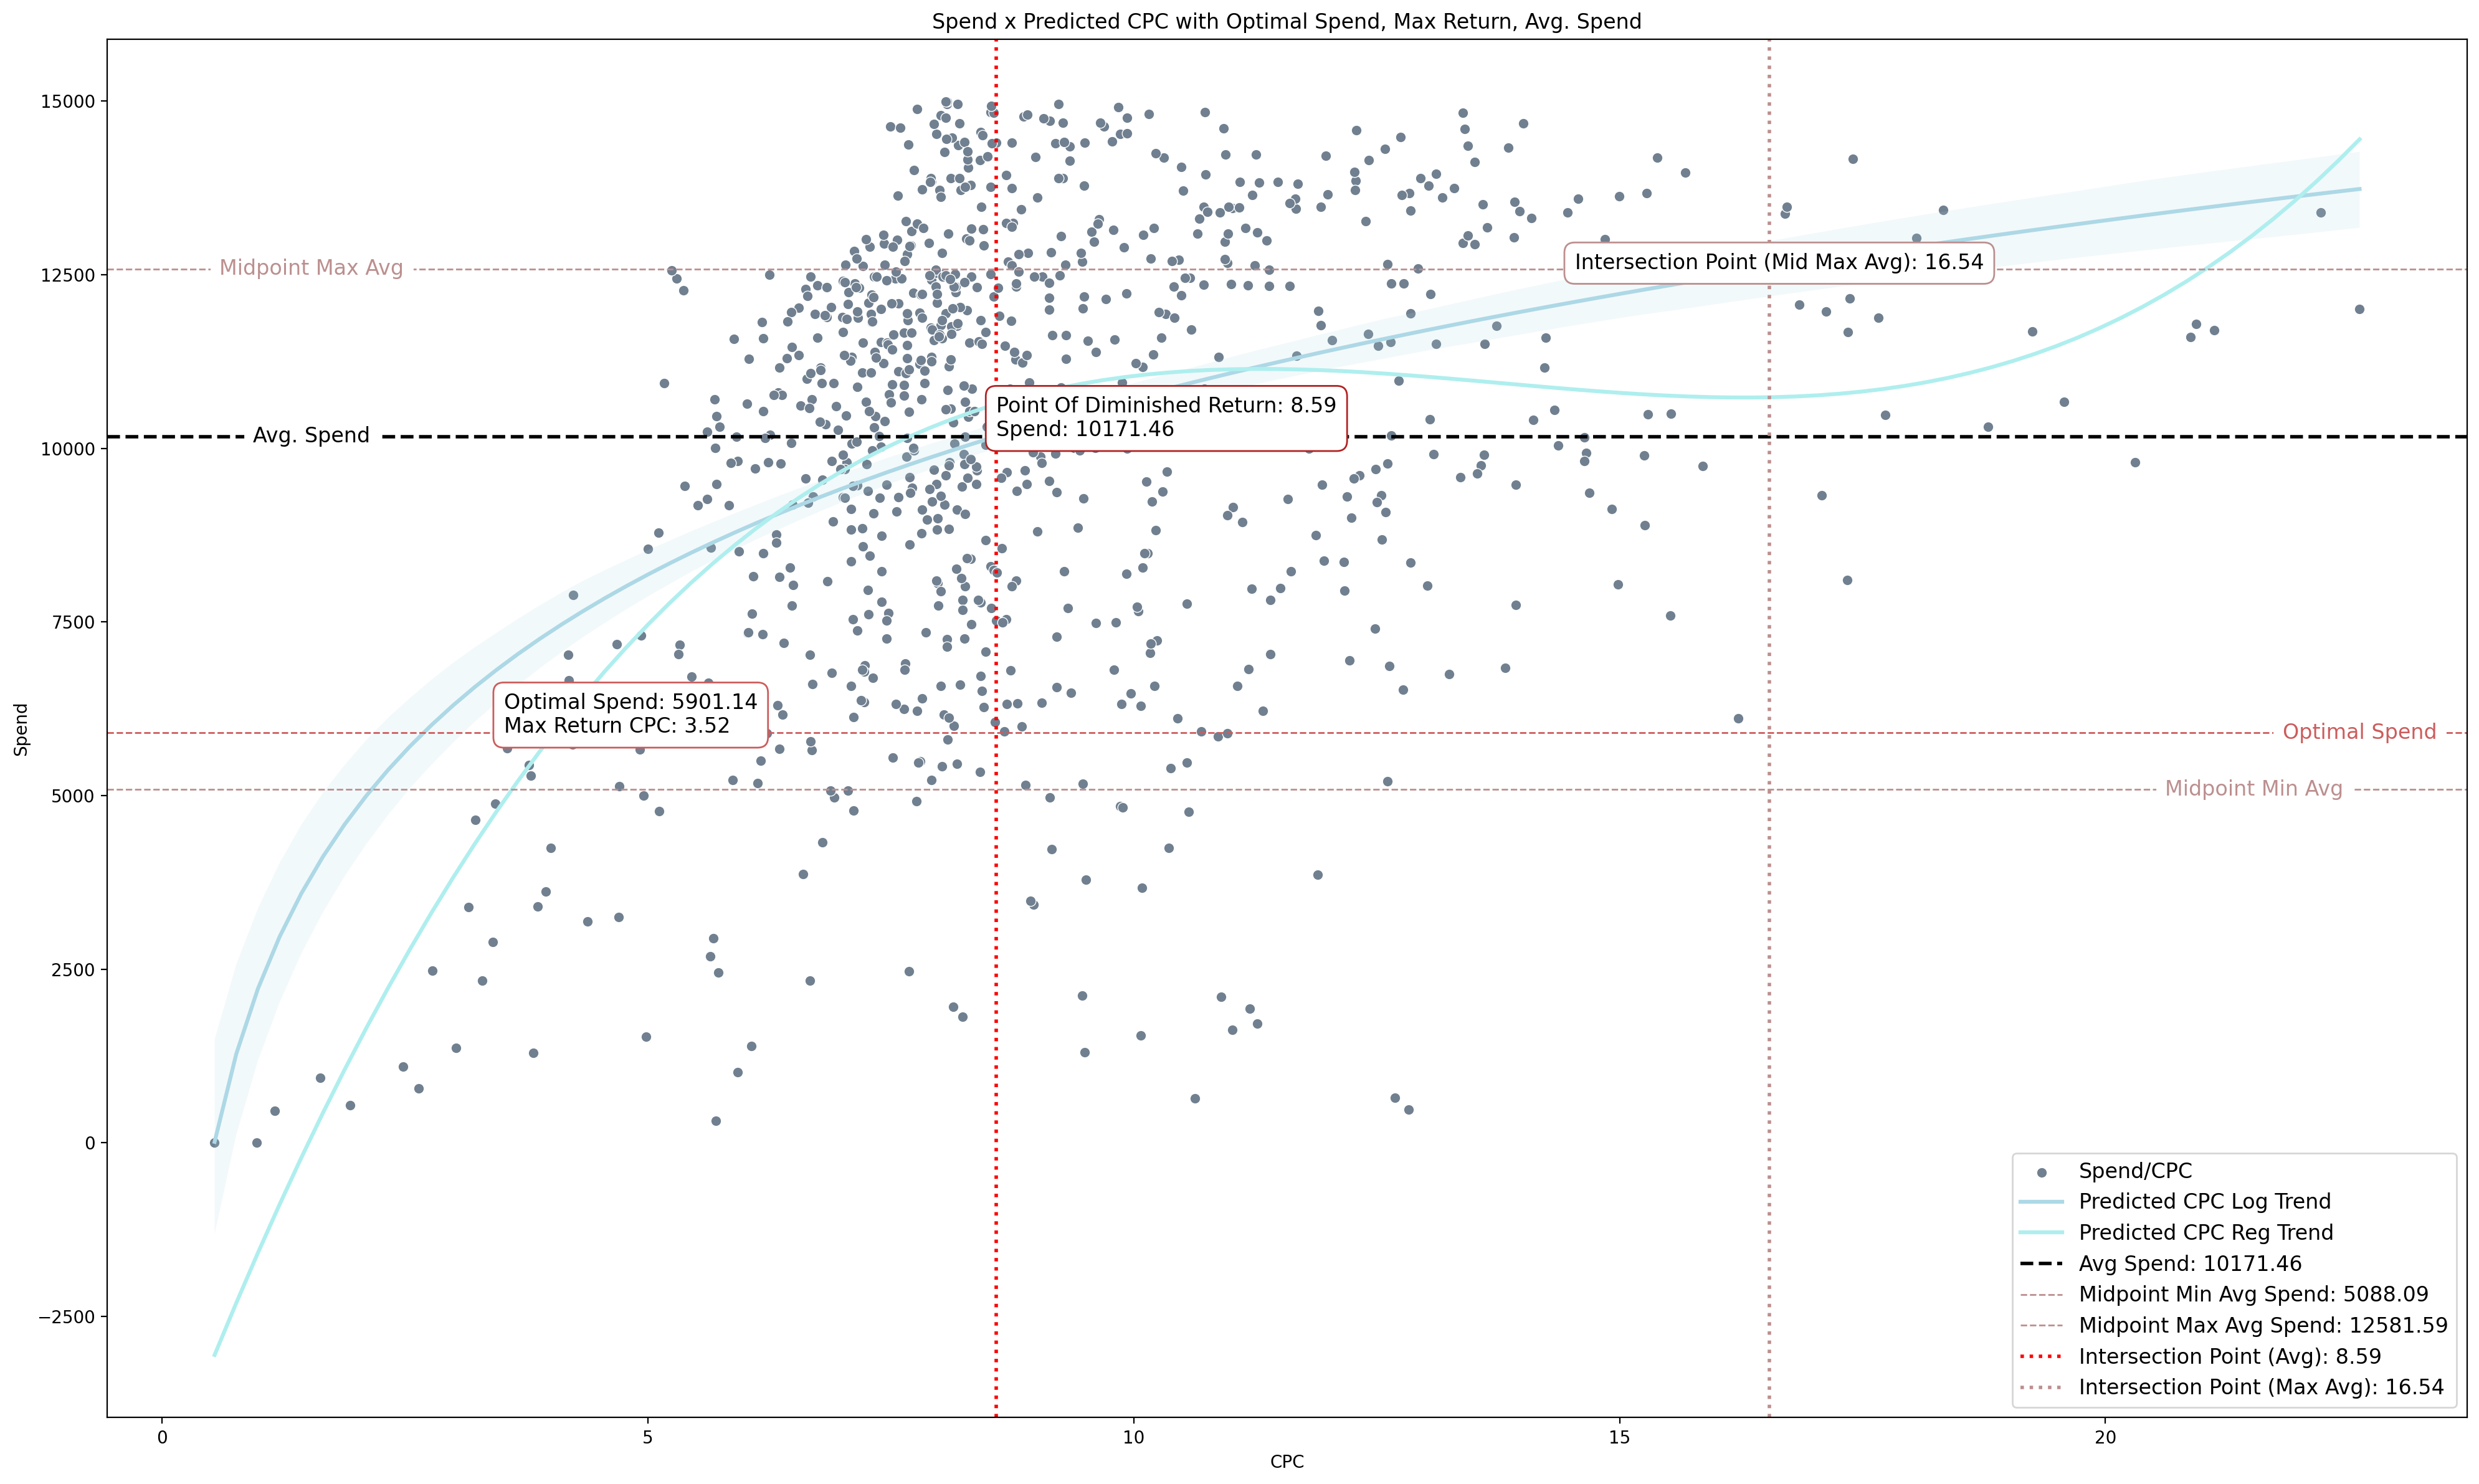

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Normalizing the data
actual_metrics_df3 = actual_metrics_df.copy()
actual_metrics_df4 = actual_metrics_df.copy()
scaler = MinMaxScaler()
actual_metrics_df3[['Normalized ROI Actual', 'Normalized Predicted CPC Actual', 'Normalized Spend Actual']] = scaler.fit_transform(actual_metrics_df3[['ROI Actual', 'Predicted CPC Actual', 'Spend Actual']])

# Smoothing the spend data
actual_metrics_df4['smoothed_spend'] = gaussian_filter1d(actual_metrics_df4['Spend Actual'], sigma=2)

# Plot overall data
def plot_yearly_data3_overall(df, roi_col, cpc_col, spend_col):
    # Check if the dataframe is empty
    if df.empty:
        print(f"No data available.")
        return
    
    # Key levels
    max_roi_index = df[roi_col].idxmax()
    max_roi_value = df.loc[max_roi_index, roi_col]
    optimal_spend_value = df.loc[max_roi_index, spend_col]
    min_cpc_value = df.loc[max_roi_index, cpc_col]
    avg_spend = df[spend_col].mean()
    min_avg_spend = df[spend_col].min()
    max_avg_spend = df[spend_col].max()
    
    midpoint_min_avg = (avg_spend + min_avg_spend) / 2
    midpoint_max_avg = (avg_spend + max_avg_spend) / 2
    
    df['date_num'] = mdates.date2num(df.index.to_pydatetime())
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(data=df, x=cpc_col, y=spend_col, label='Spend/CPC', color='slategray')
    
    # Fit regression models
    reg1 = sns.regplot(x=cpc_col, y=spend_col, data=df, order=1, scatter=False, logx=True, label='Predicted CPC Log Trend', color='lightblue')
    reg2 = sns.regplot(x=cpc_col, y=spend_col, data=df, order=3, scatter=False, ci=None, label='Predicted CPC Reg Trend', color='paleturquoise')
    
    # Get the lines from the regplots
    line1 = reg1.get_lines()[0].get_xydata()
    line2 = reg2.get_lines()[0].get_xydata()
    
    # Intersection points from curves
    f_line1 = interp1d(line1[:, 0], line1[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    f_line2 = interp1d(line2[:, 0], line2[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    
    x_vals = np.linspace(df[cpc_col].min(), df[cpc_col].max(), 1000)
    y_vals_line1 = f_line1(x_vals)
    y_vals_line2 = f_line2(x_vals)
    
    intersection_x_avg = x_vals[np.argmin(np.abs(y_vals_line1 - avg_spend))]
    intersection_x_min_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_min_avg))]
    intersection_x_max_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_max_avg))]
    
    plt.axhline(y=avg_spend, color='black', linestyle='--', label=f'Avg Spend: {avg_spend:.2f}', linewidth=2)
    plt.axhline(y=midpoint_min_avg, color='rosybrown', linestyle='--', label=f'Midpoint Min Avg Spend: {midpoint_min_avg:.2f}', linewidth=1)
    plt.axhline(y=midpoint_max_avg, color='rosybrown', linestyle='--', label=f'Midpoint Max Avg Spend: {midpoint_max_avg:.2f}', linewidth=1)
    
    plt.axvline(x=intersection_x_avg, color='red', linestyle=':', label=f'Intersection Point (Avg): {intersection_x_avg:.2f}', linewidth=2)
    plt.axvline(x=intersection_x_max_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Max Avg): {intersection_x_max_avg:.2f}', linewidth=2)
    
    plt.annotate(f'Optimal Spend: {optimal_spend_value:.2f}\nMax Return CPC: {min_cpc_value:.2f}', 
                 xy=(min_cpc_value, optimal_spend_value), xytext=(min_cpc_value, optimal_spend_value + 1.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='indianred'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='indianred', facecolor='white'), fontsize=12)
    
    #plt.annotate(f'Avg. Spend: {avg_spend:.2f}', 
    #             xy=(df[cpc_col].max(), avg_spend), xytext=(df[cpc_col].max() - 3.8, avg_spend - 5.5),
    #             textcoords='data', bbox=dict(boxstyle="round,pad=1.0", edgecolor='white', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Point Of Diminished Return: {intersection_x_avg:.2f}\nSpend: {avg_spend:.2f}', 
                 xy=(intersection_x_avg, avg_spend), xytext=(intersection_x_avg, avg_spend + 2.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='firebrick'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='firebrick', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Intersection Point (Mid Max Avg): {intersection_x_max_avg:.2f}', 
                 xy=(intersection_x_max_avg, midpoint_max_avg), xytext=(intersection_x_max_avg - 2.0, midpoint_max_avg),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    
    plt.axhline(y=optimal_spend_value, color='indianred', linestyle='--', label=None, linewidth=1)
    plt.text(df[cpc_col].max(), optimal_spend_value, 'Optimal Spend', color='indianred', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(df[cpc_col].max() - 2, midpoint_min_avg, 'Midpoint Min Avg', color='rosybrown', va='center', ha='left', backgroundcolor='white', fontsize=12)
    plt.text(df[cpc_col].min() + 1, midpoint_max_avg, 'Midpoint Max Avg', color='rosybrown', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(df[cpc_col].min() + 1, avg_spend, 'Avg. Spend', color='black', va='center', ha='center', backgroundcolor='white', fontsize=12)
    
    plt.xlabel('CPC')
    plt.ylabel('Spend')
    plt.title(f'Spend x Predicted CPC with Optimal Spend, Max Return, Avg. Spend')
    
    # Manage legend entries explicitly
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Remove unwanted labels
    by_label.pop('Max Return', None)
    by_label.pop('Optimal Spend', None)
    plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='lower right')
    
    # Set limits to remove padding
    #plt.xlim(left=df[cpc_col].min() - 1)  # Set xlim left to 1 less than the minimum CPC value
    #plt.ylim(bottom=0)  # Adjust as needed, e.g., plt.ylim(bottom=0, top=some_value)
    
    plt.tight_layout()
    
    plt.show()

# Plot
plot_yearly_data3_overall(actual_metrics_df4, "ROI Actual", "Predicted CPC Actual", "Spend Actual")


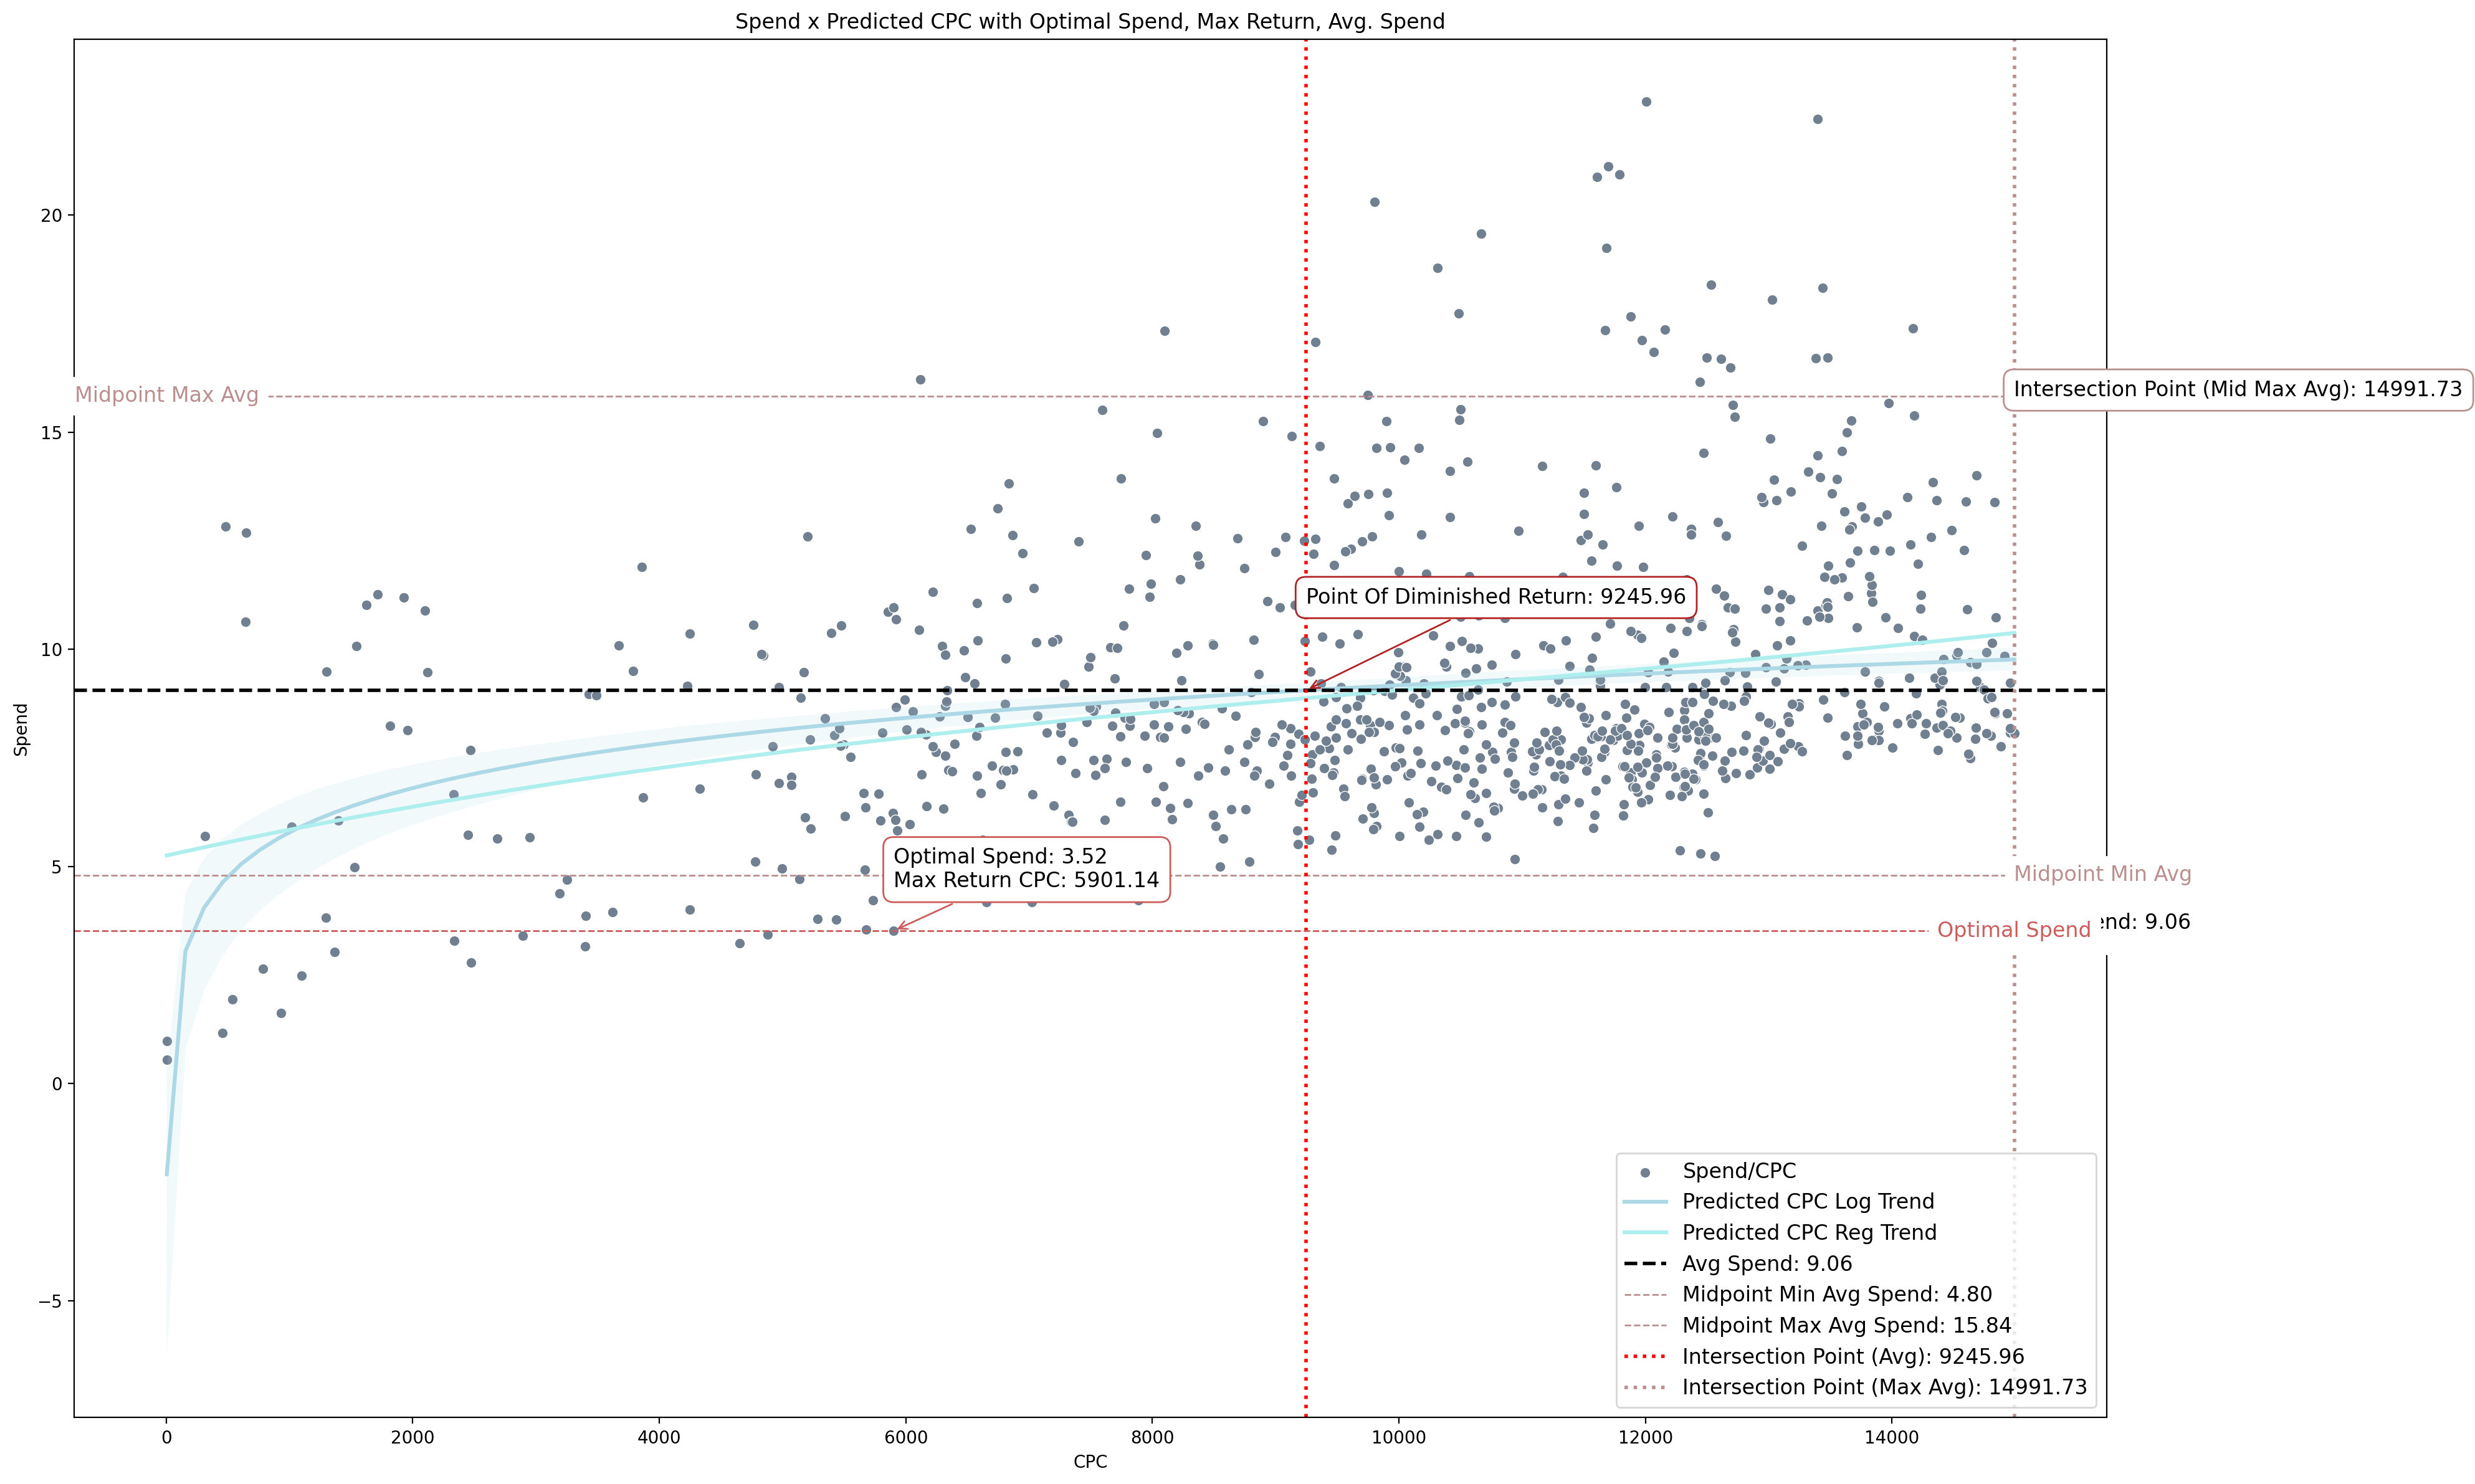

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Normalizing the data
actual_metrics_df3 = actual_metrics_df.copy()
actual_metrics_df4 = actual_metrics_df.copy()
scaler = MinMaxScaler()
actual_metrics_df3[['Normalized ROI Actual', 'Normalized Predicted CPC Actual', 'Normalized Spend Actual']] = scaler.fit_transform(actual_metrics_df3[['ROI Actual', 'Predicted CPC Actual', 'Spend Actual']])

# Smoothing the spend data
actual_metrics_df4['smoothed_spend'] = gaussian_filter1d(actual_metrics_df4['Spend Actual'], sigma=2)

# Plot overall data
def plot_yearly_data3_overall(df, roi_col, cpc_col, spend_col):
    # Check if the dataframe is empty
    if df.empty:
        print(f"No data available.")
        return
    
    # Key levels
    max_roi_index = df[roi_col].idxmax()
    max_roi_value = df.loc[max_roi_index, roi_col]
    optimal_spend_value = df.loc[max_roi_index, spend_col]
    min_cpc_value = df.loc[max_roi_index, cpc_col]
    avg_spend = df[spend_col].mean()
    min_avg_spend = df[spend_col].min()
    max_avg_spend = df[spend_col].max()
    
    midpoint_min_avg = (avg_spend + min_avg_spend) / 2
    midpoint_max_avg = (avg_spend + max_avg_spend) / 2
    
    df['date_num'] = mdates.date2num(df.index.to_pydatetime())
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(data=df, x=cpc_col, y=spend_col, label='Spend/CPC', color='slategray')
    
    # Fit regression models
    reg1 = sns.regplot(x=cpc_col, y=spend_col, data=df, order=1, scatter=False, logx=True, label='Predicted CPC Log Trend', color='lightblue')
    reg2 = sns.regplot(x=cpc_col, y=spend_col, data=df, order=3, scatter=False, ci=None, label='Predicted CPC Reg Trend', color='paleturquoise')
    
    # Get the lines from the regplots
    line1 = reg1.get_lines()[0].get_xydata()
    line2 = reg2.get_lines()[0].get_xydata()
    
    # Intersection points from curves
    f_line1 = interp1d(line1[:, 0], line1[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    f_line2 = interp1d(line2[:, 0], line2[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    
    x_vals = np.linspace(df[cpc_col].min(), df[cpc_col].max(), 1000)
    y_vals_line1 = f_line1(x_vals)
    y_vals_line2 = f_line2(x_vals)
    
    intersection_x_avg = x_vals[np.argmin(np.abs(y_vals_line1 - avg_spend))]
    intersection_x_min_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_min_avg))]
    intersection_x_max_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_max_avg))]
    
    plt.axhline(y=avg_spend, color='black', linestyle='--', label=f'Avg Spend: {avg_spend:.2f}', linewidth=2)
    plt.axhline(y=midpoint_min_avg, color='rosybrown', linestyle='--', label=f'Midpoint Min Avg Spend: {midpoint_min_avg:.2f}', linewidth=1)
    plt.axhline(y=midpoint_max_avg, color='rosybrown', linestyle='--', label=f'Midpoint Max Avg Spend: {midpoint_max_avg:.2f}', linewidth=1)
    
    plt.axvline(x=intersection_x_avg, color='red', linestyle=':', label=f'Intersection Point (Avg): {intersection_x_avg:.2f}', linewidth=2)
    plt.axvline(x=intersection_x_max_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Max Avg): {intersection_x_max_avg:.2f}', linewidth=2)
    
    plt.annotate(f'Optimal Spend: {optimal_spend_value:.2f}\nMax Return CPC: {min_cpc_value:.2f}', 
                 xy=(min_cpc_value, optimal_spend_value), xytext=(min_cpc_value, optimal_spend_value + 1.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='indianred'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='indianred', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Avg. Spend: {avg_spend:.2f}', 
                 xy=(df[cpc_col].max(), avg_spend), xytext=(df[cpc_col].max() - 3.8, avg_spend - 5.5),
                 textcoords='data', bbox=dict(boxstyle="round,pad=1.0", edgecolor='white', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Point Of Diminished Return: {intersection_x_avg:.2f}', 
                 xy=(intersection_x_avg, avg_spend), xytext=(intersection_x_avg, avg_spend + 2.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='firebrick'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='firebrick', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Intersection Point (Mid Max Avg): {intersection_x_max_avg:.2f}', 
                 xy=(intersection_x_max_avg, midpoint_max_avg), xytext=(intersection_x_max_avg - 2.0, midpoint_max_avg),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    
    plt.axhline(y=optimal_spend_value, color='indianred', linestyle='--', label=None, linewidth=1)
    plt.text(df[cpc_col].max(), optimal_spend_value, 'Optimal Spend', color='indianred', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(df[cpc_col].max() - 2, midpoint_min_avg, 'Midpoint Min Avg', color='rosybrown', va='center', ha='left', backgroundcolor='white', fontsize=12)
    plt.text(df[cpc_col].min() + 1, midpoint_max_avg, 'Midpoint Max Avg', color='rosybrown', va='center', ha='center', backgroundcolor='white', fontsize=12)
    
    plt.xlabel('CPC')
    plt.ylabel('Spend')
    plt.title(f'Spend x Predicted CPC with Optimal Spend, Max Return, Avg. Spend')
    
    # Manage legend entries explicitly
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Remove unwanted labels
    by_label.pop('Max Return', None)
    by_label.pop('Optimal Spend', None)
    plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='lower right')
    
    # Set limits to remove padding
    #plt.xlim(left=df[cpc_col].min() - 1)  # Set xlim left to 1 less than the minimum CPC value
    #plt.ylim(bottom=0)  # Adjust as needed, e.g., plt.ylim(bottom=0, top=some_value)
    
    plt.tight_layout()
    
    plt.show()

# Plot
plot_yearly_data3_overall(actual_metrics_df4, "ROI Actual", "Spend Actual", "Predicted CPC Actual")


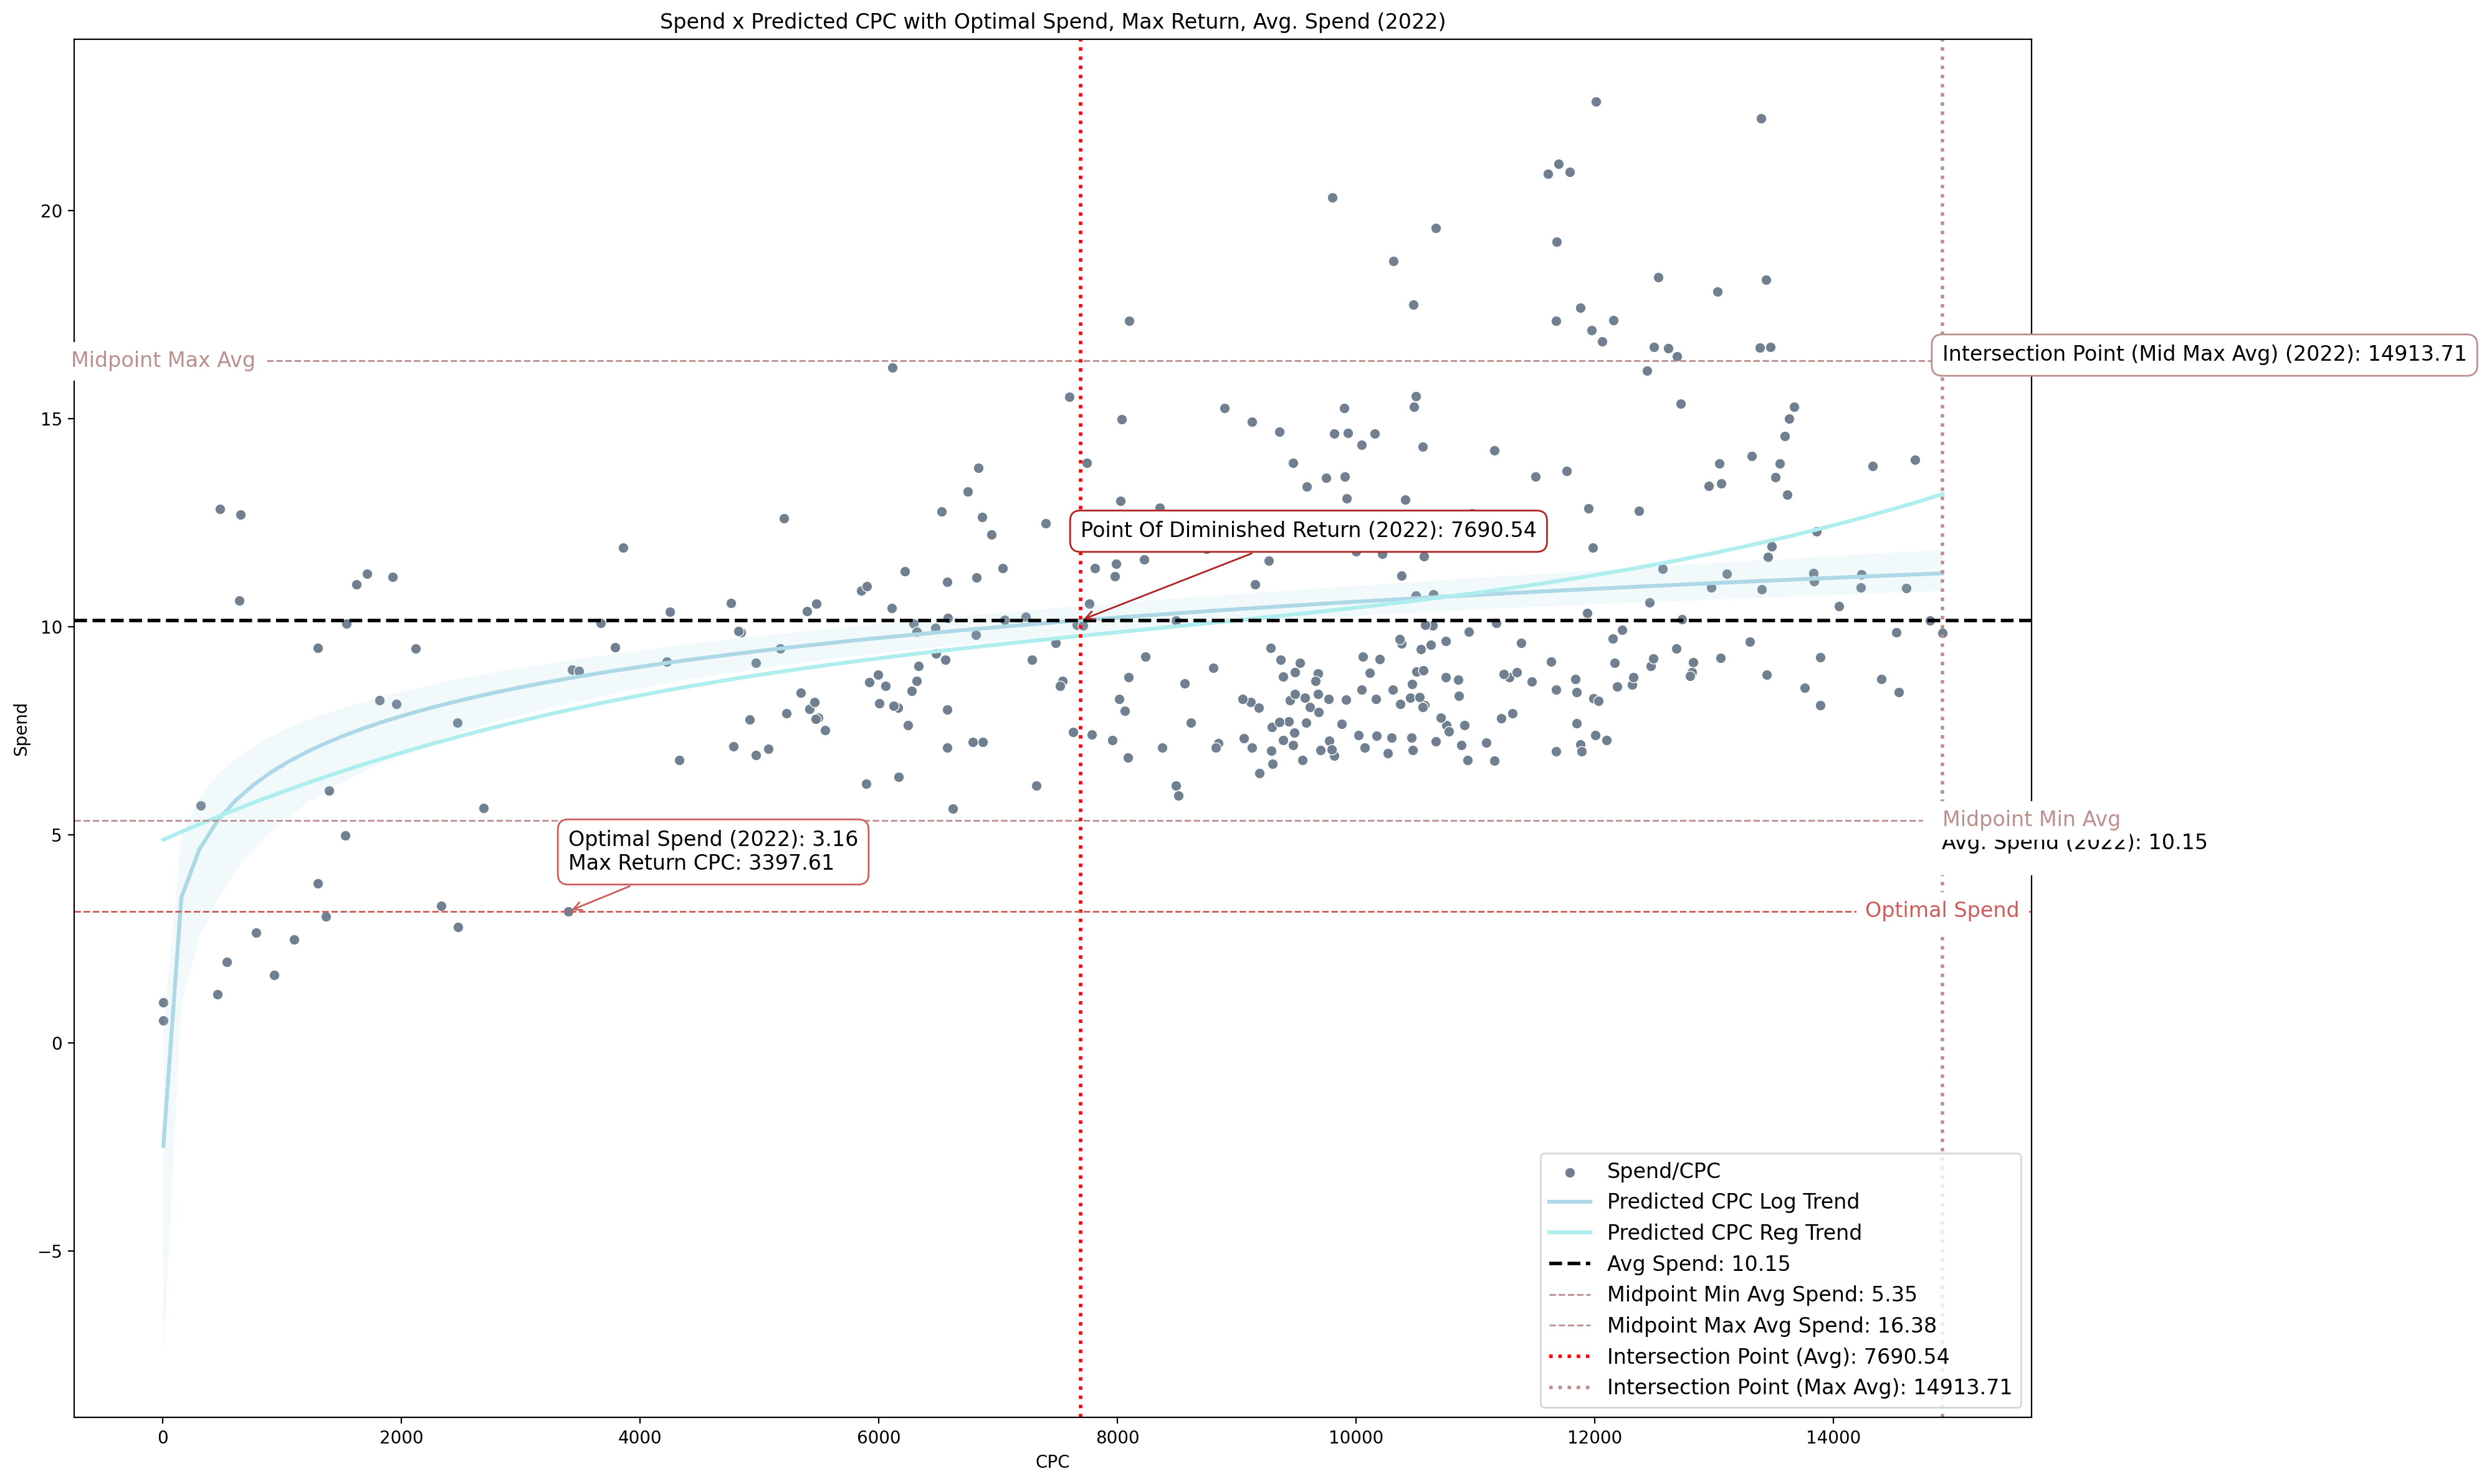

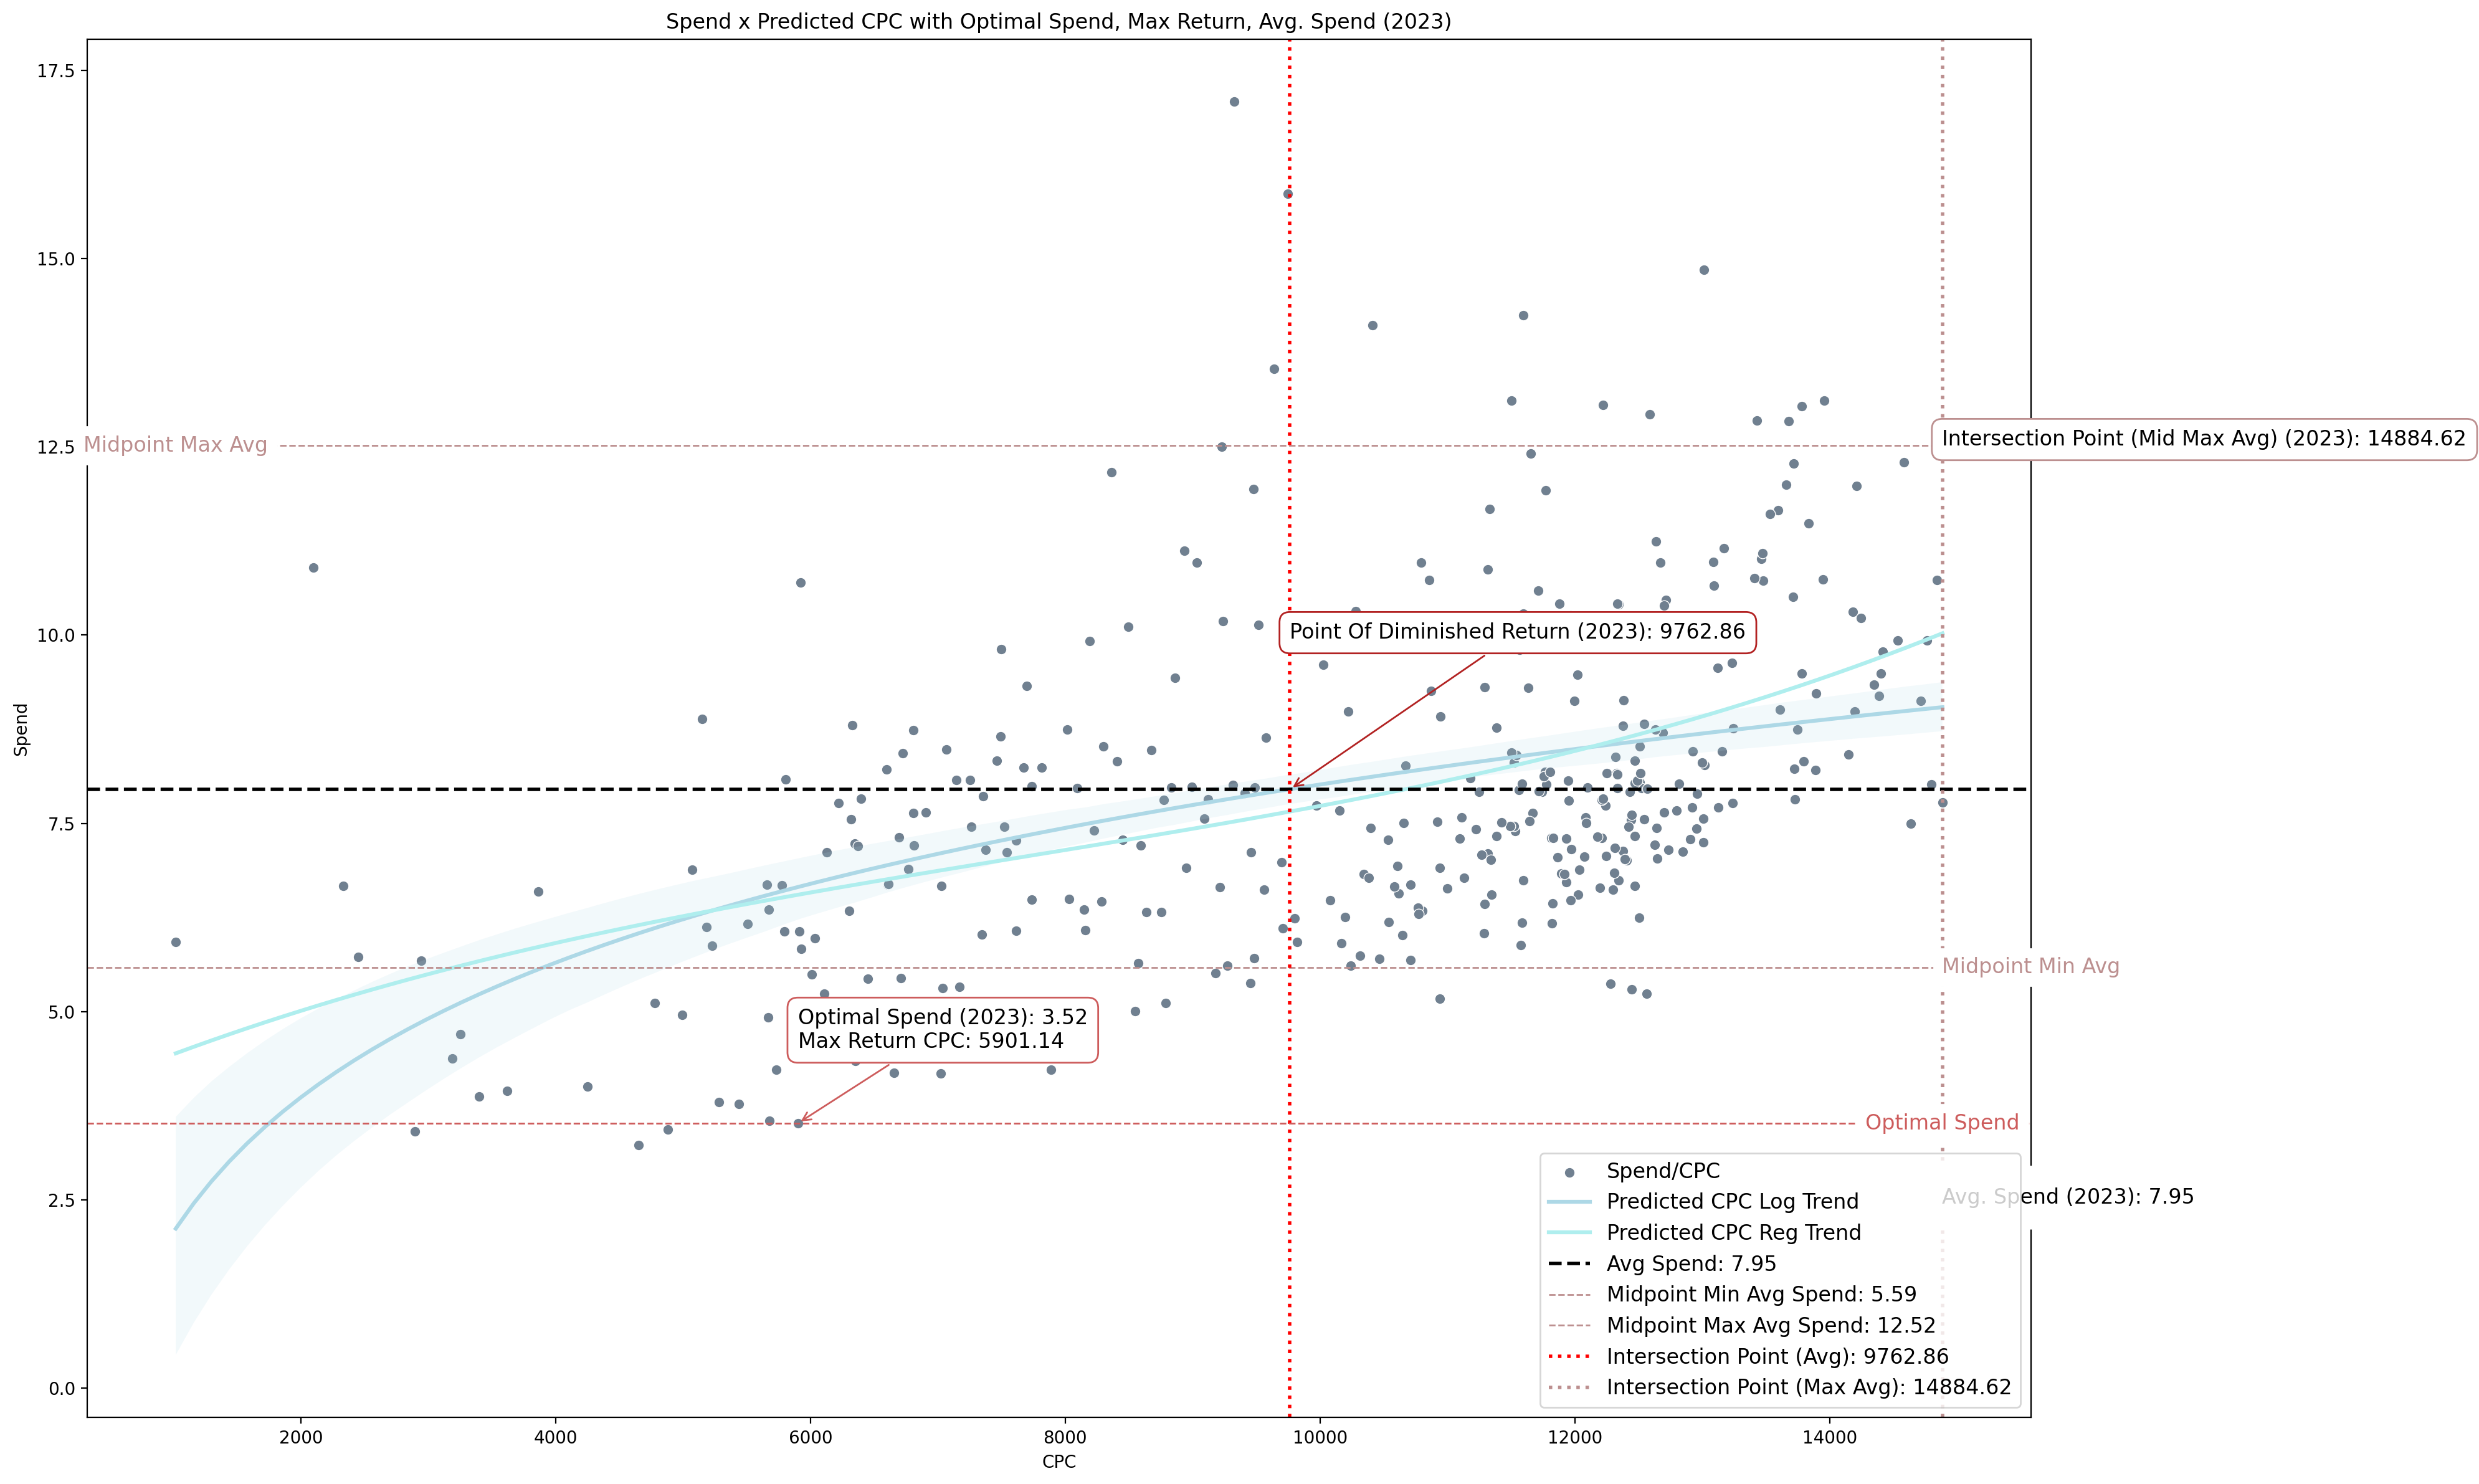

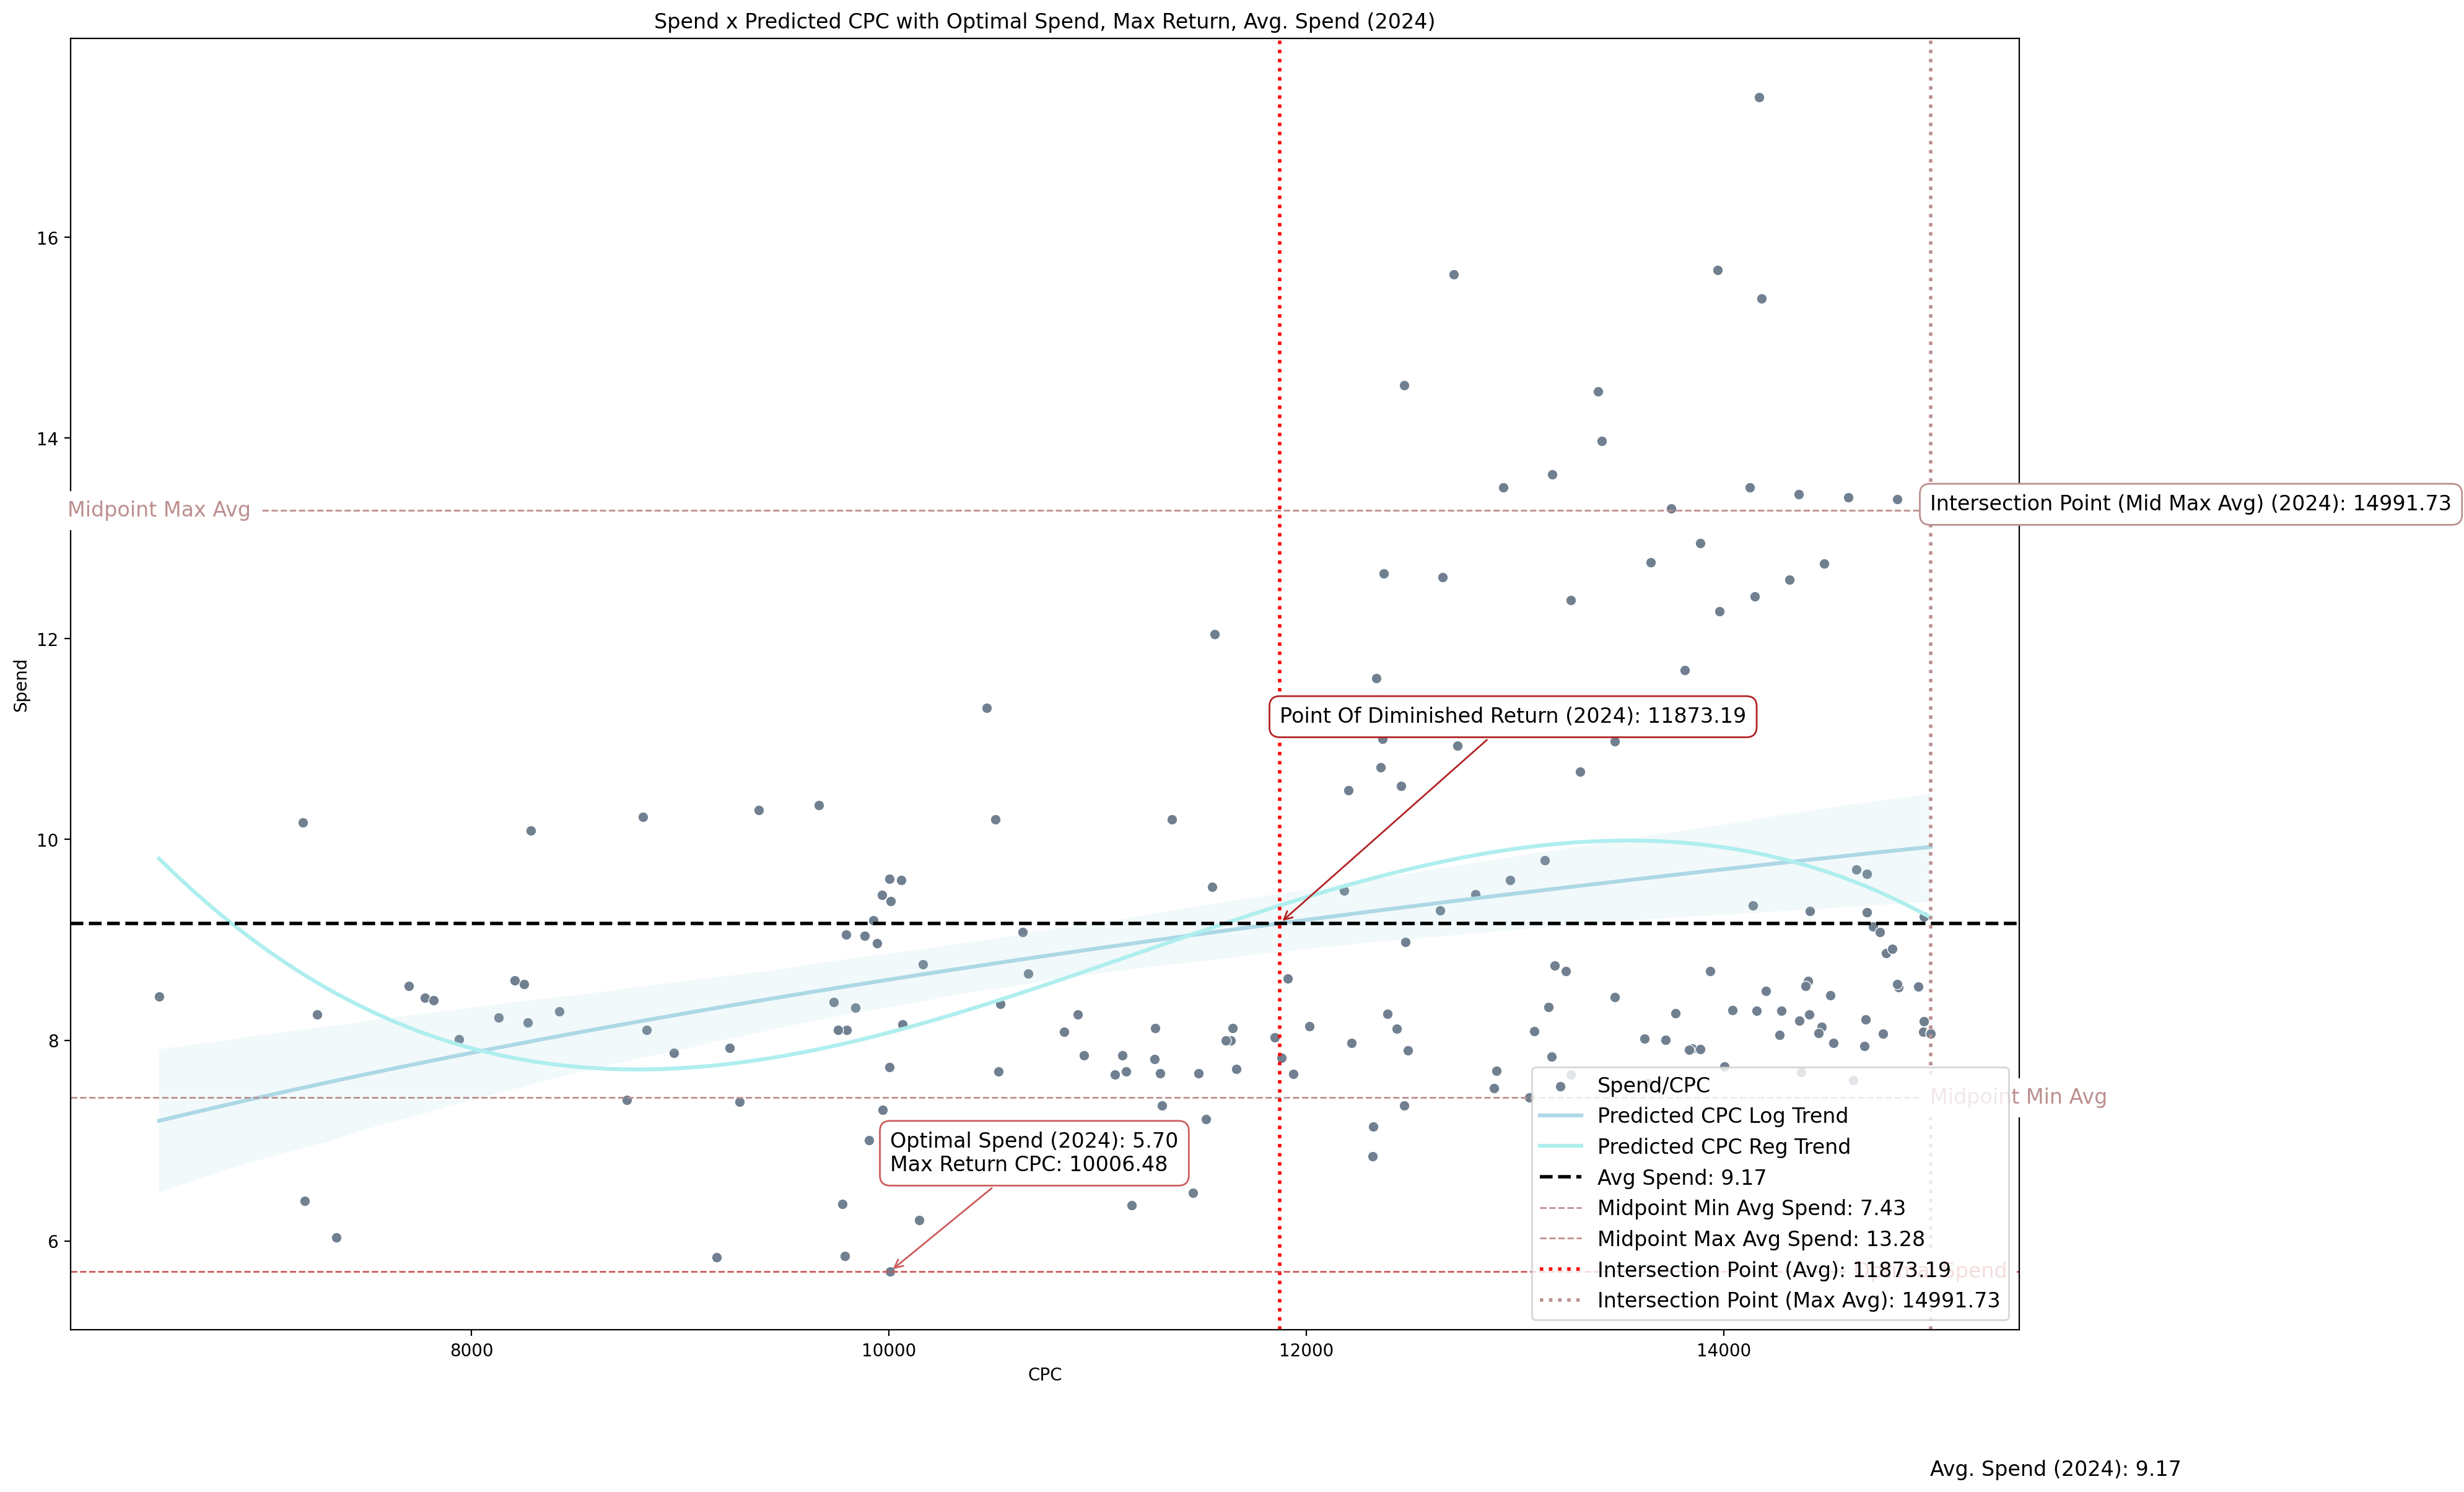

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Normalizing the data
actual_metrics_df3 = actual_metrics_df.copy()
actual_metrics_df4 = actual_metrics_df.copy()
scaler = MinMaxScaler()
actual_metrics_df3[['Normalized ROI Actual', 'Normalized Predicted CPC Actual', 'Normalized Spend Actual']] = scaler.fit_transform(actual_metrics_df3[['ROI Actual', 'Predicted CPC Actual', 'Spend Actual']])

# Smoothing the spend data
actual_metrics_df4['smoothed_spend'] = gaussian_filter1d(actual_metrics_df4['Spend Actual'], sigma=2)

# Plot per year
def plot_yearly_data3(df, year, roi_col, cpc_col, spend_col):
    # Filter year
    yearly_data = df[df.index.year == year]
    
    if yearly_data.empty:
        print(f"No data available for the year {year}.")
        return
    
    # Key levels
    max_roi_index = yearly_data[roi_col].idxmax()
    max_roi_value = yearly_data.loc[max_roi_index, roi_col]
    optimal_spend_value = yearly_data.loc[max_roi_index, spend_col]
    min_cpc_value = yearly_data.loc[max_roi_index, cpc_col]
    avg_spend = yearly_data[spend_col].mean()
    min_avg_spend = yearly_data[spend_col].min()
    max_avg_spend = yearly_data[spend_col].max()
    
    midpoint_min_avg = (avg_spend + min_avg_spend) / 2
    midpoint_max_avg = (avg_spend + max_avg_spend) / 2
    
    yearly_data['date_num'] = mdates.date2num(yearly_data.index.to_pydatetime())
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(data=yearly_data, x=cpc_col, y=spend_col, label='Spend/CPC', color='slategray')
    
    # Fit regression models
    reg1 = sns.regplot(x=cpc_col, y=spend_col, data=yearly_data, order=1, scatter=False, logx=True, label='Predicted CPC Log Trend', color='lightblue')
    reg2 = sns.regplot(x=cpc_col, y=spend_col, data=yearly_data, order=3, scatter=False, ci=None, label='Predicted CPC Reg Trend', color='paleturquoise')
    
    # Get the lines from the regplots
    line1 = reg1.get_lines()[0].get_xydata()
    line2 = reg2.get_lines()[0].get_xydata()
    
    # Intersection points from curves
    f_line1 = interp1d(line1[:, 0], line1[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    f_line2 = interp1d(line2[:, 0], line2[:, 1], kind='linear', bounds_error=False, fill_value='extrapolate')
    
    x_vals = np.linspace(yearly_data[cpc_col].min(), yearly_data[cpc_col].max(), 1000)
    y_vals_line1 = f_line1(x_vals)
    y_vals_line2 = f_line2(x_vals)
    
    intersection_x_avg = x_vals[np.argmin(np.abs(y_vals_line1 - avg_spend))]
    intersection_x_min_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_min_avg))]
    intersection_x_max_avg = x_vals[np.argmin(np.abs(y_vals_line1 - midpoint_max_avg))]
    
    plt.axhline(y=avg_spend, color='black', linestyle='--', label=f'Avg Spend: {avg_spend:.2f}', linewidth=2)
    plt.axhline(y=midpoint_min_avg, color='rosybrown', linestyle='--', label=f'Midpoint Min Avg Spend: {midpoint_min_avg:.2f}', linewidth=1)
    plt.axhline(y=midpoint_max_avg, color='rosybrown', linestyle='--', label=f'Midpoint Max Avg Spend: {midpoint_max_avg:.2f}', linewidth=1)
    
    plt.axvline(x=intersection_x_avg, color='red', linestyle=':', label=f'Intersection Point (Avg): {intersection_x_avg:.2f}', linewidth=2)
    #plt.axvline(x=intersection_x_min_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Min Avg): {intersection_x_min_avg:.2f}', linewidth=2)
    plt.axvline(x=intersection_x_max_avg, color='rosybrown', linestyle=':', label=f'Intersection Point (Max Avg): {intersection_x_max_avg:.2f}', linewidth=2)
    
    plt.annotate(f'Optimal Spend ({year}): {optimal_spend_value:.2f}\nMax Return CPC: {min_cpc_value:.2f}', 
                 xy=(min_cpc_value, optimal_spend_value), xytext=(min_cpc_value, optimal_spend_value + 1.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='indianred'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='indianred', facecolor='white'), fontsize=12)

    #plt.annotate(f'Max Return CPC ({year}): {min_cpc_value:.2f}', 
    #             xy=(min_cpc_value, max_roi_value), xytext=(min_cpc_value, max_roi_value + 1.0),
    #             textcoords='data', arrowprops=dict(arrowstyle="->", color='gray'), 
    #             bbox=dict(boxstyle="round,pad=0.5", edgecolor='gray', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Avg. Spend ({year}): {avg_spend:.2f}', 
                 xy=(yearly_data[cpc_col].max(), avg_spend), xytext=(yearly_data[cpc_col].max() - 3.8, avg_spend - 5.5),
                 textcoords='data', #arrowprops=dict(arrowstyle="->", color='black'), 
                 bbox=dict(boxstyle="round,pad=1.0", edgecolor='white', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Point Of Diminished Return ({year}): {intersection_x_avg:.2f}', 
                 xy=(intersection_x_avg, avg_spend), xytext=(intersection_x_avg, avg_spend + 2.0),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='firebrick'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='firebrick', facecolor='white'), fontsize=12)
    
    #plt.annotate(f'Intersection Point (Mid Min Avg) ({year}): {intersection_x_min_avg:.2f}', 
    #             xy=(intersection_x_min_avg, midpoint_min_avg), xytext=(intersection_x_min_avg + 0.1, midpoint_min_avg - 0.5),
    #             textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
    #             bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    
    plt.annotate(f'Intersection Point (Mid Max Avg) ({year}): {intersection_x_max_avg:.2f}', 
                 xy=(intersection_x_max_avg, midpoint_max_avg), xytext=(intersection_x_max_avg - 2.0, midpoint_max_avg),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='rosybrown'), 
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='rosybrown', facecolor='white'), fontsize=12)
    plt.axhline(y=optimal_spend_value, color='indianred', linestyle='--', label=None, linewidth=1)
    #plt.axhline(y=max_roi_value, color='gray', linestyle='--', label=None, linewidth=1)
    plt.text(yearly_data[cpc_col].max(), optimal_spend_value, 'Optimal Spend', color='indianred', va='center', ha='center', backgroundcolor='white', fontsize=12)
    plt.text(yearly_data[cpc_col].max() - 2, midpoint_min_avg, 'Midpoint Min Avg', color='rosybrown', va='center', ha='left', backgroundcolor='white', fontsize=12)
    plt.text(yearly_data[cpc_col].min() + 1, midpoint_max_avg, 'Midpoint Max Avg', color='rosybrown', va='center', ha='center', backgroundcolor='white', fontsize=12)
    
    plt.xlabel('CPC')
    plt.ylabel('Spend')
    plt.title(f'Spend x Predicted CPC with Optimal Spend, Max Return, Avg. Spend ({year})')
    
    # Manage legend entries explicitly
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Remove unwanted labels
    by_label.pop('Max Return', None)
    by_label.pop('Optimal Spend', None)
    plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='lower right')
    
    # Set limits to remove padding
    #plt.xlim(left=yearly_data[cpc_col].min() - 1)  # Set xlim left to 1 less than the minimum CPC value for the year
    #plt.ylim(bottom=yearly_data[spend_col].min() - 1000)  # Adjust as needed, e.g., plt.ylim(bottom=0, top=some_value)
    
    plt.tight_layout()
    
    plt.show()

# Plot
for year in [2022, 2023, 2024]:
    plot_yearly_data3(actual_metrics_df4, year, "ROI Actual", "Spend Actual", "Predicted CPC Actual")


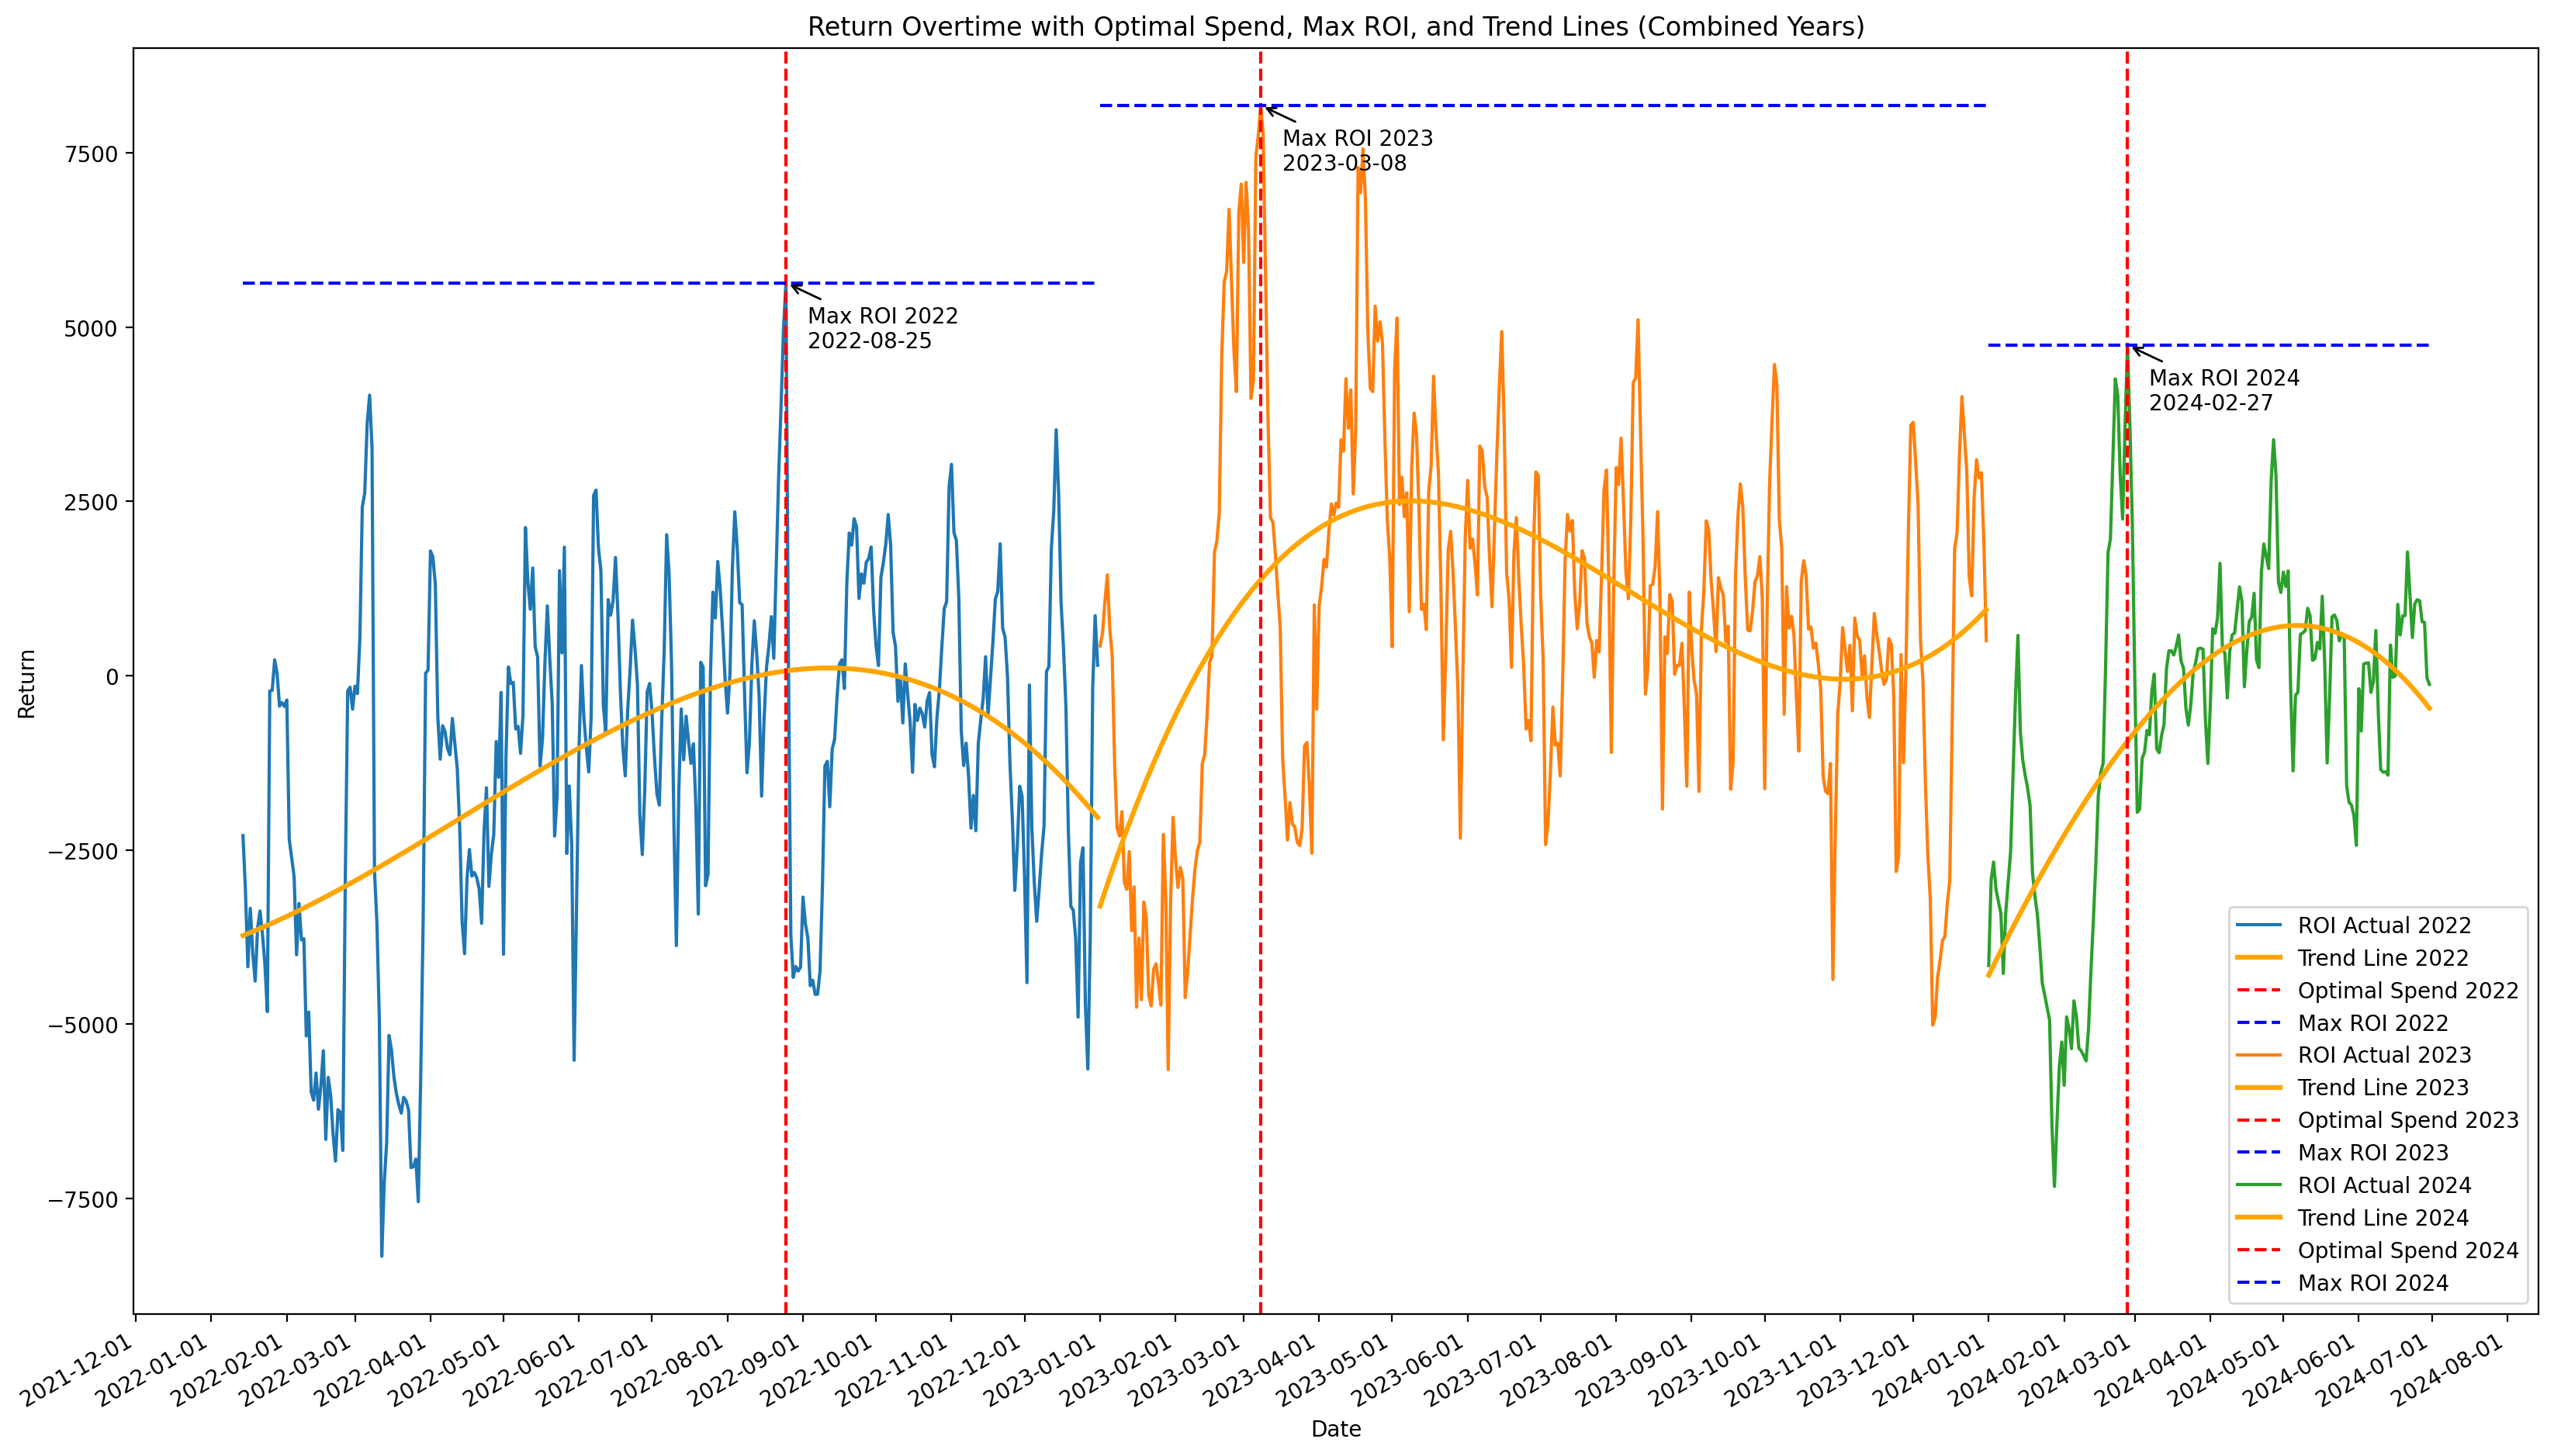

In [49]:
def plot_combined_data(df, years):
    plt.figure(figsize=(20, 12))
    
    # Iterate over each year to plot and annotate
    for year in years:
        # Filter the data for the given year
        yearly_data = df[df.index.year == year]
        
        if yearly_data.empty:
            print(f"No data available for the year {year}.")
            continue
        
        # Calculate the max ROI value
        max_roi_index = yearly_data['ROI Actual'].idxmax()
        max_roi_value = yearly_data.loc[max_roi_index, 'ROI Actual']
        optimal_spend_value = yearly_data.loc[max_roi_index, 'Spend Actual']
        
        # Plot ROI Actual values
        sns.lineplot(data=yearly_data, x=yearly_data.index, y='ROI Actual', label=f'ROI Actual {year}')
        
        # Poly trend/regression
        sns.regplot(x='date_num', y='ROI Actual', data=yearly_data.assign(date_num=mdates.date2num(yearly_data.index.to_pydatetime())), order=3, ci=None, scatter=False, label=f'Trend Line {year}', color='orange')
        
        plt.axvline(x=max_roi_index, color='red', linestyle='--', label=f'Optimal Spend {year}')
        year_start = yearly_data.index.min()
        year_end = yearly_data.index.max()
        plt.hlines(y=max_roi_value, xmin=year_start, xmax=year_end, color='blue', linestyle='--', label=f'Max ROI {year}')
        
        plt.annotate(f'Max ROI {year}\n{max_roi_index.strftime("%Y-%m-%d")}',
                     xy=(mdates.date2num(max_roi_index), max_roi_value), 
                     xycoords='data',
                     xytext=(10, -30), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Return Overtime with Optimal Spend, Max ROI, and Trend Lines (Combined Years)')
    plt.legend()
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.show()

# Plot
plot_combined_data(actual_metrics_df, [2022, 2023, 2024])

In [19]:
roi_df = pd.DataFrame(data={'optimal_spend': optimal_spend, 'max_roi': max_roi, 'actual_spend': spend, 'predicted_cpc': predict_cpc, 'predicted_clicks': predicted_clicks, 'roi': roi})

In [20]:
roi_df.head()

optimal_spend      max_roi  actual_spend  predicted_cpc  \
DATE                                                                  
2022-01-14        5901.14  8566.454038      10500.47      10.747666   
2022-01-15        5901.14  8566.454038       7742.65      13.935435   
2022-01-16        5901.14  8566.454038       8099.69      17.342335   
2022-01-17        5901.14  8566.454038      13105.69      11.268865   
2022-01-18        5901.14  8566.454038      17890.97      11.344940   

            predicted_clicks          roi  
DATE                                       
2022-01-14         977.00000 -2072.829357  
2022-01-15         555.60877 -2949.946772  
2022-01-16         467.04727 -4070.921774  
2022-01-17        1163.00000 -3073.606001  
2022-01-18        1577.00000 -4287.705626

### Estimated ROI Based Prediction

- **predicted_clicks** = actual_spend / predicted_cpc
- **value_per_click** = predicted_clicks * cost_per_click_overall
- **ROI** = value_per_click - actual_spend


1. Model predicts CPC per day from actual spend
2. Using predicted CPC we get the estimate # of clicks at given spend
3. With avg overall CPC of 8.7 (2022-2024) being used as "value per click" we get estimated or value to represent revenue generated from amount of predicted clicks 
4. To get full ROI we can subtract actual spend from the estimated revenue in #3

Aims to find the spend level that maximizes ROI and lowest CPC

In [12]:
pred_df = pd.DataFrame(data={"Actual_Spend": actual_spend, "Actual_CPC": actual_cpc, "Predicted_CPC": pred_cpc})
pred_df['Predicted_Clicks'] = pred_df['Actual_Spend'] / pred_df['Predicted_CPC']
pred_df['Value_Per_Click'] = pred_df['Predicted_Clicks'] * 8.7
pred_df['ROI'] = pred_df['Value_Per_Click'] - pred_df['Actual_Spend']

print('Optimal Spend: ', optimal_spend, 'Max ROI: ', max_roi)
pred_df.head(20)

Optimal Spend:  5901.14 Max ROI:  8847.361649457831


Actual_Spend  Actual_CPC  Predicted_CPC  Predicted_Clicks  \
DATE                                                                    
2022-06-13      10910.71    7.640553       7.640349       1428.038178   
2022-06-14      11216.93    7.800369       7.792952       1439.368511   
2022-06-15      10757.07    7.634542       7.631135       1409.629127   
2022-06-16      10670.71    7.244202       7.248938       1472.037749   
2022-06-17       9582.73    7.696972       7.694888       1245.337207   
2022-06-18       6319.13    8.704036       8.694889        726.763725   
2022-06-19       6473.50    9.989969       9.974236        649.022109   
2022-06-20      11385.93    9.600278       9.595845       1186.547902   
2022-06-21      11282.74    8.766698       8.763179       1287.516824   
2022-06-22      10861.17    8.329118       8.342617       1301.889964   
2022-06-23      10707.94    7.821724       7.823674       1368.658722   
2022-06-24       9186.37    8.058219       8.063106       1139.309059   
2022-06-25       6058.90    8.582011       8.578974        706.249924   
2022-06-26       7976.84   11.187714      11.199612        712.242530   
2022-06-27      12457.30   10.592942      10.572806       1178.239734   
2022-06-28      12149.55    9.727422       9.718071       1250.201794   
2022-06-29      12187.68    8.552758       8.549773       1425.497461   
2022-06-30      11677.55    8.486592       8.485181       1376.228677   
2022-07-01       9683.57    8.908528       8.906465       1087.251760   
2022-07-02       6580.68   10.234339      10.227598        643.423796   

            Value_Per_Click          ROI  
DATE                                      
2022-06-13     12423.932145  1513.222145  
2022-06-14     12522.506044  1305.576044  
2022-06-15     12263.773405  1506.703405  
2022-06-16     12806.728415  2136.018415  
2022-06-17     10834.433697  1251.703697  
2022-06-18      6322.844408     3.714408  
2022-06-19      5646.492351  -827.007649  
2022-06-20     10322.966745 -1062.963255  
2022-06-21     11201.396369   -81.343631  
2022-06-22     11326.442691   465.272691  
2022-06-23     11907.330881  1199.390881  
2022-06-24      9911.988810   725.618810  
2022-06-25      6144.374335    85.474335  
2022-06-26      6196.510009 -1780.329991  
2022-06-27     10250.685683 -2206.614317  
2022-06-28     10876.755607 -1272.794393  
2022-06-29     12401.827910   214.147910  
2022-06-30     11973.189493   295.639493  
2022-07-01      9459.090311  -224.479689  
2022-07-02      5597.787021  -982.892979

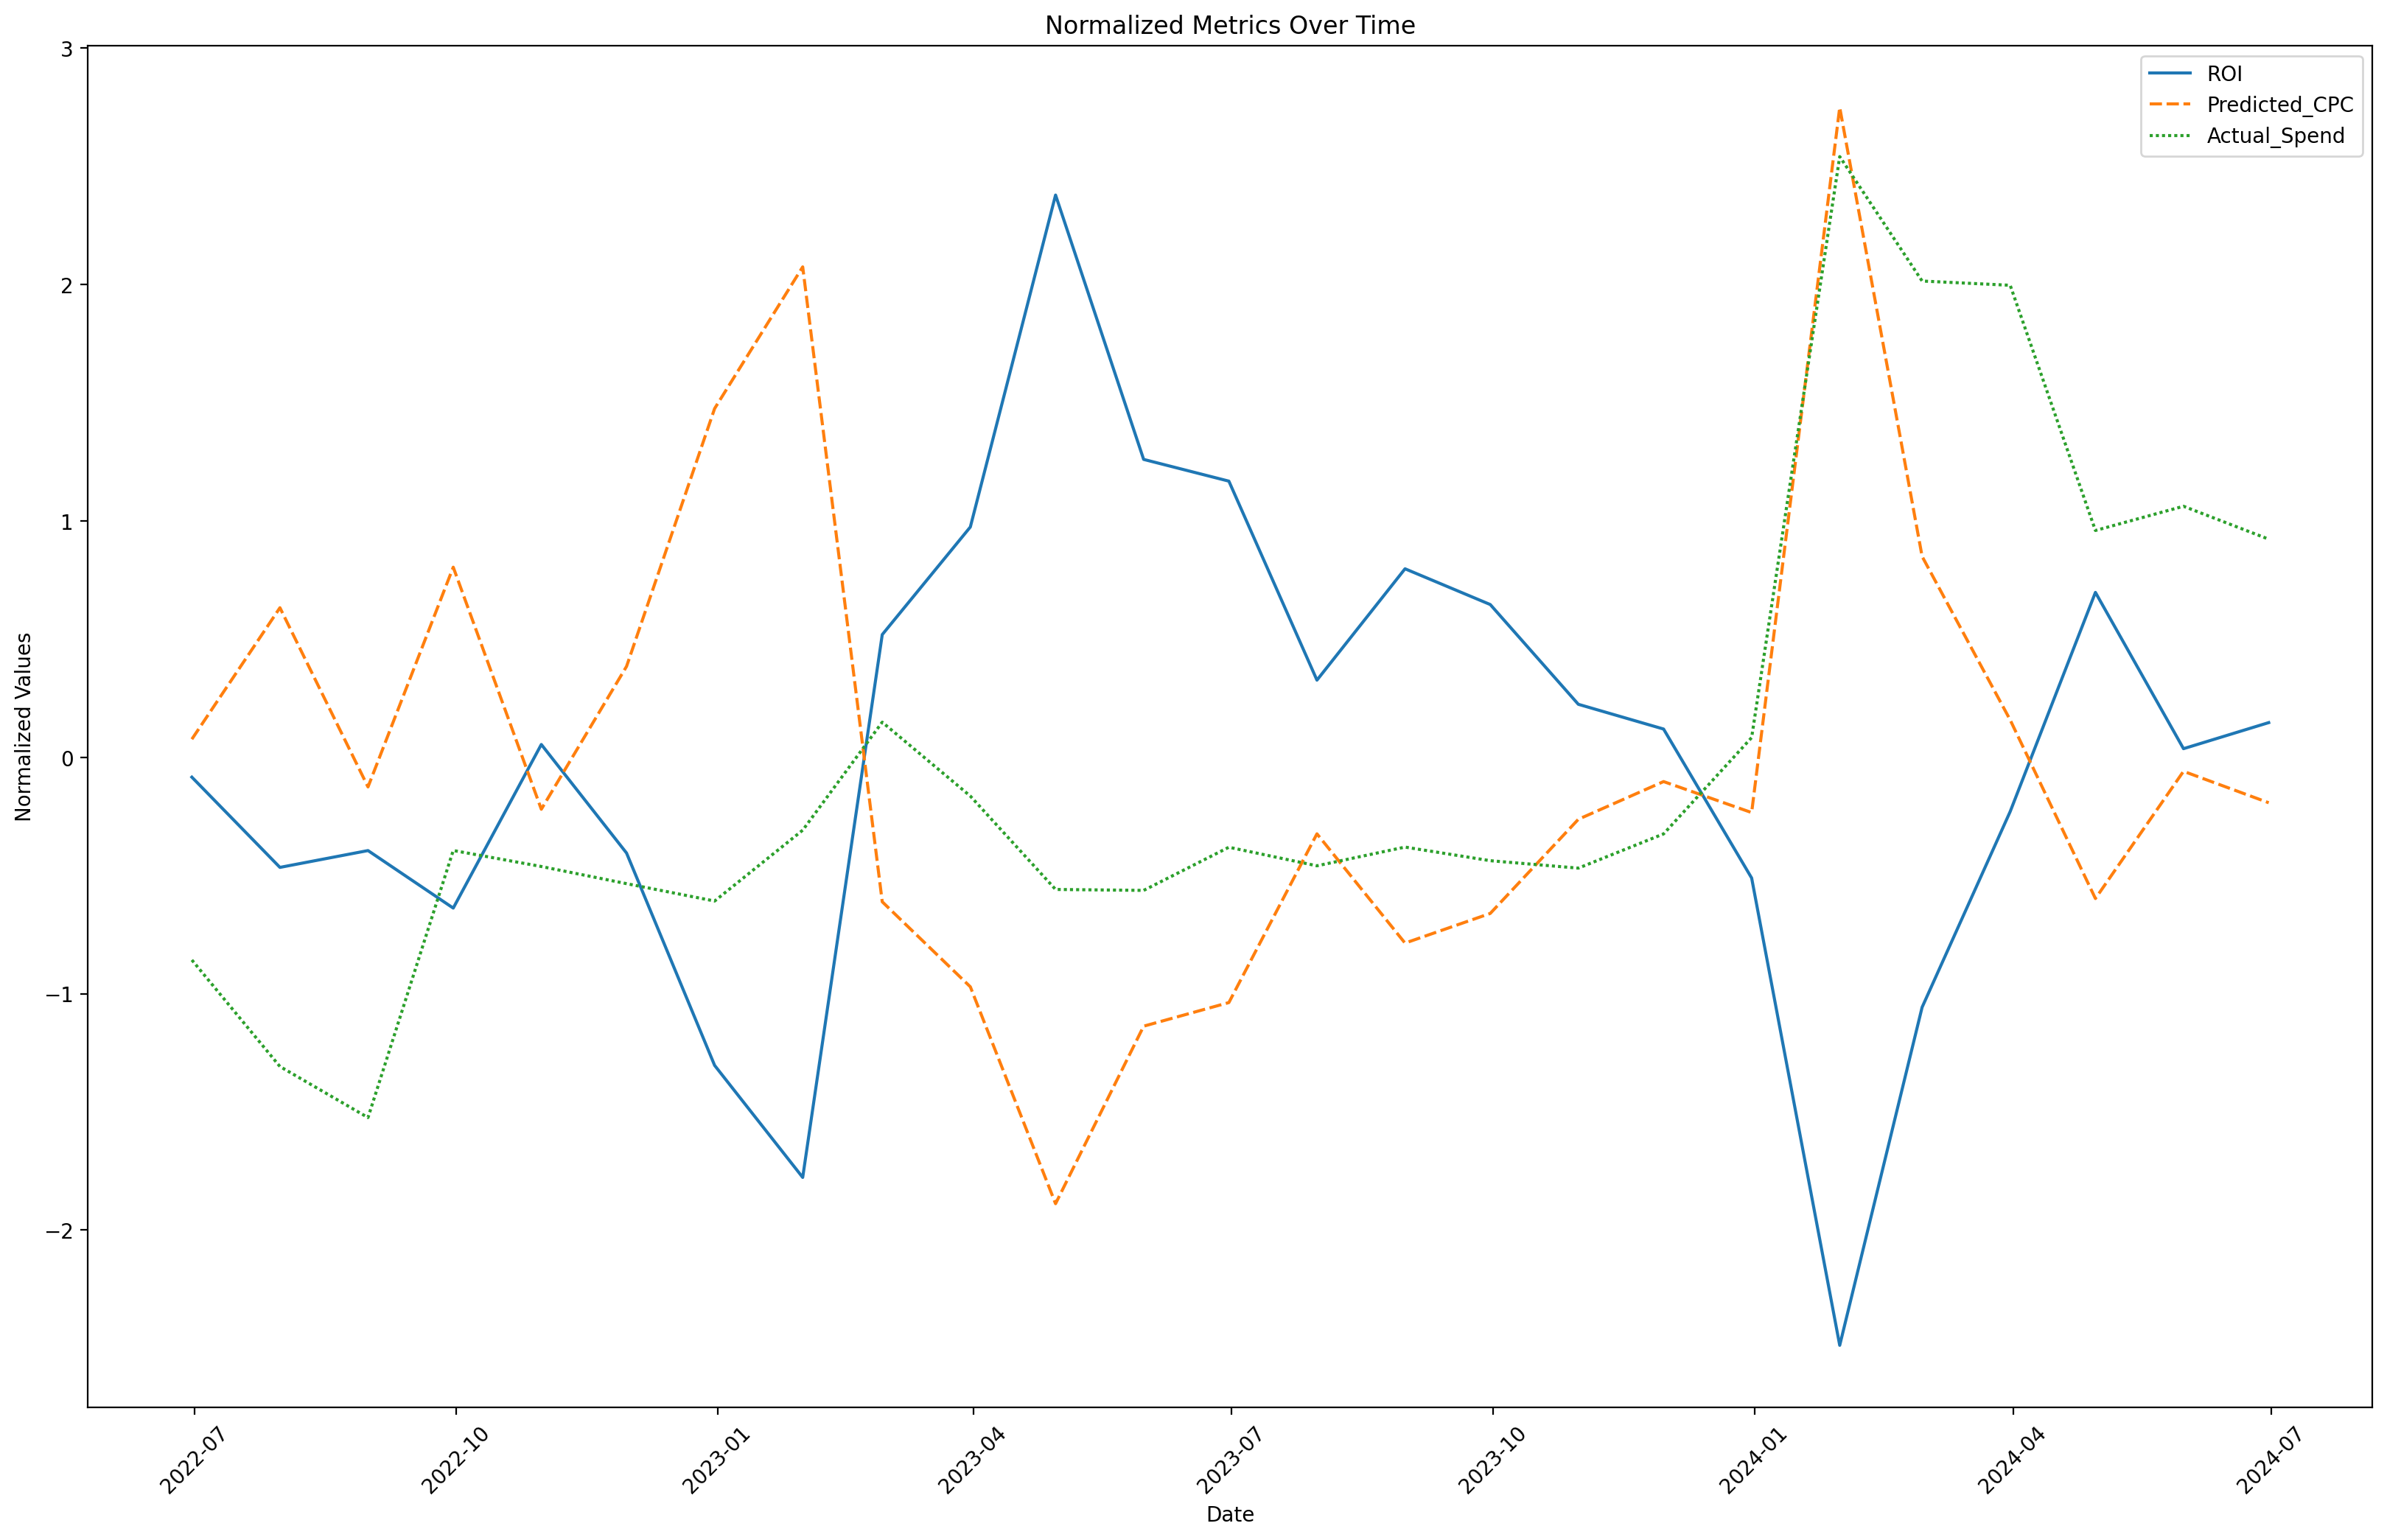

In [16]:
scaler = StandardScaler()

# Resample 
pred_df.index = pd.to_datetime(pred_df.index)
pred_df_monthly_mean = pred_df.resample('M').mean()

pred_df_scaled = pd.DataFrame(scaler.fit_transform(pred_df_monthly_mean), columns=pred_df_monthly_mean.columns, index=pred_df_monthly_mean.index)
plt.figure(figsize=(20, 12))
sns.lineplot(data=pred_df_scaled[['ROI', 'Predicted_CPC', 'Actual_Spend']])

plt.title(f'Normalized Metrics Over Time')
plt.ylabel('Normalized Values')
plt.xlabel('Date')
plt.xticks(rotation=45)  
#plt.legend(df_scaled.columns, loc='upper left')
plt.show()

### SHAP OPTIMAL SPEND

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import pickle

# Preprocess the train data
def preprocess_train(dataset, target, spend):
    X = dataset.drop(target, axis=1, errors='ignore')
    y = dataset[target]
    spend_data = dataset[spend]
    tss = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        spend_train, spend_test = spend_data.iloc[train_index], spend_data.iloc[test_index]
        yield X_train, y_train, X_test, y_test, spend_train, spend_test

# Define ModelWithSHAP class
class ModelWithSHAP:
    def __init__(self, model_pipeline, model_name, preprocessor=None, feature_names=None):
        self.model_pipeline = model_pipeline
        self.model_name = model_name
        self.feature_names = feature_names
        self.preprocessor = preprocessor
        if len(model_pipeline.steps) == 1:
            self.final_estimator = model_pipeline.steps[0][1]
        else:
            self.final_estimator = model_pipeline.steps[-1][1]
        self.explainer = None
        self.shap_values = None
        self.X_transformed = None

    def fit(self, X, y, **fit_params):
        self.model_pipeline.fit(X, y)
        self.feature_names = X.columns.tolist()  # Save feature names
        return self

    def predict(self, X, **predict_params):
        return self.model_pipeline.predict(X)

    def generate_shap(self, X, feature_names=None, background_sample_size=100):
        if feature_names is not None:
            self.feature_names = feature_names
        if self.preprocessor:
            X_copy = X.copy()
            if 'SPEND' not in X_copy.columns:
                X_copy['SPEND'] = 0
            X_copy = X_copy[self.feature_names]
            self.X_transformed = self.preprocessor.transform(X_copy)
        else:
            self.X_transformed = X[self.feature_names]
        background_data = shap.sample(self.X_transformed, background_sample_size)
        if isinstance(self.final_estimator, (RandomForestRegressor, linear_model.LinearRegression, linear_model.Ridge, linear_model.Lasso)):
            self.explainer = shap.TreeExplainer(self.final_estimator, model_output="raw")
        else:
            self.explainer = shap.KernelExplainer(self.final_estimator.predict, background_data)
        if hasattr(self.explainer, 'shap_values'):
            try:
                self.shap_values = self.explainer.shap_values(self.X_transformed, check_additivity=False)
            except TypeError:
                self.shap_values = self.explainer.shap_values(self.X_transformed)
        else:
            self.shap_values = self.explainer.shap_values(self.X_transformed)
        return self.shap_values

    def plot_shap_summary(self, plot_type="bar"):
        if self.shap_values is not None and self.feature_names is not None:
            shap.summary_plot(self.shap_values, features=self.X_transformed, feature_names=self.feature_names, plot_type=plot_type)
        else:
            print("SHAP values or feature names have not been generated yet. Call generate_shap first.")

    def plot_shap_summary2(self, shap_values, plot_type="bar"):
        plt.figure()
        shap.summary_plot(shap_values, features=self.X_transformed, feature_names=self.feature_names, plot_type=plot_type)
        fig = plt.gcf()
        plt.close(fig)
        return fig

    def calculate_optimal_spend(self, spend_range, value_per_click):
        def predict_cpc(spend, model, features):
            features_copy = features.copy()
            features_copy['SPEND'] = spend
            features_copy = features_copy[self.feature_names]
            features_array = self.preprocessor.transform(features_copy) if self.preprocessor else features_copy.to_numpy().reshape(1, -1)
            return model.predict(features_array)[0]

        if self.X_transformed is None:
            raise ValueError("X_transformed is None. Ensure that generate_shap is called before calculate_optimal_spend.")

        optimal_spend = 0
        max_roi = 0
        for spend in spend_range:
            predicted_cpc = predict_cpc(spend, self.model_pipeline, self.X_transformed)
            predicted_clicks = spend / predicted_cpc
            roi = predicted_clicks * value_per_click - spend
            if roi > max_roi:
                max_roi = roi
                optimal_spend = spend

        return optimal_spend, max_roi, roi, predicted_cpc, predicted_clicks, spend

# Perform cross-validation
def perform_cv(model, X, y, scoring='r2'):
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    return {'mean_score': np.mean(scores), 'std_score': np.std(scores)}

# Define the model training and evaluation process
def model(folds, ss=None, y_scaler=None):
    if ss is None:
        ss = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    models = {
        #'OLS': {
        #    'pipeline': Pipeline([('fit', linear_model.LinearRegression())]),
        #    'requires_scaling': True
        #},
        #'Lasso': {
        #    'pipeline': Pipeline([('fit', linear_model.Lasso())]),
        #    'requires_scaling': True,
        #    'param_grid': {'fit__alpha': [0.005, 0.02, 0.03, 0.05, 0.06]}
        #},
        #'Ridge': {
        #    'pipeline': Pipeline([('fit', linear_model.Ridge())]),
        #    'requires_scaling': True,
        #    'param_grid': {'fit__alpha': [550, 580, 600, 620, 650]}
        #},
        'RFR': {
            'pipeline': Pipeline([('fit', RandomForestRegressor())]),
            'requires_scaling': True,
            'param_grid': {
                'fit__n_estimators': [100, 300],
                'fit__max_depth': [10, None],
                'fit__min_samples_split': [2, 5],
                'fit__min_samples_leaf': [1, 2],
                'fit__max_features': ['auto', 'sqrt', 'log2']
            }
        }
    }

    best_estimators = {}
    cv_results = {}
    evaluation_metrics = {}
    model_shap_values = {}
    model_shap_plots = {}
    all_spend_test = []

    for name, model_info in models.items():
        print(f"Processing {name} model...")
        pipeline = model_info['pipeline']
        requires_scaling = model_info['requires_scaling']

        all_X_train = []
        all_y_train = []
        all_X_test = []
        all_y_test = []
        all_spend = []

        for X_train, y_train, X_test, y_test, spend_train, spend_test in folds:
            all_X_train.append(X_train)
            all_y_train.append(y_train)
            all_X_test.append(X_test)
            all_y_test.append(y_test)
            all_spend.append(spend_test)

        print(f"Number of folds for {name}: {len(all_X_train)}")
        if not all_X_train:
            print(f"No folds found for {name} model.")
            continue

        all_X_train = pd.concat(all_X_train)
        all_y_train = pd.concat(all_y_train)
        all_X_test = pd.concat(all_X_test)
        all_y_test = pd.concat(all_y_test)
        all_spend_test = pd.concat(all_spend)

        X_train_processed = ss.fit_transform(all_X_train) if requires_scaling else all_X_train
        X_test_processed = ss.transform(all_X_test) if requires_scaling else all_X_test
        y_train_processed = y_scaler.fit_transform(all_y_train.values.reshape(-1, 1)) if requires_scaling else all_y_train
        y_test_processed = y_scaler.transform(all_y_test.values.reshape(-1, 1)) if requires_scaling else all_y_test

        if 'param_grid' in model_info:
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=model_info['param_grid'],
                cv=5,
                scoring='r2',
                refit=True,
                verbose=1
            )
            grid_search.fit(X_train_processed, y_train_processed.ravel())
            best_model = grid_search.best_estimator_
            best_estimators[name] = best_model
            cv_results[name] = {
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }
        else:
            pipeline.fit(X_train_processed, y_train_processed.ravel())
            best_model = pipeline
            best_estimators[name] = best_model
            cv_results[name] = {'best_score': 'N/A', 'best_params': 'Default'}

        y_pred_processed = best_model.predict(X_test_processed)
        y_pred_original_scale = y_scaler.inverse_transform(y_pred_processed.reshape(-1, 1)).flatten()
        y_test_original_scale = y_scaler.inverse_transform(y_test_processed).flatten()

        r2 = r2_score(y_test_original_scale, y_pred_original_scale)
        mape = round(mean_absolute_percentage_error(y_test_original_scale, y_pred_original_scale), 3)
        mse = round(mean_squared_error(y_test_original_scale, y_pred_original_scale), 3)
        evaluation_metrics[name] = {'R2': r2, 'MAPE': f'{mape:.3f}', 'MSE': f'{mse:.3f}'}

        model_with_shap = ModelWithSHAP(model_pipeline=best_model, model_name=name, preprocessor=ss)
        shap_values = model_with_shap.generate_shap(all_X_test, feature_names=all_X_test.columns.tolist(), background_sample_size=20)
        model_shap_values[name] = shap_values
        shap_plot = model_with_shap.plot_shap_summary2(shap_values)
        model_shap_plots[name] = shap_plot

        plot_preds(y_test_original_scale, y_pred_original_scale, all_spend_test)
        print(f"R2 for {name} model: {r2}")
        print(f"MAPE for {name} model: {mape}")
        print(f"MSE for {name} model: {mse}")

    best_model_name = max(evaluation_metrics, key=lambda name: evaluation_metrics[name]['R2'])
    avg_max_r2 = evaluation_metrics[best_model_name]['R2']

    return {
        'y_test': y_test_original_scale,
        'y_pred': y_pred_original_scale,
        'spend': all_spend_test,
        'best_model_name': best_model_name,
        'best_model': best_estimators[best_model_name],
        'cv_results': cv_results,
        'evaluation_metrics': evaluation_metrics,
        'model_shap_values': model_shap_values,
        'model_shap_plots': model_shap_plots,
        'r2_scores': {model: evaluation_metrics[model]['R2'] for model in models},
        'y_scaler': y_scaler,
        'scaler': ss
    }

# Save the best model
def find_best_model_across_targets_and_save(dataset, target, spend, spend_range, value_per_click, model_save_path):
    overall_best_model = None
    overall_best_r2 = -float('inf')
    overall_best_model_name = ""
    optimal_spend_result = {}
    feature_names = None

    print(f"Running modeling process for target: {target}\n")
    folds = list(preprocess_train(dataset, target, spend))
    results = model(folds)

    best_model_name = results['best_model_name']
    target_best_r2 = float(results['evaluation_metrics'][best_model_name]['R2'])
    print(f"Best model is {best_model_name} with R2 score: {target_best_r2}\n")

    if target_best_r2 > overall_best_r2:
        overall_best_r2 = target_best_r2
        overall_best_model = results['best_model']
        overall_best_model_name = best_model_name
        overall_best_model_metrics = results['evaluation_metrics']
        overall_best_model_shaps = results['model_shap_values']
        overall_best_model_shap_plt = results['model_shap_plots']
        overall_best_model_y_test = results['y_test']
        overall_best_model_y_pred = results['y_pred']
        overall_best_model_spend = results['spend']
        overall_best_model_y_scaler = results['y_scaler']
        overall_best_model_scaler = results['scaler']
        feature_names = dataset.drop([target, spend], axis=1).columns.tolist()
        
        print('Saving best model...')
        # Save the best model
        with open(model_save_path, 'wb') as file:
            pickle.dump({
                'model': overall_best_model,
                'scaler': results['scaler'],
                'y_scaler': results['y_scaler'],
                'feature_names': feature_names
            }, file)
        
        print(f'Best model saved at {model_save_path}')
        
        # Generate SHAP values to set self.X_transformed
        model_with_shap = ModelWithSHAP(model_pipeline=overall_best_model, model_name=best_model_name, preprocessor=results['scaler'], feature_names=feature_names)
        shap_X = dataset.drop([target, spend], axis=1)
        shap_X['SPEND'] = 0  # Add dummy 'SPEND' column
        model_with_shap.generate_shap(shap_X, feature_names=feature_names)

        # Calculate optimal spend
        optimal_spend, max_roi = model_with_shap.calculate_optimal_spend(spend_range, value_per_click)
        optimal_spend_result = {'optimal_spend': optimal_spend, 'max_roi': max_roi}

    best_model_results = {
        'best_model': overall_best_model,
        'best_model_name': overall_best_model_name,
        'overall_best_r2': overall_best_r2,
        'evaluation_metrics': overall_best_model_metrics,
        'model_shap_values': overall_best_model_shaps,
        'model_shap_plots': overall_best_model_shap_plt,
        'y_test': overall_best_model_y_test,
        'y_pred': overall_best_model_y_pred,
        'spend': overall_best_model_spend,
        'y_scaler': overall_best_model_y_scaler,
        'scaler': overall_best_model_scaler,
        'optimal_spend_result': optimal_spend_result
    }

    return best_model_results

# Load the saved model
def load_model(model_path):
    with open(model_path, 'rb') as file:
        model_data = pickle.load(file)
    return model_data

# Generate SHAP values from the loaded model
def generate_shap_from_loaded_model(model_data, dataset, target, spend):
    model_pipeline = model_data['model']
    preprocessor = model_data['scaler']
    feature_names = model_data['feature_names']

    shap_X = dataset.drop([target, spend], axis=1)
    shap_X['SPEND'] = 0  # Add dummy 'SPEND' column

    model_with_shap = ModelWithSHAP(model_pipeline=model_pipeline, model_name="Loaded_Model", preprocessor=preprocessor, feature_names=feature_names)
    model_with_shap.generate_shap(shap_X, feature_names=feature_names)

    return model_with_shap

# Calculate optimal spend with loaded model
def calculate_optimal_spend_with_loaded_model(model_with_shap, spend_range, value_per_click):
    optimal_spend, max_roi, roi, predicted_cpc, predicted_clicks, spend = model_with_shap.calculate_optimal_spend(spend_range, value_per_click)
    return optimal_spend, max_roi, roi, predicted_cpc, predicted_clicks, spend

# Plot predictions
def plot_preds(y_test, y_pred, spend):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    #plt.plot(spend, label="Spend")
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.show()

    spend_vs_actual_predicted = pd.DataFrame({
        'Spend': spend,
        'Actual': y_test,
        'Predicted': y_pred
    })

    print(spend_vs_actual_predicted.tail(30))
    
    # Stats for each eval
    summary_data = {
        'Avg Predicted CPC': [spend_vs_actual_predicted['Predicted'].mean()],
        'Avg Actual CPC': [spend_vs_actual_predicted['Actual'].mean()],
        'Avg Spend': [spend_vs_actual_predicted['Spend'].mean()],
        'Max Predicted CPC': [spend_vs_actual_predicted['Predicted'].max()],
        'Max Actual CPC': [spend_vs_actual_predicted['Actual'].max()],
        'Max Spend': [spend_vs_actual_predicted['Spend'].max()],
        'Min Predicted CPC': [spend_vs_actual_predicted['Predicted'].min()],
        'Min Actual CPC': [spend_vs_actual_predicted['Actual'].min()],
        'Min Spend': [spend_vs_actual_predicted['Spend'].min()]
    }

    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

# Evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    plot_preds(y_test, y_pred)

# Args
target_column = 'CPC'
spend_column = 'SPEND'
spend_range = range(1000, 20000, 500)  # min spend, max spend, increments of 500
model_save_path = 'best_model_optimal.pkl'
value_per_click = cost_per_overall

# Find and save the best model
best_model_results = find_best_model_across_targets_and_save(smaller_set, target_column, spend_column, spend_range, value_per_click, model_save_path)

# Load the best model
loaded_model_data = load_model(model_save_path)

# Generate SHAP values with the loaded model
model_with_shap = generate_shap_from_loaded_model(loaded_model_data, smaller_set, target_column, spend_column)

# Calculate optimal spend with the loaded model
optimal_spend, max_roi, roi, predicted_cpc, predicted_clicks, spend = calculate_optimal_spend_with_loaded_model(model_with_shap, spend_range, value_per_click)

print(f"Optimal Spend: {optimal_spend}, Max ROI: {max_roi}")


Running modeling process for target: CPC

Processing RFR model...
Number of folds for RFR: 5
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
avg_total_spend = smaller_set['SPEND'].mean()
min_total_spend = smaller_set['SPEND'].min()
max_total_spend = smaller_set['SPEND'].max()
print(avg_total_spend)
print(min_total_spend)
print(max_total_spend)

In [ ]:
import shap

# Args
target_column = 'CPC'
spend_column = 'SPEND'
spend_range = range(1000, 20000, 500) # min spend, max spend, increments of 500
model_save_path = 'best_model.pkl'
value_per_click = cost_per_overall

# Find best model
best_model_results = find_best_model_across_targets_and_save(
    smaller_set, target_column, spend_column, spend_range, value_per_click,
    model_save_path)

In [ ]:
def load_model_and_calculate_optimal_spend(model_load_path, dataset, target, spend, spend_range, value_per_click):
    with open(model_load_path, 'rb') as file:
        saved_data = pickle.load(file)

    best_model = saved_data['model']
    scaler = saved_data['scaler']
    y_scaler = saved_data['y_scaler']
    feature_names = saved_data['feature_names']

    model_with_shap = ModelWithSHAP(model_pipeline=best_model, model_name='Loaded Best Model', preprocessor=scaler, feature_names=feature_names)
    shap_X = dataset.drop([target, spend], axis=1)
    shap_X['SPEND'] = 0  # Add dummy 'SPEND' column
    shap_X = shap_X[feature_names]  # Ensure the order matches the training order
    model_with_shap.generate_shap(shap_X, feature_names=feature_names)

    # Calculate optimal spend
    optimal_spend, max_roi = model_with_shap.calculate_optimal_spend(spend_range, value_per_click)
    return {'optimal_spend': optimal_spend, 'max_roi': max_roi}

# Example usage
optimal_spend_result = load_model_and_calculate_optimal_spend(model_save_path, smaller_set, target_column, spend_column, spend_range, value_per_click)
print(f'Optimal Spend: {optimal_spend_result["optimal_spend"]}, Maximum ROI: {optimal_spend_result["max_roi"]}')
